<a href="https://colab.research.google.com/github/igcampos/Mestrado/blob/main/saturacao_implicit6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implicit solution program

Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import time
import sys
from collections.abc import Iterable
import timeit
from sympy import * 
from scipy.misc import derivative 

##  A simple Newton-Raphson program

In [ ]:
# test program
# implementation of netwon-raphson method
# [J]dX = -r
# nonlinear system:
# (x-4)^2 + (y-4)^2 =5
# x^2 + y^2 = 16


In [ ]:
# defining the residual vectors
def residual_vectors(ab):
  x,y = ab
  return ([(x-4)**2 +(y-4)**2 - 5,
         x**2 + y**2 - 16]
         )


In [ ]:
# defining the jacobian matrix
def jacobin_matrix(ab):
  x,y = ab
  return ([2*(x-4),2*(y-4)],
         [2*x,2*y]
         )


In [ ]:
# defining the Newton-Raphson function
def newton_raphson(fun,jac,x_init,max_ite):
  max_iteration = max_ite
  epsilon = 10**-6

  xnew = x_init
  for k in range(max_iteration):
    J = np.array(jac(xnew))
    r = np.array(fun(xnew))
    delta = np.linalg.solve(J,-r)
    xnew = xnew + delta

    if np.linalg.norm(delta) < epsilon:
      print("The system converges at k={}, and the solution are {}".format(k, xnew))
      break
  else:
    print("The solution does not converge! Try increasing iterations")
  
  return xnew



In [ ]:
# applying the function
init_guess = [1,4]

variable_solution =  newton_raphson(residual_vectors,jacobin_matrix,init_guess,100)

The system converges at k=4, and the solution are [1.805829 3.569171]


### Saturation equations

#### Symbolic derivative calculations

In [ ]:
sw_1 = symbols('sw_1') 
sw_2 = symbols('sw_2')

In [ ]:
alpha0  = 0.1 
mi = 0.3  
swi = 0.2
nw = 2
no = 2
sor = 0.2
aw = (1-swi-sor)**nw 
a0 = (1-swi-sor)**no 
d =  0.85
sw_cc = 0.8
sw_ci = 0.2
# defining the residual vectors
r1 = sw_1 + (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - (alpha0*mi*(sw_cc - swi)**nw)/((mi*(sw_cc-swi)**nw)/aw + d*(1-sor-sw_cc)/a0)*(1/aw) - sw_ci 
r2 = sw_2 + (alpha0*mi*(sw_2 - swi)**nw)/((mi*(sw_2-swi)**nw)/aw + d*(1-sor-sw_2)/a0)*(1/aw) - (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - sw_ci


In [ ]:
#defining the derivatives
r1_prime = r1.diff(sw_1)
r2_1_prime = r2.diff(sw_1)
r2_2_prime = r2.diff(sw_2)

In [ ]:
#converting the symbolic varibles to numpy
j11 = lambdify(sw_1, r1_prime, 'numpy')
j21 = lambdify(sw_1, r2_1_prime, 'numpy')
j22 = lambdify(sw_2, r2_2_prime, 'numpy')


In [ ]:
def jacobian_matrix(initial_estimation):
  a,b = initial_estimation
  return ([j11(a), 0],
          [j21(a), j22(b)])
  
def residual_func(initial_estimation):
  a,b = initial_estimation
  return ([r1.subs(sw_1,a),r2.subs([(sw_1,a), (sw_2,b)])])

In [ ]:
# defining the Newton-Raphson function
def newton_raphson(fun,jac,x_init,max_ite):
  max_iteration = max_ite
  epsilon = 10**-10

  xnew = x_init
  for k in range(max_iteration):
    J = np.array(jac(xnew))
    r = np.array(fun(xnew)).astype(np.float64)
    delta = np.linalg.solve(J,-r)
    xnew = xnew + delta
    
    if np.linalg.norm(delta) < epsilon:
      print("The system converges at k={}, and the solution are {}".format(k, xnew))
      break
  else:
    print("The solution does not converge! Try increasing iterations")
  
  return xnew



In [ ]:
# applying the function
init_guess = [0.2,0.2]

variable_solution =  newton_raphson(residual_func,jacobian_matrix,init_guess,100)

The system converges at k=3, and the solution are [0.29930959 0.20069038]


#### Numeric derivative calculations

In [ ]:
# defining the residual equations
# parameter values
alpha0  = 0.1 
mi = 0.3  
swi = 0.2
nw = 2
no = 2
sor = 0.2
aw = (1-swi-sor)**nw 
a0 = (1-swi-sor)**no 
d =  0.85
sw_cc = 0.8
sw_ci = 0.2
# residual equations
def foo(sw_1, sw_2):
  return sw_2 + (alpha0*mi*(sw_2 - swi)**nw)/((mi*(sw_2-swi)**nw)/aw + d*(1-sor-sw_2)/a0)*(1/aw) - (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - sw_ci

def foo1(sw_1):
  return sw_1 + (alpha0*mi*(sw_1 - swi)**nw)/((mi*(sw_1-swi)**nw)/aw + d*(1-sor-sw_1)/a0)*(1/aw) - (alpha0*mi*(sw_cc - swi)**nw)/((mi*(sw_cc-swi)**nw)/aw + d*(1-sor-sw_cc)/a0)*(1/aw) - sw_ci 


In [ ]:
def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(sw_1):
        args[var] = sw_1
        return func(*args)
    return derivative(wraps, point[var], dx = 1e-6)

In [ ]:
#defining the derivatives
partial_derivative(foo, 0, point=[3,1])

0.49172707072830946

In [ ]:
def jacobian_matrix(initial_estimation):
  a,b = initial_estimation
  return ([derivative(foo1, a, dx = 1e-6), 0],
          [partial_derivative(foo, 0, point=[a,b]), partial_derivative(foo, 1, point=[a,b])])
  
def residual_func(initial_estimation):
  a,b = initial_estimation
  return ([foo1(a),foo(a,b)])

In [ ]:
# defining the Newton-Raphson function
def newton_raphson(fun,jac,x_init,max_ite):
  max_iteration = max_ite
  epsilon = 10**-6

  xnew = x_init
  for k in range(max_iteration):
    J = np.array(jac(xnew))
    r = np.array(fun(xnew)) #.astype(np.float64)
    delta = np.linalg.solve(J,-r)
    xnew = xnew + delta
    
    if np.linalg.norm(delta) < epsilon:
      print("The system converges at k={}, and the solution are {}".format(k, xnew))
      break
  else:
    print("The solution does not converge! Try increasing iterations")
  
  return xnew



In [ ]:
# applying the function
init_guess = [0.2,0.2]

variable_solution2 =  newton_raphson(residual_func,jacobian_matrix,init_guess,100)

The system converges at k=2, and the solution are [0.29930959 0.20069038]


## Classes 

### Domain

In [2]:
class Domain:

  def __init__(self, nx, nt, medium):
    """defines domain properties such as grid's number, 
    simulation time and all porous medium properties."""
    self.nx = nx
    self.nt = nt
    self.obj_medium = medium
  
  def vector_domain(self):
    "returns the vector of the domain."
    return np.arange(self.nx)

  def grid_length(self, length_porous):
    """returns the grid length of the domain, in addition stores the porous medium
    length in a new variable."""
    self.length = length_porous
    return length_porous/self.nx

  def grid_dx(self):
    "returns the number of dx from the domain."
    return self.grid_length(self.length)/self.length

  def grid_dt(self, time_step):
    """returns the number of dt from the domain, in addition stores the timestep 
    in a new variable."""
    self.time_step = time_step
    return (time_step*self.obj_medium.ut)/(self.length*self.obj_medium.porosity)

  def courant(self):
    "returns the Courant number"
    return self.grid_dt(self.time_step)/self.grid_dx()


class PorousMedium:

  def __init__(self, porosity, water_viscosity, oil_viscosity, total_velocity):
    """defines the porous medium properties such as porosity, water viscosity, 
    oil viscosity and total velocity of the injected fluid """
    self.porosity = porosity
    self.wvis = water_viscosity
    self.ovis = oil_viscosity
    self.ut = total_velocity
    





### Relative Permeability

In [3]:
class RelativePermeability(ABC):
  """This is an abstract class that defines connate water saturation, residual oil saturation
  and some abstract methods"""
  def __init__(self, swi, sor):
    self.swi = swi
    self.sor = sor

  @abstractmethod
  def water_kr(self):
    pass

  @abstractmethod
  def oil_kr(self):
    pass

  def relative_permeability_curves(self):
    self.sw_vector = np.arange(self.swi, 1-self.sor, 0.01)
    self.krw = self.water_kr(self.sw_vector)
    krw = self.krw 
    self.kro = self.oil_kr(self.sw_vector)
    kro = self.kro 

    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1,1,1)

    ax.plot(self.sw_vector, self.krw)
    ax.plot(self.sw_vector, self.kro)

    ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
    ax.set_ylabel("Relative Permeability", fontsize = 15)
    ax.set_title("Curva de Permeabilidade relativa", fontsize = 20)

  def curves_comparision(self, perm, label):
    label1,label2 = label
    perm1,perm2 = perm
    self.obj_perm1 = perm1
    self.obj_perm2 = perm2
    #x-axis
    sw_vector1 = np.arange(self.perm1.swi, 1-self.perm1.sor, 0.01)
    sw_vector2 = np.arange(self.perm2.swi, 1-self.perm2.sor, 0.01)
    
    #y-axis
    self.krw1 = self.water_kr(sw_vector1)
    self.kro1 = self.oil_kr(sw_vector1) 
    self.krw2 = self.obj_perm1.water_kr(sw_vector2)
    self.kro2 = self.obj_perm1.oil_kr(sw_vector2)
    
    #plot
    fig = plt.figure(figsize=(10,8))
    plt.plot(sw_vector1, self.krw1, 'b', label = f'krw - {label1}')
    plt.plot(sw_vector1, self.kro1, 'y', label = f'kro - {label1}')
    plt.plot(sw_vector2, self.krw2, 'b--', label = f'krw - {label2}')
    plt.plot(sw_vector2, self.kro2, 'y--', label = f'kro - {label2}')

    plt.xlabel("Water Saturation (Sw)", fontsize = 15)
    plt.ylabel("Relative Permeability", fontsize = 15)
    plt.title("Relative Permeability Curve", fontsize = 20)
    plt.legend(loc="upper right")
    plt.show()

  def three_curves_comparision(self, hs_perm, ls_perm, test_1 = 'None', test_2 = 'None', test_3 = 'None', label1 = 'None', label2 = 'None', label3 = 'None'):
    sw_vector1 = np.arange(hs_perm.swi, 1-hs_perm.sor, 0.01)
    krw1 = hs_perm.water_kr(sw_vector1)
    kro1 = hs_perm.oil_kr(sw_vector1)

    sw_vector2 = np.arange(ls_perm.swi, 1-ls_perm.sor, 0.01)
    krw2 = ls_perm.water_kr(sw_vector2)
    kro2 = ls_perm.oil_kr(sw_vector2)

    sw_vector3 = np.arange(test_1.swi, 1-hs_perm.sor, 0.01)
    krw3 = test_1.water_kr(sw_vector3)
    kro3 = test_1.oil_kr(sw_vector3)
    
    sw_vector4 = np.arange(test_2.swi, 1-hs_perm.sor, 0.01)
    krw4 = test_2.water_kr(sw_vector4)
    kro4 = test_2.oil_kr(sw_vector4)
    
    sw_vector5 = np.arange(test_3.swi, 1-hs_perm.sor, 0.01)
    krw5 = test_3.water_kr(sw_vector5)
    kro5 = test_3.oil_kr(sw_vector5)  

    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1,1,1)

    ax.plot(sw_vector1, krw1, 'b', label = 'krw - HiSal')
    ax.plot(sw_vector1, kro1, 'y', label = 'kro - Hisal')
    ax.plot(sw_vector2, krw2, 'b--', label = 'krw - Losal')
    ax.plot(sw_vector2, kro2, 'y--', label = 'kro - Losal')
    
    ax.plot(sw_vector3, krw3, color = 'blue', linestyle = 'dotted', label = f'krw - {label1}')
    ax.plot(sw_vector3, kro3, color = 'yellow', linestyle = 'dotted', label = f'kro - {label1}')
    
    ax.plot(sw_vector4, krw4, color = 'blue', linestyle = 'dashdot', label = f'krw - {label2}')
    ax.plot(sw_vector4, kro4, color = 'yellow', linestyle = 'dashdot', label = f'kro - {label2}')
    
    ax.plot(sw_vector5, krw5, color = 'blue', linestyle = (0, (1, 10)), label = f'krw - {label3}')
    ax.plot(sw_vector5, kro5, color = 'yellow', linestyle = (0, (1, 10)), label = f'kro - {label3}')

    ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
    ax.set_ylabel("Relative Permeability", fontsize = 15)
    ax.set_title("Relative Permeability Curve", fontsize = 20)
    ax.legend(loc="upper right")
    
    plt.show()
  
  def rel_perm_ions(self, perm, concentration, label1 = 'None'):
    if (len(perm) == 2):
      perm1,perm2 = perm
      c_na_hsw,c_na_lsw = concentration
      #x-axis
      sw_vector1 = np.arange(perm1.swi, 1-perm1.sor_function(c_na_hsw), 0.01)
      sw_vector2 = np.arange(perm2.swi, 1-perm2.sor_function(c_na_lsw), 0.01)
      #y-axis
      krw1 = perm1.water_kr(sw_vector1, c_na_hsw)
      kro1 = perm1.oil_kr(sw_vector1, c_na_hsw)
      krw2 = perm2.water_kr(sw_vector2, c_na_lsw)
      kro2 = perm2.oil_kr(sw_vector2, c_na_lsw)
      #plot  
      fig = plt.figure(figsize=(10,8))
      ax = plt.subplot(1,1,1)

      ax.plot(sw_vector1, krw1, 'b', label = 'krw - HiSal')
      ax.plot(sw_vector1, kro1, 'y', label = 'kro - Hisal')
      ax.plot(sw_vector2, krw2, 'b--', label = 'krw - Losal')
      ax.plot(sw_vector2, kro2, 'y--', label = 'kro - Losal')
      #Settings         
      ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
      ax.set_ylabel("Relative Permeability", fontsize = 15)
      ax.set_title("Relative Permeability Curve", fontsize = 20)
      ax.legend(loc="upper right")

    else:
      perm1,perm2,perm3 = perm
      c_na_hsw,c_na_lsw, c_na_test = concentration
      #x-axis
      sw_vector1 = np.arange(perm1.swi, 1-perm1.sor_function(c_na_hsw), 0.01)
      sw_vector2 = np.arange(perm2.swi, 1-perm2.sor_function(c_na_lsw), 0.01)
      sw_vector3 = np.arange(perm3.swi, 1-perm3.sor_function(c_na_test), 0.01)
      #y-axis
      krw1 = perm1.water_kr(sw_vector1, c_na_hsw)
      kro1 = perm1.oil_kr(sw_vector1, c_na_hsw)
      krw2 = perm2.water_kr(sw_vector2, c_na_lsw)
      kro2 = perm2.oil_kr(sw_vector2, c_na_lsw)
      krw3 = perm3.water_kr(sw_vector3, c_na_test)
      kro3 = perm3.oil_kr(sw_vector3, c_na_test)
      #Plot  
      fig = plt.figure(figsize=(10,8))
      ax = plt.subplot(1,1,1)

      ax.plot(sw_vector1, krw1, 'b', label = 'krw - HiSal')
      ax.plot(sw_vector1, kro1, 'y', label = 'kro - Hisal')
      ax.plot(sw_vector2, krw2, 'b--', label = 'krw - Losal')
      ax.plot(sw_vector2, kro2, 'y--', label = 'kro - Losal')
      ax.plot(sw_vector3, krw3, color = 'blue', linestyle = 'dotted', label = f'krw - {label1}')
      ax.plot(sw_vector3, kro3, color = 'yellow', linestyle = 'dotted', label = f'kro - {label1}')
      #Settings  
      ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
      ax.set_ylabel("Relative Permeability", fontsize = 15)
      ax.set_title("Relative Permeability Curve", fontsize = 20)
      ax.legend(loc="upper right")
    
class CoreyModel(RelativePermeability):
  "This class resolves the relative permeabilities by Corey Model"

  def __init__(self, swi, sor, nw, no, krw_sor, kro_swi):
    """defines some properties such as corey parameters, relative permeabilities of the endpoints,
    and also the properties of the abstract classes."""
    self.nw = nw
    self.no = no
    self.krw_sor = krw_sor
    self.kro_swi = kro_swi
    self.swi = swi
    self.sor = sor
    super().__init__(swi, sor)

  def water_kr(self, sw):
    "function that calculates the relative permeability of water"
    krw = []

    if isinstance(sw, Iterable):

      for i in sw:
          kr = self.krw_sor*((i-self.swi)/(1-self.swi-self.sor))**self.nw
          if kr > self.krw_sor:
            kr = self.krw_sor
          krw.append(kr)
      krw = np.array(krw)

    else:
        kr = self.krw_sor*((sw-self.swi)/(1-self.swi-self.sor))**self.nw
        if kr > self.krw_sor:
          kr = self.krw_sor
        krw.append(kr)
        krw = np.array(krw)
      
    return krw

  def oil_kr(self, sw):
    "function that calculates the relative permeability of oil"
    kro = []

    if isinstance(sw, Iterable):

      for i in sw:
        kr = self.kro_swi*((1-self.sor-i)/(1-self.swi-self.sor))**self.no
        kro.append(kr)
      kro = np.array([self.kro_swi if i >= 1 else i for i in kro]) 
      kro[-1] = 0.0 

    else:
      kr = self.kro_swi*((1-self.sor-sw)/(1-self.swi-self.sor))**self.no
      if kr > self.kro_swi:
        kr = self.kro_swi
      kro.append(kr)
      kro = np.array(kro) 
    
    return kro
     
class JerauldModel(RelativePermeability):

  def __init__(self):
    pass

  def input_limits(self, limit, swi=0.15, sor=0.3, nw=3, no=2, krw_sor=0.3, kro_swi=0.75):
    if limit == 'hsw':
      self.hsw_input = CoreyModel(swi, sor, nw, no, krw_sor, kro_swi)
    else:
      self.lsw_input = CoreyModel(swi, sor, nw, no, krw_sor, kro_swi)
    
  def set_interpolator(self, sor):
    self.sor = sor
    self.interpolator = (sor - self.lsw_input.sor)/(self.hsw_input.sor - self.lsw_input.sor)
    self.krw_sor = self.set_end_points(sor)
    self.kro_swi = self.lsw_input.kro_swi
    self.swi = self.lsw_input.swi
    self.nw = self.lsw_input.nw
    self.no = self.lsw_input.no
    
  def set_end_points(self, sor):
    return self.water_kr(1-sor)

  def water_kr(self, sw):
    kr = self.interpolator*self.hsw_input.water_kr(sw) + (1 - self.interpolator)*self.lsw_input.water_kr(sw)
    return kr

  def oil_kr(self, sw):
    kr = self.interpolator*self.hsw_input.oil_kr(sw) + (1 - self.interpolator)*self.lsw_input.oil_kr(sw)
    return kr

class WuModel(RelativePermeability):

  def __init__(self, swi, model='default', coef=1):
    self.coef = coef
    self.swi = swi
    self.rel_model = model
          
  def input_limits(self, sor_hsw=0.3, sor_lsw=0.1, c_na_hsw=0.01, c_na_lsw=0.001):
    self.sor_hsw = sor_hsw
    self.sor_lsw = sor_lsw
    self.c_na_hsw = c_na_hsw
    self.c_na_lsw = c_na_lsw

  def input_limits_corey(self, hsw_perm, lsw_perm):
    self.hsw_input = hsw_perm
    self.lsw_input = lsw_perm

  def sor_function(self, c_na):
    sor = self.sor_lsw + (c_na-self.c_na_lsw)/(self.c_na_lsw-self.c_na_hsw)*(self.sor_lsw-self.sor_hsw)
    return sor

  def set_interpolator(self, c_na):
    interpolator = (self.sor_function(c_na) - self.sor_lsw)/(self.sor_hsw - self.sor_lsw)
    return interpolator
  
  def water_kr(self, sw, c_na=0):
      if self.rel_model == 'default':
        krw = ((sw-self.swi)/(1-self.swi))**(2+self.coef)
      else:
        krw = self.set_interpolator(c_na)*self.hsw_input.water_kr(sw) + (1 - self.set_interpolator(c_na))*self.lsw_input.water_kr(sw)
      kr = np.array(krw)
      return kr

  def oil_kr(self, sw, c_na):
    if self.rel_model == 'default':
      kro = ((((1-sw)-self.sor_function(c_na))/(1-self.swi))**2)*(1-((sw-self.swi)/(1-self.swi))**self.coef)
    else:
      kro = self.set_interpolator(c_na)*self.hsw_input.oil_kr(sw) + (1 - self.set_interpolator(c_na))*self.lsw_input.oil_kr(sw)
    kr = np.array(kro)
    return kr

class TripathiModel(RelativePermeability):
  """Here we have three different models, the first model the residual oil saturation is dependent with the salinity. 
  In the second, in addition to the change in sor, the end-point water permeability is altered with salinity. 
  In the last model, we also change the relative permeability exponetial as a function of salinity."""
  
  def __init__(self, swi, model = 'default', model1= 'Corey'):
     self.swi = swi
     self.obj_model = model
     self.rel_model = model1
    
  def input_limits(self, sor_hsw=0.3, sor_lsw=0.1, c_na_hsw=0.01, c_na_lsw=0.001):
    self.sor_hsw = sor_hsw
    self.sor_lsw = sor_lsw
    self.c_na_hsw = c_na_hsw
    self.c_na_lsw = c_na_lsw

  def input_limits_corey(self, hsw_perm, lsw_perm):
    self.hsw_input = hsw_perm
    self.lsw_input = lsw_perm


  def sor_function(self, c_na):
    sor = self.sor_lsw + (c_na-self.c_na_lsw)/(self.c_na_lsw-self.c_na_hsw)*(self.sor_lsw-self.sor_hsw)
    return sor

  def end_point_function(self, c_na):
    krw_sor = self.lsw_input.krw_sor - (c_na-self.c_na_lsw)/(self.c_na_lsw-self.c_na_hsw)*(self.lsw_input.krw_sor-self.hsw_input.krw_sor)
    return krw_sor

  def water_expoent_function(self, c_na):
    nw = self.lsw_input.nw + (c_na-self.c_na_lsw)/(self.c_na_lsw-self.c_na_hsw)*(self.lsw_input.nw-self.hsw_input.nw)
    return nw
  
  def oil_expoent_function(self, c_na):
    no = self.lsw_input.no + (c_na-self.c_na_lsw)/(self.c_na_lsw-self.c_na_hsw)*(self.lsw_input.no-self.hsw_input.no)
    return no

  def set_interpolator(self, c_na):
    interpolator = (self.sor_function(c_na) - self.sor_lsw)/(self.sor_hsw - self.sor_lsw)
    return interpolator
  
  def water_kr(self, sw, c_na=0):
    if self.obj_model == 'default':
      krw = self.hsw_input.krw_sor*((sw-self.swi)/(1-self.swi-self.sor_function(c_na)))**self.hsw_input.nw
      #the end-point relative permeability is set to be igual to hisal
      self.aux = '1'
    elif self.obj_model == 'model2':
      krw = self.end_point_function(c_na)*((sw-self.swi)/(1-self.swi-self.sor_function(c_na)))**self.hsw_input.nw
      self.aux = '2'
    else:
      krw = self.hsw_input.krw_sor*((sw-self.swi)/(1-self.swi-self.sor_function(c_na)))**self.water_expoent_function(c_na)
      self.aux = '3'
    kr = np.array(krw)
    return kr

  def oil_kr(self, sw, c_na):
    if self.obj_model == 'default':
      kro = self.hsw_input.kro_swi*((1-self.sor_function(c_na)-sw)/(1-self.swi-self.sor_function(c_na)))**self.hsw_input.no
      #the end-point relative permeability is set to be igual to hisal
    elif self.obj_model == 'model2':
      kro = self.hsw_input.kro_swi*((1-self.sor_function(c_na)-sw)/(1-self.swi-self.sor_function(c_na)))**self.hsw_input.no
    else:
      kro = self.hsw_input.kro_swi*((1-self.sor_function(c_na)-sw)/(1-self.swi-self.sor_function(c_na)))**self.oil_expoent_function(c_na)
    kr = np.array(kro)
    return kr

class MIEModel(RelativePermeability):
  def __init__(self, swi, model = 'default', model1= 'MIE'):
     self.swi = swi
     self.rel_model = model1
     
     self.ionic_charges = np.array([1,1,2,2,2]) #[Na, Cl, Ca, Mg, SO]
     self.A_MIE = 0.5706 #with a temperature of 80°
     self.B_MIE = 0.3381 #with a temperature of 80°
     self.a0_MIE = np.array([4, 3.5, 5, 5.5, 5]) #[Na, Cl, Ca, Mg, SO]
     self.b0_MIE = np.array([0.075, 0.015, 0.165, 0.2, -0.04]) #[Na, Cl, Ca, Mg, SO]
     self.CEC = 0.013 #eq/Kg of clay

  def input_limits(self, sor_hsw=0.3, sor_lsw=0.15, brine_salinity_hsw=4.5, brine_salinity_lsw=10**(-8)):
    #self.sor_hsw = sor_hsw
    #self.sor_lsw = sor_lsw
    self.brine_salinity_hsw = brine_salinity_hsw
    self.brine_salinity_lsw = brine_salinity_lsw
    
    #selectivity factor limits
    self.Kcana_ls = 1.7
    self.Kcana_hs = 5.1
    self.Kmgna_ls = 1.6
    self.Kmgna_hs = 4.8
    #r constant
    self.r_MIE = 400

  def input_limits_corey(self, hsw_perm, lsw_perm):
    self.hsw_input = hsw_perm
    self.lsw_input = lsw_perm 
    
  def ionic_strength(self, ion_concentration):
    Io = 1/2*np.sum(ion_concentration*(self.ionic_charges**2))
    return Io

  def coefficient_activity(self, ion, ion_concentration):
    Io = self.ionic_strength(ion_concentration)
    term1 = -self.A_MIE*self.ionic_charges[ion]**2*np.sqrt(Io)
    term2 = 1 + self.a0_MIE[ion]*self.B_MIE*np.sqrt(Io)
    term3 = self.b0_MIE[ion]*Io
    gama = 10**(term1/term2+term3)
    return gama

  def brine_salinity(self, ion_concentration):
    return np.sum(ion_concentration*(self.ionic_charges))

  def interpolator(self, ion_concentration):
    return (self.brine_salinity_hsw - self.brine_salinity(ion_concentration))/(self.brine_salinity_hsw-self.brine_salinity_lsw)
  
  def selectivity_factor(self, ion, ion_concentration):
    param_teta = self.interpolator(ion_concentration) 
    if ion == 2:
      K = param_teta*self.Kcana_ls + (1-param_teta)*self.Kcana_hs
    else:
      K = param_teta*self.Kmgna_ls + (1-param_teta)*self.Kmgna_hs
    return K

  def coefficient_ion_exchange(self, ion, c_na, c_ca, c_mg, ion_concentration):
    old_concentration = ion_concentration
    if ion == 0:
      numerator = self.coefficient_activity(ion, old_concentration)*c_na*self.CEC
    elif ion == 2:
      numerator = self.selectivity_factor(ion, old_concentration)*np.sqrt(self.coefficient_activity(ion, old_concentration)*c_ca)*self.CEC
    else:
      numerator = self.selectivity_factor(ion, old_concentration)*np.sqrt(self.coefficient_activity(ion, old_concentration)*c_mg)*self.CEC

    term1 = 2*self.selectivity_factor(2, old_concentration)*np.sqrt(self.coefficient_activity(2, old_concentration)*c_ca)
    term2 = 2*self.selectivity_factor(3, old_concentration)*np.sqrt(self.coefficient_activity(3, old_concentration)*c_mg)
    term3 = self.coefficient_activity(0, old_concentration)*c_na
    denominator = term1 + term2 + term3
    return numerator/denominator

  def set_beta_0(self, ion_concentration_hsw):
    c_na = ion_concentration_hsw[0]
    c_ca = ion_concentration_hsw[2]
    c_mg = ion_concentration_hsw[3]
    self.beta_ca_0 = self.coefficient_ion_exchange(2, c_na, c_ca, c_mg, ion_concentration_hsw)
    self.beta_mg_0 = self.coefficient_ion_exchange(3, c_na, c_ca, c_mg, ion_concentration_hsw)

  def m_parameter(self, ion_concentration):
    # require changes if the implicit method is applied
    c_na = ion_concentration[0]
    c_ca = ion_concentration[2]
    c_mg = ion_concentration[3]
    beta_ca = self.coefficient_ion_exchange(2, c_na, c_ca, c_mg, ion_concentration)
    beta_mg = self.coefficient_ion_exchange(3, c_na, c_ca, c_mg, ion_concentration)
    m = np.max([self.beta_ca_0 - beta_ca, 0]) + np.max([self.beta_mg_0 - beta_mg, 0]) #check the ion concentrations
    return m

  def H_function(self, ion_concentration):
    return 1/(1+self.r_MIE*self.m_parameter(ion_concentration)) #check the amount of ions initially adsorbed 
  
  def water_kr(self, sw, ion_concentration):
    krw = self.H_function(ion_concentration)*self.hsw_input.water_kr(sw) + (1 - self.H_function(ion_concentration))*self.lsw_input.water_kr(sw)
    kr = np.array(krw)
    return kr

  def oil_kr(self, sw, ion_concentration):
    kro = self.H_function(ion_concentration)*self.hsw_input.oil_kr(sw) + (1 - self.H_function(ion_concentration))*self.lsw_input.oil_kr(sw)
    kr = np.array(kro)
    return kr


#### Debugging

In [ ]:
ions_fw = [1.3262, 1.6569, 0.1479, 0.0175, 0]
ions_hsw = [0.45014, 0.51912, 0.01299, 0.04551, 0.02401]
ions_lsw = [0.013262, 0.016570, 0.001479, 0.000175, 0]
perm1.ionic_strength(ions_lsw)

0.018224

In [ ]:
perm1.coefficient_activity(4, ions_lsw)

0.560280835950608

In [ ]:
perm1.brine_salinity(ions_lsw)

0.03314

In [ ]:
perm1.interpolator(ions_fw)

0.2635777783635061

In [ ]:
perm1.selectivity_factor(2, ions_fw)

4.203835553564079

In [14]:
perm1.coefficient_ion_exchange(3, ions_lsw[0], ions_lsw[2], ions_lsw[3], ions_lsw)

0.0014696474051988583

In [ ]:
perm1.m_parameter(ions_lsw)

0.0015957442939471694

In [16]:
perm1.H_function(ions_lsw)

0.610389668049977

### BL model

In [4]:
class BLModel:

  def __init__(self, sw_ci, sw_cc, domain, c_na_ci=0.0, c_na_cc=0.0):
    """This class defines the model that needs to be solved, and in addition stores the 
    initial water saturation and boundary water saturation."""
    self.sw_ci = sw_ci
    self.sw_cc = sw_cc
    self.obj_domain = domain
    self.c_na_ci = c_na_ci
    self.c_na_cc = c_na_cc

  def transition_time_matrix(self):
    "creates a matrix that represents the time transition of the process."
    injection_time = int(self.obj_domain.nt/self.obj_domain.time_step)
    self.injection_time = injection_time
    transition_matrix = np.arange(injection_time)
    self.transition_matrix = transition_matrix
    return transition_matrix
  
  def saturation_matrix(self):
    """creates a matrix that represents the progress of the water saturation 
    in the porous medium in each point grid."""
    saturation_matrix = np.zeros((self.injection_time, self.obj_domain.nx))
    return saturation_matrix

  def concentration_matrix(self):
    """creates a matrix representing the progression of salinity concentration 
    through the porous medium."""
    concentration_matrix = np.zeros((self.injection_time, self.obj_domain.nx))
    return concentration_matrix    



### Fractional Flow

In [5]:
class FractionalFlow(ABC):
  """This is an abstract class that calculates the fractional flow through two 
  different methods, which are called single point upstream and TVD."""
  def __init__(self, medium, perm):
    self.obj_medium = medium
    self.obj_perm = perm
      
  def mobility(self, sw):
    "function that calculates the mobility between interblocks."
    numerator = self.obj_perm.water_kr(sw)/self.obj_medium.wvis
    denominator = self.obj_perm.water_kr(sw)/self.obj_medium.wvis + self.obj_perm.oil_kr(sw)/self.obj_medium.ovis
    
    return numerator/denominator

  def mobility_with_ions(self, sw, c_na):
    "function that calculates the mobility with ions presented between interblocks."
    if self.obj_perm.rel_model == "default":
      numerator = self.obj_perm.water_kr(sw)/self.obj_medium.wvis
      denominator = self.obj_perm.water_kr(sw)/self.obj_medium.wvis + self.obj_perm.oil_kr(sw, c_na)/self.obj_medium.ovis
    else:
      numerator = self.obj_perm.water_kr(sw, c_na)/self.obj_medium.wvis
      denominator = self.obj_perm.water_kr(sw, c_na)/self.obj_medium.wvis + self.obj_perm.oil_kr(sw, c_na)/self.obj_medium.ovis
    aux = np.array(numerator/denominator)
    return aux

  def fractional_flow_curves(self, perm, spu, label):
    "Function that plots the different fractional flow curves, where it is necessary to enter three curves without counting the limits."
    if (len(perm)!=5) or (len(spu)!=5) or (len(label)!=3):
      raise ValueError('Incorrect list length')
      
    else: 
      p1,p2,p3,p4,p5 = perm
      sp1,sp2,sp3,sp4,sp5 = spu
      lb1, lb2, lb3 = label
      
      sw_vector1 = np.arange(p1.swi, 1-p1.sor, 0.0001)
      fw1 = [sp1.mobility(i) for i in sw_vector1]
        
      sw_vector2 = np.arange(p2.swi, 1-p2.sor, 0.0001)
      fw2 = [sp2.mobility(i) for i in sw_vector2]
        
      sw_vector3 = np.arange(p3.swi, 1-p3.sor, 0.0001)
      fw3 = [sp3.mobility(i) for i in sw_vector3]
          
      sw_vector4 = np.arange(p4.swi, 1-p4.sor, 0.0001)
      fw4 = [sp4.mobility(i) for i in sw_vector4]
        
      sw_vector5 = np.arange(p5.swi, 1-p5.sor, 0.0001)
      fw5 = [sp5.mobility(i) for i in sw_vector5]
        
      fig = plt.figure(figsize=(10,8))
      ax = plt.subplot(1,1,1)

      ax.plot(sw_vector1, fw1, 'b', label = 'HiSal')
      ax.plot(sw_vector2, fw2, 'b--', label = 'Losal')
      ax.plot(sw_vector3, fw3, color = 'green', linestyle = 'dotted', label = f'{lb1}')  
      ax.plot(sw_vector4, fw4, color = 'green', linestyle = 'dashdot', label = f'{lb2}')
      ax.plot(sw_vector5, fw5, color = 'green', linestyle = (0, (1, 10)), label = f'{lb3}')

      ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
      ax.set_ylabel("Fractional Flow (fw)", fontsize = 15)
      ax.set_title("Fractional flow vs Saturation Curve", fontsize = 20)
      ax.legend(loc="upper left")
        
      plt.show()

  def fractional_flow_with_ions(self, perm, concentrations, spu, label1):
    "Function that plots the different fractional flow curves, where it is necessary to enter three curves without counting the limits."
    c1,c2,c3 = concentrations
        
    sw_vector1 = np.arange(perm.swi, 1-perm.sor_function(c1), 0.0001)
    fw1 = [spu.mobility_with_ions(i, c1) for i in sw_vector1]
          
    sw_vector2 = np.arange(perm.swi, 1-perm.sor_function(c2), 0.0001)
    fw2 = [spu.mobility_with_ions(i, c2) for i in sw_vector2]
          
    sw_vector3 = np.arange(perm.swi, 1-perm.sor_function(c3), 0.0001)
    fw3 = [spu.mobility_with_ions(i, c3) for i in sw_vector3]
            
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1,1,1)

    ax.plot(sw_vector1, fw1, 'b', label = 'HiSal')
    ax.plot(sw_vector2, fw2, 'b--', label = 'Losal')
    ax.plot(sw_vector3, fw3, color = 'green', linestyle = 'dotted', label = f'{label1}')  

    ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
    ax.set_ylabel("Fractional Flow (fw)", fontsize = 15)
    ax.set_title("Fractional flow vs Saturation Curve", fontsize = 20)
    ax.legend(loc="upper left")
          
    plt.show()

class SinglePointUpstream(FractionalFlow):
  """This is a child class that calculates the fractional flow using a single point
  upstream approach."""

  def __init__(self, medium, perm):
    super().__init__(medium, perm)
    self.obj_medium = medium
    self.obj_perm = perm
    

class TVD(FractionalFlow):
  "This is a child class that calculates the fractional flow using a TVD approach."
      
  def __init__(self,medium, perm, domain):
    super().__init__(medium, perm)
    self.obj_medium = medium
    self.obj_perm = perm
    self.obj_domain = domain

  def limiter_function(self, sw_i, sw_i_plus_one, sw_i_minus_one):
    "function that calculates the limiter function."
    numerator = self.mobility(sw_i) - self.mobility(sw_i_minus_one)
    denumerator = self.mobility(sw_i_plus_one) - self.mobility(sw_i)
    if denumerator == 0:
      r = 1
    else:
      r = numerator/denumerator
    return r 

  def limiter_function2(self, sw_i, sw_i_plus_one, sw_i_minus_one):
    "function that calculates the limiter function."
    numerator = self.mobility(sw_i_plus_one) - self.mobility(sw_i)
    denumerator = self.mobility(sw_i) - self.mobility(sw_i_minus_one)
    if denumerator == 0:
      r = 1
    else:
      r = numerator/denumerator
    return r 

  def van_leer(self, r):
    "function that calculates the van leer parameter."
    fi = (r+abs(r))/(1+abs(r))    
    return fi

  def flow_adjustment(self, r, sw_one, sw_two):
    "function that calculates the flow correction."
    flow_adjustment_function = self.van_leer(r)/2*(self.mobility(sw_one)-self.mobility(sw_two))*(1-self.obj_domain.courant())
      
    return flow_adjustment_function


### Finite Difference

In [6]:
class FiniteDifference(ABC):
  """This is an abstract class that computes the Buckly-Leverett model
  using a finite difference method with an implicit and explicit approach."""

  def __init__(self):
    pass

  @abstractmethod
  def solver(self):
    pass

  @abstractmethod
  def input_parameters(self):
    pass

  def execution_time(self):
    "The purpose of this function is to determine the execution time of the solver."
    return print("The execution time of the solver was {} seconds".format(self.stop - self.start))

  def saturation_curve(self):
    "Function that plots the saturation curves."
    self.matrix = self.obj_saturation
    
    self.matrix = np.insert(self.matrix, 0, values = self.obj_blmodel.sw_cc, axis=1) 
    length_vector = np.linspace(0, 1, self.obj_domain.nx+1)
    #length_vector = np.linspace(0, 1, self.obj_domain.nx)
    fig = plt.figure(figsize=(12,5))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label_1= self.obj_domain.grid_dt(500)
    td_label_2= self.obj_domain.grid_dt(1000)
    td_label_3= self.obj_domain.grid_dt(3000)
    td_label_4= self.obj_domain.grid_dt(4000)


    ax.plot(length_vector, self.matrix[49], label = "t=500 dias-{} PVI".format(td_label_1))
    ax.plot(length_vector, self.matrix[99], label = "t=1000 dias-{} PVI".format(td_label_2))
    ax.plot(length_vector, self.matrix[299], label = "t=3000 dias-{} PVI".format(td_label_3))
    ax.plot(length_vector, self.matrix[399], label = "t=4000 dias-{} PVI".format(td_label_4))

    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Water Saturaiton", fontsize=15)
    plt.title("Saturation Curve - ut = {} ft³/d".format(self.obj_medium.ut), fontsize=20)
    ax.legend(loc="upper right")
    plt.show()

  def saturation_curve_comparision(self, blmodel, saturation_curve, t, label1='none', label2='none'):
    "Function that plots the saturation curves comparision."
    self.matrix = self.obj_saturation
    self.another_matrix = saturation_curve
    self.blmodel2 = blmodel
    
    self.matrix = np.insert(self.matrix, 0, values = self.obj_blmodel.sw_cc, axis=1)
    self.another_matrix = np.insert(self.another_matrix, 0, values = self.blmodel2.sw_cc, axis=1)  
    length_vector = np.linspace(0, 1, self.obj_domain.nx+1)
    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label = self.obj_domain.grid_dt(t)
    n = int(t/10-1)
    if (label1 == 'none') or (label2 == 'none'):
      ax.plot(length_vector, self.matrix[n], label = "{} PVI".format(td_label))
      ax.plot(length_vector, self.another_matrix[n], label = "{} PVI".format(td_label))
    else:
      ax.plot(length_vector, self.matrix[n], 'r--', label = "{}-{} PVI".format(label1, td_label))
      ax.plot(length_vector, self.another_matrix[n], 'k--', label = "{}-{} PVI".format(label2, td_label))
    
    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Saturação da água", fontsize=15)
    plt.title("Curva de Saturação - ut = {} ft³/d".format(self.obj_medium.ut), fontsize=20)
    ax.legend(loc="upper right")
    plt.show()

  def three_saturation_curve_comparision(self, blmodels, saturation_curves, t, labels):
    "Function that plots the saturation curves comparision."
    if (len(blmodels)!=5) or (len(saturation_curves)!=5) or (len(labels)!=3):
      raise ValueError("Incorrect list length")
    else:
      blm1,blm2,blm3,blm4,blm5 = blmodels
      sc1,sc2,sc3,sc4,sc5 = saturation_curves
      lb1, lb2, lb3 = labels 
        
      sc1 = np.insert(sc1, 0, values = blm1.sw_cc, axis=1)
      sc2 = np.insert(sc2, 0, values = blm2.sw_cc, axis=1)
      sc3 = np.insert(sc3, 0, values = blm3.sw_cc, axis=1)
      sc4 = np.insert(sc4, 0, values = blm4.sw_cc, axis=1)
      sc5 = np.insert(sc5, 0, values = blm5.sw_cc, axis=1)

      length_vector = np.linspace(0, 1, self.obj_domain.nx+1)
      
      fig = plt.figure(figsize=(15,8))
      ax = plt.subplot(1,1,1)

      #PVI calculations
      td_label = self.obj_domain.grid_dt(t)
      n = int(t/10-1)
      
      ax.plot(length_vector, sc1[n], 'r', label = "Hisal")
      ax.plot(length_vector, sc2[n], 'r--', label = "Losal")
      ax.plot(length_vector, sc3[n], color = 'green', linestyle = 'dotted', label = f"{lb1}")
      ax.plot(length_vector, sc4[n], color = 'green', linestyle = 'dashdot', label = f"{lb2}")
      ax.plot(length_vector, sc5[n], color = 'green', linestyle = (0, (1, 10)), label = f"{lb3}")
        
      ax.set_xlabel("x/L", fontsize=15)
      ax.set_ylabel("Water Saturation", fontsize=15)
      plt.title("Saturation Curve - {} PVI".format(td_label), fontsize=20)
      ax.legend(loc="upper right")
      plt.show()

  def simpson(self, a, b, n, matrix):
    "This function uses the Simpson's 1/3 rule for numerical integration"
    h = (self.obj_domain.nx-0)/(self.obj_domain.nx-1)
      
    if b == 2:
      I = h*(matrix[n,a] + 4*matrix[n,a+1] + matrix[n,b])/3    
    else:
      even_sum = 0
      odd_sum = 0 
      for i in range(1, self.obj_domain.nx-1):
        if (i%2==0):
          even_sum += matrix[n,i]
        else:
          odd_sum += matrix[n,i]
      
      I = (b-a)*(matrix[n,a]+ 4*odd_sum +2*even_sum + matrix[n,b])/(3*b)
    return I 

  def get_matrix(self):
    "This function gets the saturation matrix"
    return self.obj_saturation

  def oil_recovery(self, medium, saturation):
    self.obj_saturation = saturation
    oil_recovery_matrix = np.zeros((self.obj_blmodel.injection_time, self.obj_domain.nx))
    recovered_oil_vector = []
    a = 0
    b = self.obj_domain.nx-1
    total_oil = np.zeros((2, self.obj_domain.nx))
    total_oil[0,:] = self.obj_blmodel.sw_ci
    above_oil_vector = []

    below_I = self.simpson(a, b, 0, total_oil)

    aux = 0

    for n in self.obj_blmodel.transition_time_matrix():
      for i in range(self.obj_domain.nx):
        oil_recovery_matrix[n,i] = medium.porosity*(self.obj_saturation[n,i] - self.obj_blmodel.sw_ci) 
      aux += 1
      above_I = self.simpson(a, b, n, oil_recovery_matrix)   
      
      #calculation of the oil recovered in a specific timestep 
      recovered_oil = above_I/below_I
      above_oil_vector.append(above_I)
      recovered_oil_vector.append(recovered_oil)

    self.obj_recovered_oil_vector = recovered_oil_vector
    self.above_oil_vector = above_oil_vector
    self.count = aux
  
  def get_recovered_oil_vector(self):
    sample_obj = self.obj_recovered_oil_vector 
    return sample_obj

  def recovery_factor_curve(self, recovered_oil_vector):

    #x-axis 
    pvi = []
    for i in self.obj_blmodel.transition_time_matrix():
      time_pvi = (i+1)*10
      pvi.append(self.obj_domain.grid_dt(time_pvi))
    #plot
    fig = plt.figure(figsize=(8,5))
    
    ax = plt.subplot(1,1,1)
    ax.plot(pvi, recovered_oil_vector)
    ax.set_xlabel("Pore volume injected (PVI)", fontsize=15)
    ax.set_ylabel("Oil recovery", fontsize=15)
    plt.title("Recovery factor", fontsize=20)
    plt.show()

  def recovery_factor_comparision(self, recovered_oil_vector, labels):
    if (len(recovered_oil_vector)!=5) or (len(labels)!=3):
      raise ValueError("Incorrect list length")
    else:
      #x-axis 
      pvi = []
      for i in range(1000):
        time_pvi = (i+1)*10
        pvi.append(self.obj_domain.grid_dt(time_pvi))

      #y-axis
      fr1,fr2,fr3,fr4,fr5 = recovered_oil_vector

      #plot
      lb1,lb2,lb3 = labels
      fig = plt.figure(figsize=(15,7))
      ax = plt.subplot(1,1,1)

      ax.plot(pvi, fr1, 'r', label = 'HiSal')
      ax.plot(pvi, fr2, 'r--', label = 'LoSal')
      ax.plot(pvi, fr3, color = 'green', linestyle = 'dotted', label = f'{lb1}')
      ax.plot(pvi, fr4, color = 'green', linestyle = 'dashdot', label = f'{lb2}')
      ax.plot(pvi, fr5, color = 'green', linestyle = (0, (1, 10)), label = f'{lb3}')

      ax.set_xlabel("Pore volume injected (PVI)", fontsize=15)
      ax.set_ylabel("Oil recovery", fontsize=15)
      plt.title("Recovery factor", fontsize=20)

      ax.legend(loc="upper left")
      plt.show()

  def concentration_curve(self, concentration, c_na, t=3000):
    "Function that plots the concentration curves."
    self.matrix = concentration/c_na
    
    length_vector = np.linspace(0, 1, self.obj_domain.nx)
    fig = plt.figure(figsize=(12,5))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label= self.obj_domain.grid_dt(t)
    aux = int(t*0.1-1)

    ax.plot(length_vector, self.matrix[aux], label = "{} dias-{} PVI".format(t, td_label))
 
    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Normalized Concentration", fontsize=15)
    plt.title("Salt Concentration Curve - ut = {} ft³/d".format(self.obj_medium.ut), fontsize=20)
    ax.legend(loc="upper right")
    plt.show()

  def concentration_comparision(self, concentration, time_vector):
    self.matrix = concentration
    
    #x-axis 
    length_vector = np.linspace(0, 1, self.obj_domain.nx)
    #y-axis
    t1,t2,t3,t4 = time_vector
    
    #plot
    fig = plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label_1= self.obj_domain.grid_dt(t1)
    td_label_2= self.obj_domain.grid_dt(t2)
    td_label_3= self.obj_domain.grid_dt(t3)
    td_label_4= self.obj_domain.grid_dt(t4)

    aux1 = int(t1*0.1-1)
    aux2 = int(t2*0.1-1)
    aux3 = int(t3*0.1-1)
    aux4 = int(t4*0.1-1)

    ax.plot(length_vector, self.matrix[aux1], 'r', label = "{} dias-{} PVI".format(t1, td_label_1))
    ax.plot(length_vector, self.matrix[aux2], 'r--', label = "{} dias-{} PVI".format(t2, td_label_2))
    ax.plot(length_vector, self.matrix[aux3], color = 'green', linestyle = 'dotted', label = "{} dias-{} PVI".format(t3, td_label_3))
    ax.plot(length_vector, self.matrix[aux4], color = 'green', linestyle = 'dashdot', label = "{} dias-{} PVI".format(t4, td_label_4))
    
    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Concentration", fontsize=15)
    plt.title("Concentration Curves", fontsize=20)

    ax.legend(loc="upper left")
    plt.show()

  def concentration_comparision_two(self, concentration1, concentration2, t, label1, label2):
    self.matrix = concentration1
    self.another_matrix = concentration2
    
    #x-axis 
    length_vector = np.linspace(0, 1, self.obj_domain.nx)
    
    #plot
    fig = plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label_1= self.obj_domain.grid_dt(t)
    aux = int(t*0.1-1)

    ax.plot(length_vector, self.matrix[aux], 'r', label = "{}".format(label1))
    ax.plot(length_vector, self.another_matrix[aux], 'r--', label = "{}".format(label2))  

    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Concentration mol/L", fontsize=15)
    plt.title("Concentration Curves - {} dias-{} PVI".format(t, td_label_1), fontsize=20)

    ax.legend(loc="upper left")
    plt.show()
  
  def get_ion_matrix(self):
    "This function gets the ion concentration matrix"
    return self.obj_concentration
  
  def wu_recovery_factor_comparision(self, recovered_oil_vector, label1):
    #y-axis
    fr1,fr2,fr3 = recovered_oil_vector
    
    #x-axis 
    pvi = []

    for i in range(len(fr1)):
      time_pvi = (i+1)*10
      pvi.append(self.obj_domain.grid_dt(time_pvi))

    #plot
    fig = plt.figure(figsize=(15,7))
    ax = plt.subplot(1,1,1)

    ax.plot(pvi, fr1, 'r', label = 'HiSal')
    ax.plot(pvi, fr2, 'r--', label = 'LoSal')
    ax.plot(pvi, fr3, color = 'green', linestyle = 'dotted', label = f'{label1}')

    ax.set_xlabel("Pore volume injected (PVI)", fontsize=15)
    ax.set_ylabel("Oil recovery", fontsize=15)
    plt.title("Recovery factor", fontsize=20)

    ax.legend(loc="upper left")
    plt.show()

class ExplicitMethod(FiniteDifference):
  "This class gathers all the functionality to compute the Buckley-Leverett model using an explicit approach."

  def __init__(self, fw_approach, saturation, blmodel, domain, medium, perm, concentration=1.0):
    self.obj_approach = fw_approach
    self.obj_saturation = saturation
    self.obj_blmodel = blmodel
    self.obj_domain = domain
    self.obj_medium = medium
    self.obj_perm = perm
    self.obj_saturation[0,:] = self.obj_blmodel.sw_ci
    if isinstance(concentration, np.ndarray) == True:
      self.obj_concentration = concentration
      self.obj_concentration[0,:] = self.obj_blmodel.c_na_ci
    else:
      pass
    
    #properties Wu model
    self.A_wu = self.obj_medium.porosity/self.obj_domain.grid_dt(self.obj_domain.time_step)
    self.C_wu = self.obj_medium.porosity/self.obj_domain.grid_dx()
    self.alpha = self.obj_domain.grid_dt(self.obj_domain.time_step)/self.obj_domain.grid_dx()

  def saturation_update(self, sw_i_minus_half, sw_i):
    "Function that updates saturations through fractional flow calculations using a Single point upstream approach."
    lambda_i_minus_half = self.obj_approach.mobility(sw_i_minus_half)
    lambda_i = self.obj_approach.mobility(sw_i)
    return self.obj_domain.grid_dt(self.obj_domain.time_step)/self.obj_domain.grid_dx()*(lambda_i_minus_half - lambda_i) + sw_i 

  def saturation_update_tvd(self, i, sw_i, sw_i_minus_one, sw_i_plus_one):
    "Function that updates saturations through fractional flow calculations using a TVD approach."
    if i == 0:
      lambda_i_minus_half = self.obj_approach.mobility(sw_i_minus_one)
      
    else:
       lambda_i_minus_half = self.aux
       
    if i == (self.obj_domain.nx - 1):
      r = self.obj_approach.limiter_function(sw_i,self.obj_blmodel.sw_ci,sw_i_minus_one)
      #fi = self.obj_approach.van_leer(r)
      lambda_i_plus_half = self.obj_approach.mobility(sw_i) + self.obj_approach.flow_adjustment(r, self.obj_blmodel.sw_ci,sw_i)
    else:
      r = self.obj_approach.limiter_function(sw_i,sw_i_plus_one,sw_i_minus_one)
      #fi = self.obj_approach.van_leer(r)
      lambda_i_plus_half = self.obj_approach.mobility(sw_i) + self.obj_approach.flow_adjustment(r, sw_i_plus_one, sw_i)

    self.aux = lambda_i_plus_half  

    return self.obj_domain.grid_dt(self.obj_domain.time_step)/self.obj_domain.grid_dx()*(lambda_i_minus_half - lambda_i_plus_half) + sw_i 

  def solver(self):
    "Function that explicitly solves the model."

    if isinstance(self.obj_approach, SinglePointUpstream) == True:
      t1 = timeit.default_timer()
      self.start = t1
      #algorithm to calculate the Buckley-Leverett model using Single Point Upstream approach
      
      for n in self.obj_blmodel.transition_time_matrix():
        #first row calculation
        if n == 0:
          for i in self.obj_domain.vector_domain():  
            if i == 0:
              #first grid point
              self.obj_saturation[n,i] = self.saturation_update(self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci)
            else:
              #other points
              self.obj_saturation[n,i] = self.saturation_update(self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci)
        else:
          for i in self.obj_domain.vector_domain():
            if i == 0:
              #first grid point
              self.obj_saturation[n,i] = self.saturation_update(self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i])
            else:
              #other points
              self.obj_saturation[n,i] = self.saturation_update(self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i])            

      t2 = timeit.default_timer()
      self.stop = t2

    else:
      t1 = timeit.default_timer()
      self.start = t1
      #the algorithm to calculate the Buckley-Leverett model using TVD approach

      for n in self.obj_blmodel.transition_time_matrix():
        #first row calculation
        if n == 0:
          for i in self.obj_domain.vector_domain(): 
            if i == 0:
              # first grid point
              self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci)
            else:
              #other points
              self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci)
        else:
          for i in self.obj_domain.vector_domain():
            if i == 0:
              # first grid point
              self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_saturation[n-1,i], self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i+1])
            else:
              #other points
              if i == self.obj_domain.nx-1:
                self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_blmodel.sw_ci)
              else:
                self.obj_saturation[n,i] = self.saturation_update_tvd(i, self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i+1])
      
      matrix = self.obj_saturation
      t2 = timeit.default_timer()
      self.stop = t2
      return matrix            

  #Two components in an aqueous phase
  def saturation_update_with_ions(self, sw_i_minus_one, sw_i, c_na_i_minus_one, c_na_i):
    "Function that updates saturations through fractional flow calculations using a Single point upstream approach."
    lambda_i_minus_half = self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one)
    lambda_i = self.obj_approach.mobility_with_ions(sw_i, c_na_i)
    return (self.obj_domain.grid_dt(self.obj_domain.time_step)/self.obj_domain.grid_dx())*(lambda_i_minus_half - lambda_i) + sw_i

  def concentration_update(self, c_na_i, c_na_i_minus_one, c_na_i_plus_one, sw_i, sw_i_minus_one, sw_i_plus_one, sw_i_n_plus_one):
    "Function that updates the ion concentrations through Advective-diffusive equation using a Single point upstream approach."
    
    term1 = (self.A_wu*sw_i + self.B_wu)*c_na_i #this term was wrong, we have changed sw_i_n_plus_one to sw_i
    term2 = self.C_wu*(c_na_i_minus_one*self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one) - c_na_i*self.obj_approach.mobility_with_ions(sw_i, c_na_i))
    term3 = self.D_wu*(sw_i_plus_one**self.q - sw_i_minus_one**self.q)*(c_na_i_plus_one-2*c_na_i-c_na_i_minus_one)
    term4 = self.A_wu*sw_i_n_plus_one + self.B_wu 
    return (term1+term2+term3)/term4

  def concentration_update_without_diffusion(self, c_na_i, c_na_i_minus_one, sw_i, sw_i_minus_one, sw_i_n_plus_one):
    "Function that updates the ion concentrations through Advective-diffusive equation without the diffusion term using a Single point upstream approach."
    
    term1 = sw_i*c_na_i 
    term2 = self.alpha*(c_na_i_minus_one*self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one) - c_na_i*self.obj_approach.mobility_with_ions(sw_i, c_na_i))
    term4 = sw_i_n_plus_one 
    return (term1+term2)/term4

  def input_parameters(self, Mc, Kd, Dm = 5*(10**-9), coef_p = 1.9, coef_q=1.9):
    self.Mc = Mc
    self.Kd = Kd
    self.Dm = Dm
    self.q = coef_q
    self.B_wu = self.Mc*self.Kd/self.obj_domain.grid_dt(self.obj_domain.time_step)
    self.D_wu = self.Dm*self.obj_medium.porosity**(1+coef_p)/(2*self.obj_domain.grid_dx()**2)

  def solver3(self):
    "Function that explicitly solves the model that capture the mechanism of wettability alteration with Wu's model."

    t1 = timeit.default_timer()
    self.start = t1    
    for n in self.obj_blmodel.transition_time_matrix():
      #first row calculation
      if n == 0:
        for i in self.obj_domain.vector_domain():  
          if i == 0:
            #first grid point
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci, self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_ci)
            self.obj_concentration[n,i] = self.concentration_update(self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci, self.obj_saturation[n,i])
          elif i == self.obj_domain.nx-1:
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci)
            self.obj_concentration[n,i] = self.concentration_update(self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_saturation[n,i]) 
          else:
            #other points
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci)
            self.obj_concentration[n,i] = self.concentration_update(self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_saturation[n,i])
      else:
        for i in self.obj_domain.vector_domain():
          if i == 0:
            #first grid point
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i], self.obj_blmodel.c_na_cc, self.obj_concentration[n-1,i])
            self.obj_concentration[n,i] = self.concentration_update(self.obj_concentration[n-1,i], self.obj_blmodel.c_na_cc, self.obj_concentration[n-1,i+1], self.obj_saturation[n-1,i], self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i+1], self.obj_saturation[n,i])
          elif i == self.obj_domain.nx-1:
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i], self.obj_concentration[n-1,i-1], self.obj_concentration[n-1,i])
            self.obj_concentration[n,i] = self.concentration_update(self.obj_concentration[n-1,i], self.obj_concentration[n-1,i-1], self.obj_concentration[n-1,i-1], self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_blmodel.sw_ci, self.obj_saturation[n,i]) # Here we have changed the Swi+1 from obj_saturation[n-1,i] to obj_blmodel.sw_ci
            #change the c_na i+1 to initial condition 
          else:
            #other points
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i], self.obj_concentration[n-1,i-1], self.obj_concentration[n-1,i])
            self.obj_concentration[n,i] = self.concentration_update(self.obj_concentration[n-1,i], self.obj_concentration[n-1,i-1], self.obj_concentration[n-1,i+1], self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i+1], self.obj_saturation[n,i])            

    t2 = timeit.default_timer()
    self.stop = t2
  
  def solver3_1(self):
    "Function that explicitly solves the losal behavior with Wu's model."

    t1 = timeit.default_timer()
    self.start = t1    
    for n in self.obj_blmodel.transition_time_matrix():
      #first row calculation
      if n == 0:
        for i in self.obj_domain.vector_domain():  
          if i == 0:
            #first grid point
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci, self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_cc)
            #self.obj_concentration[n,i] = self.concentration_update(self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci, self.obj_saturation[n,i])
          else:
            #other points
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_cc)
            #self.obj_concentration[n,i] = self.concentration_update(self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_saturation[n,i])
      else:
        for i in self.obj_domain.vector_domain():
          if i == 0:
            #first grid point
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i], self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_cc)
            #self.obj_concentration[n,i] = self.concentration_update(self.obj_concentration[n-1,i], self.obj_blmodel.c_na_cc, self.obj_concentration[n-1,i+1], self.obj_saturation[n-1,i], self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i+1], self.obj_saturation[n,i])
          elif i == self.obj_domain.nx-1:
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i], self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_cc)
            #self.obj_concentration[n,i] = self.concentration_update(self.obj_concentration[n-1,i], self.obj_concentration[n-1,i-1], self.obj_blmodel.c_na_ci, self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_blmodel.sw_ci, self.obj_saturation[n,i]) # Here we have changed the Swi+1 from obj_saturation[n-1,i] to obj_blmodel.sw_ci
            #change the c_na i+1 to initial condition 
          else:
            #other points
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i], self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_cc)
            #self.obj_concentration[n,i] = self.concentration_update(self.obj_concentration[n-1,i], self.obj_concentration[n-1,i-1], self.obj_concentration[n-1,i+1], self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i+1], self.obj_saturation[n,i])            

    t2 = timeit.default_timer()
    self.stop = t2

  def solver3_2(self):
    "Function that explicitly solves the model without the diffusion term with Wu's model."

    t1 = timeit.default_timer()
    self.start = t1    
    for n in self.obj_blmodel.transition_time_matrix():
      #first row calculation
      if n == 0:
        for i in self.obj_domain.vector_domain():  
          if i == 0:
            #first grid point
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_cc, self.obj_blmodel.sw_ci, self.obj_blmodel.c_na_cc, self.obj_blmodel.c_na_ci)
            self.obj_concentration[n,i] = self.concentration_update_without_diffusion(self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_cc, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_cc, self.obj_saturation[n,i])
          else:
            #other points
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci)
            self.obj_concentration[n,i] = self.concentration_update_without_diffusion(self.obj_blmodel.c_na_ci, self.obj_blmodel.c_na_ci, self.obj_blmodel.sw_ci, self.obj_blmodel.sw_ci, self.obj_saturation[n,i])
      else:
        for i in self.obj_domain.vector_domain():
          if i == 0:
            #first grid point
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_blmodel.sw_cc, self.obj_saturation[n-1,i], self.obj_blmodel.c_na_cc, self.obj_concentration[n-1,i])
            self.obj_concentration[n,i] = self.concentration_update_without_diffusion(self.obj_concentration[n-1,i], self.obj_blmodel.c_na_cc, self.obj_saturation[n-1,i], self.obj_blmodel.sw_cc, self.obj_saturation[n,i])
          else:
            #other points
            self.obj_saturation[n,i] = self.saturation_update_with_ions(self.obj_saturation[n-1,i-1], self.obj_saturation[n-1,i], self.obj_concentration[n-1,i-1], self.obj_concentration[n-1,i])
            self.obj_concentration[n,i] = self.concentration_update_without_diffusion(self.obj_concentration[n-1,i], self.obj_concentration[n-1,i-1], self.obj_saturation[n-1,i], self.obj_saturation[n-1,i-1], self.obj_saturation[n,i])            

    t2 = timeit.default_timer()
    self.stop = t2
  
  #Multiple component transport
  def input_parameters(self, Mc=0.088, Dm = 5*(10**-9), coef_p = 1.9, coef_q=1.9):
    self.Mc = Mc
    self.Dm = Dm
    self.q = coef_q
    self.p = coef_p
    self.P1_MIE = self.obj_medium.porosity/self.obj_domain.grid_dt(self.obj_domain.time_step)
    self.P2_MIE = self.Mc/self.obj_domain.grid_dt(self.obj_domain.time_step)
    self.P3_MIE = self.obj_medium.porosity/self.obj_domain.grid_dx()
    self.P4_MIE = 1/self.obj_domain.grid_dt(self.obj_domain.time_step)
    self.P5_MIE = 1/self.obj_domain.grid_dx()

  def residual_function(self, sw_i_n_plus_one, c_1, c_2, c_3, c_v, c_na_i_minus_one, c_na_i, c_na_i_plus_one, sw_i_minus_one, sw_i, sw_i_plus_one, ion):
    "Private function that creates the residual equations in a generic form."   
    F1_MIE = self.obj_medium.porosity/(2*self.obj_domain.grid_dx()**2)*(self.Dm*self.obj_medium.porosity**self.p*(sw_i_plus_one**self.q + sw_i**self.q)) 
    F2_MIE = self.obj_medium.porosity/(2*self.obj_domain.grid_dx()**2)*(self.Dm*self.obj_medium.porosity**self.p*(sw_i_plus_one**self.q + 2*sw_i**self.q + sw_i_minus_one**self.q))
    F3_MIE = self.obj_medium.porosity/(2*self.obj_domain.grid_dx()**2)*(self.Dm*self.obj_medium.porosity**self.p*(sw_i**self.q + sw_i_minus_one**self.q))
    
    if ion == 5:
      #saturation
      eq = sw_i_n_plus_one + self.obj_domain.courant()*(self.obj_approach.mobility_with_ions(sw_i, c_na_i)- self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one)) - sw_i 
    elif (ion == 1) or (ion == 4):
      #ion without exchange
      term1 = self.P4_MIE*(sw_i_n_plus_one*c_1 - sw_i*c_na_i[ion])
      term2 = self.P5_MIE*(c_na_i[ion]*self.obj_approach.mobility_with_ions(sw_i, c_na_i) - c_na_i_minus_one[ion]*self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one))
      term3 = -F1_MIE*c_na_i_plus_one[ion] + F2_MIE*c_na_i[ion] - F3_MIE*c_na_i_minus_one[ion]
      eq = term1 + term2 + term3 
    else:
      #ion with exchange  
      term1 = self.P1_MIE*(sw_i_n_plus_one*c_1 - sw_i*c_na_i[ion])
      term2 = self.P2_MIE*(c_1*self.obj_perm.coefficient_ion_exchange(ion, c_1, c_2, c_3, c_na_i)-c_na_i[ion]*self.obj_perm.coefficient_ion_exchange(ion, c_na_i[0],c_na_i[2],c_na_i[3],c_na_i))
      term3 = self.P3_MIE*(c_na_i[ion]*self.obj_approach.mobility_with_ions(sw_i, c_na_i) - c_na_i_minus_one[ion]*self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one))
      term4 = -F1_MIE*c_na_i_plus_one[ion] + F2_MIE*c_na_i[ion] - F3_MIE*c_na_i_minus_one[ion]
      eq = term1 + term2 + term3 + term4
          
    return eq

  def onepg_residual_matrix(self, concentration, sw_estimation):
    """It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method.
    For only one grid point"""
    c_na_i_n_plus_one,c_na_i_minus_one,c_na_i,c_na_i_plus_one = concentration 
    sw_i_n_plus_one,sw_i_minus_one, sw_i, sw_i_plus_one = sw_estimation
    zero_matrix = np.zeros(6)

    for i in range(6):
      if i == 5:
        zero_matrix[0] = self.residual_function(sw_i_n_plus_one, c_na_i_n_plus_one[0], c_na_i_n_plus_one[2], c_na_i_n_plus_one[3], c_na_i_minus_one, c_na_i, c_na_i_plus_one, sw_i_minus_one, sw_i, sw_i_plus_one, i)
      else:
        zero_matrix[i+1] = self.residual_function(sw_i_n_plus_one, c_na_i_n_plus_one[i], c_na_i_n_plus_one[2], c_na_i_n_plus_one[3], c_na_i_minus_one, c_na_i, c_na_i_plus_one, sw_i_minus_one, sw_i, sw_i_plus_one, i)
    
    return  zero_matrix 

  def partial_derivative(self, func, var=0, point=[]):
    "Function that computes the partial derivatives."
    args = point[:]
    x = point[var]
    #def wraps(sw_i_n_plus_one):
      #args[var] = sw_i_n_plus_one
      #return func(*args)
    def wraps(x):
      tmp = args[var]
      args[var] = x
      ret = func(*args)
      args[var] = tmp
      return ret
    return derivative(wraps, point[var], dx = 1e-6)

  def onepg_jacobian_matrix(self, concentration, sw_estimation):
    "Private function that creates the jacobian matrix using numerical derivations, which is used by the Newton-Raphson method."
    
    zero_jacobian_matrix = np.zeros((6,6))
    c_na_i_n_plus_one,c_na_i_minus_one,c_na_i,c_na_i_plus_one = concentration 
    sw_i_n_plus_one,sw_i_minus_one, sw_i, sw_i_plus_one = sw_estimation
      
    for i in range(6):
      for j in range(6):
        if i == 0:
          # first point
          zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 0, point=[sw_i_n_plus_one, c_na_i_n_plus_one[0], c_na_i_n_plus_one[2], c_na_i_n_plus_one[3], c_na_i_minus_one, c_na_i, c_na_i_plus_one, sw_i_minus_one, sw_i, sw_i_plus_one, 5])
          break        
        else:
          if j == 0:
            zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 0, point=[sw_i_n_plus_one, c_na_i_n_plus_one[i-1], c_na_i_n_plus_one[2], c_na_i_n_plus_one[3], c_na_i_minus_one, c_na_i, c_na_i_plus_one, sw_i_minus_one, sw_i, sw_i_plus_one, i-1])
          else:
            aux = [j-1 if (j == 3) or (j == 4) else 1]
            aux1 = aux[0]
            zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, aux1, point=[sw_i_n_plus_one, c_na_i_n_plus_one[j-1], c_na_i_n_plus_one[2], c_na_i_n_plus_one[3], c_na_i_minus_one, c_na_i, c_na_i_plus_one, sw_i_minus_one, sw_i, sw_i_plus_one, i-1])

    return zero_jacobian_matrix
    
  def newton_raphson(self, s_init, c_init, max_ite=1000, tol=10**-6):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    self.max_iteration = max_ite
    self.epsilon = tol

    cnew = c_init
    snew = s_init
    #creating the vector with all variables
    xnew = [snew[0]]
    xnew.extend(cnew[0])
    num_int = []
    
    for k in range(self.max_iteration):
      J = self.onepg_jacobian_matrix(cnew, snew)
      r = self.onepg_residual_matrix(cnew, snew)
      delta = np.linalg.solve(J,-r)
      xnew = np.array(xnew) + delta
      snew[0] = xnew[0]
      cnew[0] = xnew[1:6]
      num_int.append(k) 

      if np.linalg.norm(delta) < self.epsilon:
        print(k)
        break
      elif (k == self.max_iteration):
        print("The solution does not converge! Try increasing the iterations.")
        break
      else:
        print(k)
        pass

    return xnew

class ImplicitMethod(FiniteDifference):
  "This class gathers all the functionality to compute the Buckley-Leverett model using an implicit approach."

  def __init__(self, domain, medium, perm, fw_approach, saturation, blmodel, concentration=1.0):
    #objects
    self.obj_approach = fw_approach
    self.obj_saturation = saturation
    self.obj_blmodel = blmodel
    self.obj_domain = domain
    self.obj_perm = perm
    self.obj_medium = medium
    if concentration == 1.0:
      concentration=np.array(1.0)

    if concentration.any() == 1.0:
      pass
    else:
      self.obj_concentration = concentration
    
    #properties 
    self.A = self.obj_domain.courant()*self.obj_perm.krw_sor
    self.B = self.obj_perm.krw_sor
    self.C = ((1-self.obj_perm.swi-self.obj_perm.sor)**self.obj_perm.nw)/((1-self.obj_perm.swi-self.obj_perm.sor)**self.obj_perm.no)*self.obj_perm.kro_swi*(self.obj_medium.wvis/self.obj_medium.ovis)
    self.sw_cc = self.obj_blmodel.sw_cc
    self.sw_ci = self.obj_blmodel.sw_ci

    #properties Wu model
    self.A_wu = self.obj_medium.porosity/self.obj_domain.grid_dt(self.obj_domain.time_step)
    self.C_wu = self.obj_medium.porosity/self.obj_domain.grid_dx()
    
    
  def symbolic_varibles(self):
    "Function that transforms the variables into a symbolic form."
    symbols_dictionary = {}

    for i in range(1,self.obj_domain.nx+1):
      symbols_dictionary[f'sw_{i}'] = symbols(f'sw_{i}')
    return symbols_dictionary

  # trick to use the derivative function
  v1 = 0.2
  v2 = 0.2
  v3 = 0.2
  v4 = 0.2

  def residual_function(self, sw_i, sw_i_minus_one = v1, sw_n = v2):
    "Private function that creates the residual equations in a generic form."

    #self.dicti = self.symbolic_varibles()
    
    return sw_i + [(self.A*(sw_i - self.obj_perm.swi)**self.obj_perm.nw)/((self.B*(sw_i-self.obj_perm.swi)**self.obj_perm.nw) + self.C*((1-self.obj_perm.sor-sw_i)**self.obj_perm.no))] - [(self.A*(sw_i_minus_one - self.obj_perm.swi)**self.obj_perm.nw)/((self.B*(sw_i_minus_one-self.obj_perm.swi)**self.obj_perm.nw) + self.C*((1-self.obj_perm.sor-sw_i_minus_one)**self.obj_perm.no))] - sw_n

  def residual_function2(self, sw_i, sw_i_plus_one = v1, sw_i_minus_one = v2, sw_i_minus_half = v3, sw_n = v4):
    #properties save in memory for the purpose to use in the derivative.

    limiter = self.obj_approach.limiter_function(sw_i, sw_i_plus_one, sw_i_minus_one)
    self.sw_i_plus_half = self.obj_approach.mobility(sw_i) + self.obj_approach.flow_adjustment(limiter, sw_i_plus_one, sw_i)

    return sw_i - self.obj_domain.courant()*(self.sw_i_plus_half- sw_i_minus_half) - sw_n 
  
  def get_keys(self, dicti):
    return list(dicti.keys())

  def residual_matrix(self, n, estimation):
    "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
    zero_matrix = np.zeros(self.obj_domain.nx)
    #keys_list = self.get_keys(self.dicti)

    for i in range(self.obj_domain.nx-1):
      if i == 0:
        zero_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.sw_cc, self.obj_saturation[n,i])
        zero_matrix[i] = zero_matrix[i].subs(self.dicti[f'sw_{i+1}'], estimation[i])
      else:
        zero_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.dicti[f'sw_{i}'], self.obj_saturation[n,i])
        zero_matrix[i] = zero_matrix[i].subs([(self.dicti[f'sw_{i+1}'], estimation[i+1]),(self.dicti[f'sw_{i}'], estimation[i])])
    return zero_matrix

  def new_residual_matrix(self, n, estimation):
      "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
      zero_matrix = np.zeros(self.obj_domain.nx)

      for i in range(self.domain.nx-1):
        if i == 0:
          zero_matrix[i] = self.residual_function(self.obj_saturation[n,i], self.obj_blmodel.sw_cc, self.obj_saturation[n,i])
        else:
          zero_matrix[i] = self.residual_function(self.obj_saturation[n,i], self.obj_saturation[n,i-1], self.obj_saturation[n,i])
      return zero_matrix


  def residual_function_matrix(self):
    "It creates a matrix with the residual equations in symbolic form."
    
    # Important: The derivative of the saturation at the previous timestep is zero, therefore, it is not important to determine its value!
    # Hence, it assumes that n is equal to zero.   
    
    resid_matrix = np.zeros(self.obj_domain.nx)  
    for i in range(self.obj_domain.nx-1):
      if i == 0:
        resid_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.sw_cc, self.obj_saturation[0,i]) 
      else:
        resid_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.dicti[f'sw_{i}'], self.obj_saturation[0,i])
    return resid_matrix    

  def jacobian_derivative(self, resid, i, j):
    "Calculate the derivative of the equations."
    resid = self.residual_function_matrix()
    return resid[i].diff(self.dicti[f'sw_{j}'])


  def jacobian_matrix(self, estimation):
    "Private function that creates the jacobian matrix, which is used by the Newton-Raphson method."
    zero_jacobian_matrix = np.zeros((self.obj_saturation.shape[1],self.obj_saturation.shape[1]))
    resid = self.residual_function_matrix()
    
    for i in range(self.obj_domain.nx-1):
      for j in range(self.obj_domain.nx-1):
        if (i == j) and (i == 0):
          # first point
          aux = lambdify(self.dicti[f'sw_{i+1}'], self.jacobian_derivative(self.resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])
        elif (i == j):
          # this point is replaced by a current saturation point
          aux = lambdify(self.dicti[f'sw_{i+1}'], self.jacobian_derivative(self.resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j]) 
        elif (i == j+1):
          # this point is replaced by a previous saturation point
          aux = lambdify(self.dicti[f'sw_{i}'], self.jacobian_derivative(self.resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])  
        else:
          pass

    return zero_jacobian_matrix

  def partial_derivative(self, func, var=0, point=[]):
    "Function that computes the partial derivatives."
    args = point[:]
    def wraps(self, sw_i):
        args[var] = sw_i
        return func(*args)
    return derivative(self.wraps, point[var], dx = 1e-6)

  def new_jacobian_matrix(self, estimation):
    "Private function that creates the jacobian matrix using numerical derivations, which is used by the Newton-Raphson method."
    zero_jacobian_matrix = np.zeros((self.obj_saturation.shape[1],self.obj_saturation.shape[1]))
      
    for i in range(self.domain.nx-1):
      for j in range(self.domain.nx-1):
        if (i == j) and (i == 0):
          # first point
          zero_jacobian_matrix[i,j] = derivative(self.residual_function, estimation[j], dx = 1e-6)
        elif (i == j):
          # this point is replaced by a current saturation point
          zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 0, point = [estimation[j],estimation[j-1],estimation[j]])
        elif (i == j+1):
          # this point is replaced by a previous saturation point
          zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 1, point = [estimation[j],estimation[j-1],estimation[j]]) 
        else:
          pass

    return zero_jacobian_matrix

  def newton_raphson(self, n, x_init, max_ite=1000, tol=10**-10):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    self.max_iteration = max_ite
    self.epsilon = tol

    xnew = x_init
    for k in range(self.max_iteration):
      J = self.jacobian_matrix(xnew)
      r = self.residual_matrix(n, xnew).astype(np.float64)
      delta = np.linalg.solve(J,-r)
      xnew = xnew + delta

      if np.linalg.norm(delta) < self.epsilon:
        break
      else:
        print("The solution does not converge! Try increasing the iterations.")
    
    return xnew

  def num_newton_raphson(self, n, x_init, max_ite=1000, tol=10**-6):
      "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
      self.max_iteration = max_ite
      self.epsilon = tol

      xnew = x_init
      for k in range(self.max_iteration):
        J = self.new_jacobian_matrix(xnew)
        r = self.new_residual_matrix(n, xnew)
        delta = np.linalg.solve(J,-r)
        xnew = xnew + delta

        if np.linalg.norm(delta) < self.epsilon:
          break
        else:
          print("The solution does not converge! Try increasing the iterations.")
      
      return xnew
  
  def newton_raphson2(self, n, i, x_init, max_ite=1000, tol=10**-6):
      "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear equations"
      if isinstance(self.obj_approach, SinglePointUpstream) == True:
        x,b,c = x_init
        for k in range(max_ite):
          numerator = self.residual_function(x, b, self.obj_saturation[n,i])
          v1 = b
          v2 = self.obj_saturation[n,i]
          xnew = x - numerator/derivative(self.residual_function, x, dx = 1e-6)
          
          if abs(xnew-x) < tol:
            break
          elif k == max_ite-1:
            print("The solution does not converge! Try increasing the iterations.")
            break
          else:
            x = xnew
      else:
        x,b,c = x_init
        sw_i_minus_half = [self.obj_blmodel.sw_cc if i == 0 else self.sw_i_plus_half]
        
        for k in range(max_ite):
          #if i == 0:
            #sw_i_minus_half = self.obj_blmodel.sw_cc
          #else:
            #sw_i_minus_half = self.sw_i_plus_half
          #sw_i_minus_half = [self.obj_blmodel.sw_cc if i == 0 else self.sw_i_plus_half]
          
          numerator = self.residual_function2(x, c, b, sw_i_minus_half, self.obj_saturation[n,i])
          v1 = c
          v2 = b
          v3 = sw_i_minus_half
          v4 = self.obj_saturation[n,i]
          xnew = x - numerator/derivative(self.residual_function2, x, dx = 1e-6)
          
          if abs(xnew-x) < tol:
            break
          elif k == max_ite-1:
            print("The solution does not converge! Try increasing the iterations.")
            break
          else:
            x = xnew

      return xnew

  def solver(self):
    "Function that implicitly solves the model."
    t1 = timeit.default_timer()
    self.start = t1

    for n in self.obj_blmodel.transition_time_matrix()-1:
      x_init = self.obj_saturation[n] 
      aux = self.newton_raphson(n, x_init)
      self.obj_saturation[n+1] = aux

    t2 = timeit.default_timer()
    matrix = self.obj_saturation
    self.stop = t2

    return matrix

  def solver2(self):
    "Function that implicitly solves the model using a point-point approach."
    t1 = timeit.default_timer()
    self.start = t1
    
    for n in self.obj_blmodel.transition_time_matrix():
      if n == 0:
        self.obj_saturation[0,:] = self.sw_ci
      else:
        x_init = self.obj_saturation[n-1]
        for i in range(self.obj_domain.nx):
          if i == 0:
            x_init_2 = np.array([x_init[i], self.obj_blmodel.sw_cc, x_init[i+1]])
            self.obj_saturation[n,i] = self.newton_raphson2(n-1, i, x_init_2)
            x_aux = self.obj_saturation[n,i]
          else:
            if i == self.obj_domain.nx-1:
              x_init_2 = np.array([x_init[i], x_aux, self.obj_blmodel.sw_ci])
            else:
              x_init_2 = np.array([x_init[i], x_aux, x_init[i+1]])
            #x_init_2 = [np.array([x_init[i], x_aux, self.obj_blmodel.sw_ci]) if i == self.obj_domain.nx-1 else np.array([x_init[i], x_aux, x_init[i+1]])]
            self.obj_saturation[n,i] = self.newton_raphson2(n-1, i, x_init_2)
            x_aux = self.obj_saturation[n,i]
         
    matrix = self.obj_saturation
    t2 = timeit.default_timer()
    self.stop = t2
    
    return matrix 
  #Section of two equations (incomplet)

  #Trick to use the derivative function
  v1_wu = 0.2
  v2_wu = 0.2
  v3_wu = 0.2
  v4_wu = 0.2
  v5_wu = 0.2 

  def input_parameters(self, Mc, Kd, Dm = 1*(10**-10), coef_p = 2, coef_q=2):
    self.Mc = Mc
    self.Kd = Kd
    self.Dm = Dm
    self.p = coef_p
    self.q = coef_q
    self.B_wu = self.Mc*self.Kd/self.obj_domain.grid_dt(self.obj_domain.time_step)
    self.D_wu = self.Dm*self.obj_medium.porosity**self.p/(2*self.obj_domain.grid_dx()**2)

  def residual_function_wu1(self, sw_i, sw_i_minus_one = v1_wu, sw_n = v2_wu, c_na_i = v3_wu, c_na_i_minus_one = v4_wu):
    return sw_i - self.obj_domain.courant()*(self.obj_approach.mobility_with_ions(sw_i, c_na_i)- self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one)) - sw_n 

  def residual_function_wu2(self, sw_i, sw_i_minus_one = v1_wu, sw_n = v2_wu, c_na_i = v3_wu, c_na_i_minus_one = v4_wu, c_na_n = v5_wu):
    term1 = self.A_wu*(sw_i*c_na_i-sw_n*c_na_n)
    term2 = self.B_wu*(c_na_i-c_na_n)
    term3 = self.C_wu*(c_na_i*self.obj_approach.mobility_with_ions(sw_i, c_na_i)-c_na_i_minus_one*self.obj_approach.mobility_with_ions(sw_i_minus_one, c_na_i_minus_one))
    term4 = self.D_wu*('sw_i_plus_one'**self.q-sw_i_minus_one**self.q)*('c_na_i_plus_one' - 2*c_na_i - c_na_i_minus_one)
    return term1 + term2 + term3 - term4


In [17]:
c_n_p1 = np.array([0.45014, 0.51912, 0.01299, 0.04551, 0.02401])
v6_mie = [0.45014, 0.51912, 0.01299, 0.04551, 0.02401]
v5_mie = [0.45014, 0.51912, 0.01299, 0.04551, 0.02401]
v4_mie = [0.45014, 0.51912, 0.01299, 0.04551, 0.02401]
#finitedifference80.residual_function(1,0.4,c_n_p1, 0.7, 0.2,0.2,v6_mie,v5_mie,v4_mie)

In [18]:
concentration = [c_n_p1, v6_mie, v5_mie, v4_mie]
saturation = [0.2, 0.7, 0.15, 0.15]
#finitedifference80.onepg_jacobian_matrix(concentration, saturation)

In [ ]:
  def newton_raphson(self, s_init, c_init, max_ite=1000, tol=10**-6):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    self.max_iteration = max_ite
    self.epsilon = tol

    cnew = c_init
    snew = s_init
    #creating the vector with all variables
    xnew = [snew[0]]
    xnew.extend(cnew[0])
    
    for k in range(self.max_iteration):
      J = self.onepg_jacobian_matrix(cnew, snew)
      r = self.onepg_residual_matrix(cnew, snew)
      delta = np.linalg.solve(J,-r)
      xnew = np.array(xnew) + delta
      snew[0] = xnew[0]
      cnew[0] = xnew[1:6]

      if np.linalg.norm(delta) < self.epsilon:
        break
      elif (k == self.max_iteration):
        print("The solution does not converge! Try increasing the iterations.")
        break
      else:
        pass

    return xnew
  
  def func(x, x1, x2):
    return (func3(x)*x+2)/(np.sqrt(x1)+np.sqrt(x2)+x)

  def func2(x, x1, x2):
    return x+x*func(x, x1, x2) + 5

  def func3(x):
    return np.sqrt(x)/(1+np.sqrt(x))+2
  
  def onepg_jacobian_matrix(self, concentration, sw_estimation):
    "Private function that creates the jacobian matrix using numerical derivations, which is used by the Newton-Raphson method."
    
    zero_jacobian_matrix = np.zeros((6,6))
    c_na_i_n_plus_one, c_na_i_minus_one, c_na_i, c_na_i_plus_one = concentration 
    sw_i_n_plus_one, sw_i_minus_one, sw_i, sw_i_plus_one = sw_estimation
      
    for i in range(6):
      for j in range(6):
        if i == 0:
          # first point
          zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 0, point=[sw_i_n_plus_one, c_na_i_n_plus_one[i-1],c_na_i_n_plus_one,sw_i_minus_one, sw_i, sw_i_plus_one, c_na_i_minus_one, c_na_i, c_na_i_plus_one, 5])
          break        
        else:
          if j == 0:
            zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 0, point=[sw_i_n_plus_one, c_na_i_n_plus_one[i-1],c_na_i_n_plus_one,sw_i_minus_one, sw_i, sw_i_plus_one, c_na_i_minus_one, c_na_i, c_na_i_plus_one, i-1])
          else:
            zero_jacobian_matrix[i,j] = self.partial_derivative(self.residual_function, 1, point=[sw_i_n_plus_one, c_na_i_n_plus_one[j-1],c_na_i_n_plus_one,sw_i_minus_one, sw_i, sw_i_plus_one, c_na_i_minus_one, c_na_i, c_na_i_plus_one, i-1])

    return zero_jacobian_matrix

  def partial_derivative(func, var=0, point=[]):
    "Function that computes the partial derivatives."
    args = point[:]
    x = point[var]
    #def wraps(sw_i_n_plus_one):
      #args[var] = sw_i_n_plus_one
      #return func(*args)
    def wraps(x):
      tmp = args[var]
      args[var] = x
      ret = func(*args)
      args[var] = tmp
      return ret
    return derivative(wraps, point[var], dx = 1e-6)

  def newton_raphson(s_init, c_init, max_ite=1000, tol=10**-6):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    max_iteration = max_ite
    epsilon = tol

    cnew = c_init
    snew = s_init
    #creating the vector with all variables
    xnew = [snew[0]]
    xnew.extend(cnew[0])
    
    
    for k in range(1):
      J = finitedifference80.onepg_jacobian_matrix(cnew, snew)
      r = finitedifference80.onepg_residual_matrix(cnew, snew)
      delta = np.linalg.solve(J,-r)
      xnew = xnew + delta
      snew[0] = xnew[0]
      cnew[0] = xnew[1:6]
      
      if np.linalg.norm(delta) < epsilon:
        print(k, 'baixo')
        break
      elif (k == max_iteration):
        print("The solution does not converge! Try increasing the iterations.")
        break
      else:
        print(k, delta)
    return xnew

In [ ]:
newton_raphson(saturation, concentration)

In [ ]:
concentration

[array([-115708.85165867,  243388.92997231, 4702062.86100308,
        4832737.55711033, -127679.08504775]),
 [0.45014, 0.51912, 0.01299, 0.04551, 0.02401],
 [0.45014, 0.51912, 0.01299, 0.04551, 0.02401],
 [0.45014, 0.51912, 0.01299, 0.04551, 0.02401]]

In [ ]:
def func4(sw_i_n_plus_one, newx):
  return sw_i_n_plus_one + newx*sw_i_n_plus_one + domain.courant()*(hs_spu.mobility_with_ions(0.2, v5_mie)- hs_spu.mobility_with_ions(0.7, v4_mie)) - 0.2 

In [ ]:
finitedifference80.partial_derivative(finitedifference80.residual_function, 0, point=[0.2, c_n_p1[0], c_n_p1[2], c_n_p1[3], c_n_p1, v6_mie, v5_mie, v4_mie, 0.7, 0.15, 0.15, 5])

array([1.])

In [ ]:
finitedifference80.onepg_jacobian_matrix(concentration, saturation)


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.00280000e+01,  4.05510441e+01,  4.05988406e+01,
        -2.16603624e-03, -1.36418166e-02,  4.00460355e+01],
       [ 5.19120000e+02,  2.00000000e+02,  2.00000000e+02,
         0.00000000e+00,  0.00000000e+00,  2.00000000e+02],
       [ 2.59800000e+00,  4.01022701e+01,  4.00940264e+01,
         6.42806089e-02, -5.98261376e-02,  4.01893714e+01],
       [ 9.10200000e+00,  4.01942079e+01,  4.01785533e+01,
        -6.31975909e-02,  6.66470450e-02,  4.03596108e+01],
       [ 2.40100000e+01,  2.00000000e+02,  2.00000000e+02,
         0.00000000e+00,  0.00000000e+00,  2.00000000e+02]])

In [19]:
J = finitedifference80.onepg_jacobian_matrix(concentration, saturation)
r = finitedifference80.onepg_residual_matrix(concentration, saturation)
delta = np.linalg.solve(J,-r)

In [20]:
r

array([ -0.15      , -13.5042    , -77.868     ,  -0.38901065,
        -1.3611697 ,  -3.6015    ])

In [31]:
#saturation = [0.2, 0.7, 0.15, 0.15]
#concentration = [c_n_p1, v6_mie, v5_mie, v4_mie]
#finitedifference80.residual_function(0.2,c_n_p1[0],c_n_p1[2],c_n_p1[3],v6_mie, v5_mie, v4_mie, 0.7, 0.15, 0.15,1)
zero_matrix = np.zeros(6)
for i in range(6):
  if i == 5:
    zero_matrix[0] = finitedifference80.residual_function(0.2, c_n_p1[0], c_n_p1[2], c_n_p1[3], v6_mie, v5_mie, v4_mie, 0.7, 0.15, 0.15, i)
  else:
    zero_matrix[i+1] = finitedifference80.residual_function(0.2, c_n_p1[i], c_n_p1[2], c_n_p1[3], v6_mie, v5_mie, v4_mie, 0.7, 0.15, 0.15, i)
zero_matrix

array([ -0.15      , -13.5042    , -77.868     ,  -0.38901065,
        -1.3611697 ,  -3.6015    ])

In [36]:
finitedifference80.residual_function(0.2,c_n_p1[2],c_n_p1[2],c_n_p1[3],v6_mie, v5_mie, v4_mie, 0.7, 0.15, 0.15,2)

array([-0.38901065])

In [ ]:
J

array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ 90.028     ,  40.3203851 ,  40.3203851 ,  40.3203851 ,
         40.3203851 ,  40.3203851 ],
       [450.14      , 200.        , 200.00000001, 199.99999998,
        199.99999999, 200.00000001],
       [ 90.028     ,  40.14205298,  40.14205298,  40.14205298,
         40.14205298,  40.14205298],
       [ 90.028     ,  40.26975447,  40.26975447,  40.26975447,
         40.26975447,  40.26975447],
       [450.14      , 200.00000001, 200.00000001, 200.        ,
        200.        , 200.        ]])

In [ ]:
J

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.31417703e+07,  7.11167231e+01,  7.11400062e+01,
         0.00000000e+00,  0.00000000e+00,  7.11213797e+01],
       [ 2.43388930e+08,  3.49998474e+02,  3.49998474e+02,
         0.00000000e+00,  0.00000000e+00,  3.49994749e+02],
       [ 9.40412572e+08,  7.00065866e+01,  7.00037926e+01,
         0.00000000e+00,  0.00000000e+00,  7.00047240e+01],
       [ 9.66547511e+08,  7.00061209e+01,  7.00000674e+01,
         0.00000000e+00,  0.00000000e+00,  7.00037926e+01],
       [-1.27679085e+08,  3.49998474e+02,  3.49998474e+02,
         0.00000000e+00,  0.00000000e+00,  3.49994749e+02]])

In [ ]:
r

array([ -0.15      , -13.5042    , -91.664     ,  17.15839846,
        14.92905075,  81.6245    ])

In [ ]:
r

array([-8.27252156e-12, -8.25235311e+06,  8.51859438e+07,  3.29148729e+08,
        3.38296080e+08, -4.46876882e+07])

In [ ]:
delta

array([ 1.50000457e-01, -5.06410923e+09, -1.67931672e+10,  4.05667664e+10,
       -7.66640679e+10,  5.79545780e+10])

In [ ]:
delta

array([ 1.50000000e-01, -1.15709302e+05,  2.43388411e+05,  4.70206285e+06,
        4.83273751e+06, -1.27679109e+05])

In [ ]:
xnew = [saturation[0]]
xnew.extend(concentration[0])

In [ ]:
xnew

[0.25, 0.455, 0.53, 0.013, 0.045, 0.023]

In [ ]:
xnew = np.array(xnew) + delta

In [ ]:
xnew

array([ 3.90476287e-01, -1.42625312e+10,  2.04848971e+10,  2.15931328e+11,
       -2.14631122e+11, -7.52257157e+09])

In [ ]:
xnew

array([ 3.50000000e-01, -1.15708852e+05,  2.43388930e+05,  4.70206286e+06,
        4.83273756e+06, -1.27679085e+05])

In [ ]:
newton_raphson(saturation, concentration)

#### Debbuging

In [ ]:
  def symbolic_varibles():
    "Function that transforms the variables into a symbolic form."
    symbols_dictionary = {}

    for i in range(1,domain.nx+1):
      symbols_dictionary[f'sw_{i}'] = symbols(f'sw_{i}')

    #locals().update(symbols_dictionary)
    return symbols_dictionary
  
  def residual_function(sw_i, sw_i_minus_one, sw_n):
    "Private function that creates the residual equations in a generic form."
    alpha0  = domain.courant()
    mi = medium.ovis/medium.wvis*perm.krw_sor
    swi = perm.swi
    sor = perm.sor
    nw = perm.nw
    no = perm.no
    aw = (1-swi-sor)**nw 
    a0 = (1-swi-sor)**no 
    d =  perm.kro_swi
    sw_cc = blmodel.sw_cc
    sw_ci = blmodel.sw_ci

    dicti = symbolic_varibles()
    
    return sw_i + (alpha0*mi*(sw_i - swi)**nw)/((mi*(sw_i-swi)**nw)/aw + d*(1-sor-sw_i)/a0)*(1/aw) - (alpha0*mi*(sw_i_minus_one - swi)**nw)/((mi*(sw_i_minus_one-swi)**nw)/aw + d*(1-sor-sw_i_minus_one)/a0)*(1/aw) - sw_n



def residual_matrix(n, estimation):
    "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
    zero_matrix = np.zeros(domain.nx)


    for i in range(domain.nx-1):
      if i == 0:
        zero_matrix[i] = residual_function(dicti[f'sw_{i+1}'], blmodel.sw_cc, saturation[n,i]).subs(dicti[f'sw_{i+1}'], estimation[i])
        
      #elif i == self.obj_domain.nx-1:
        #zero_matrix[i] = self.residual_function(self.dicti[f'sw_{i+1}'], self.dicti[f'sw_{i}'], self.obj_saturation[n,i])
        #zero_matrix[i] = zero_matrix[i].subs(self.dicti[f'sw_{i+1}'], estimation[i+1])
      else:
        zero_matrix[i] = residual_function(dicti[f'sw_{i+1}'], dicti[f'sw_{i}'], saturation[n,i]).subs([(dicti[f'sw_{i+1}'], estimation[i+1]),(dicti[f'sw_{i}'], estimation[i])])
        #zero_matrix[i] = zero_matrix[i].subs([(dicti[f'sw_{i+1}'], estimation[i+1]),(dicti[f'sw_{i}'], estimation[i])])
    return zero_matrix

In [ ]:
dicti = symbolic_varibles()

In [ ]:
saturation[0,:] = blmodel.sw_ci

In [ ]:
teste = residual_matrix(0, saturation[0])

In [ ]:
teste

array([-0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ])

In [ ]:
  def residual_function_matrix():
    "It creates a matrix with the residual equations in symbolic form."
    
    # Important: The derivative of the saturation at the previous timestep is zero, therefore, it is not important to determine its value!
    # Hence, it assumes that n is equal to zero.   
    
    #resid_matrix = np.zeros(domain.nx)
    resid_matrix = []  
    for i in range(domain.nx-1):
      if i == 0:
        resid_matrix.append(residual_function(dicti[f'sw_{i+1}'], blmodel.sw_cc, saturation[0,i])) 
      else:
        resid_matrix.append(residual_function(dicti[f'sw_{i+1}'], dicti[f'sw_{i}'], saturation[0,i]))
    return np.array(resid_matrix)    

  def jacobian_derivative(resid, i, j):
    "Calculate the derivative of the equations."
    resid = residual_function_matrix()
    return resid[i].diff(dicti[f'sw_{j}'])


  def jacobian_matrix(estimation):
    "Private function that creates the jacobian matrix, which is used by the Newton-Raphson method."
    zero_jacobian_matrix = np.zeros((saturation.shape[1],saturation.shape[1]))
    resid = residual_function_matrix()
    
    for i in range(domain.nx-1):
      for j in range(domain.nx-1):
        if (i == j) and (i == 0):
          # first point
          aux = lambdify(dicti[f'sw_{i+1}'], jacobian_derivative(resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])
        elif (i == j):
          # this point is replaced by a current saturation point
          aux = lambdify(dicti[f'sw_{i+1}'], jacobian_derivative(resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j]) 
        elif (i == j+1):
          # this point is replaced by a previous saturation point
          aux = lambdify(dicti[f'sw_{i}'], jacobian_derivative(resid,i,j+1), 'numpy') 
          zero_jacobian_matrix[i,j] = aux(estimation[j])  
        else:
          pass

    return zero_jacobian_matrix

In [ ]:
teste2 = residual_function_matrix()

In [ ]:
teste3 = jacobian_derivative(teste2,0,1)

In [ ]:
teste4 = jacobian_matrix(saturation[0])

In [ ]:
teste4[60]

In [ ]:
 def newton_raphson(n, x_init, max_ite=1000, tol=10**-10):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    max_iteration = max_ite
    epsilon = tol

    xnew = x_init
    for k in range(max_iteration):
      J = jacobian_matrix(xnew)
      r = residual_matrix(n, xnew)#.astype(np.float64)
      delta = np.linalg.solve(J,-r)
      xnew = xnew + delta

      if np.linalg.norm(delta) < epsilon:
        #print("The system converges at k={}, and the solution are {}".format(k, xnew))
        break
      else:
        print("The solution does not converge! Try increasing the iterations.")
    
    return xnew

In [ ]:
teste5 = newton_raphson(0, saturation[0])

## Algorithm

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
perm = CoreyModel(0.2, 0.1, 2, 2, 0.3, 0.85)

#Creating the object that represents the Buckley-Leverett model
blmodel = BLModel(0.2,0.9, domain)

#Creating transition time matrix
blmodel.transition_time_matrix()

#Creating saturation matrix
saturation_exp_spu = blmodel.saturation_matrix()
saturation_exp_tvd = blmodel.saturation_matrix()
saturation_imp_spu = blmodel.saturation_matrix()
saturation_imp_tvd = blmodel.saturation_matrix()


#Choosing the fractional flow calculation approach
tvd = TVD(medium, perm, domain)
spu = SinglePointUpstream(medium, perm)

#Creating the object that represents the chosen approach - SPU
finitedifference = ExplicitMethod(spu, saturation_exp_spu, blmodel, domain, medium) 
#Creating the object that represents the chosen approach - TVD
finitedifference4 = ExplicitMethod(tvd, saturation_exp_tvd, blmodel, domain, medium)
#Creating the object that implicitly calculates the BL model with a spu approach
finitedifference2 = ImplicitMethod(domain, medium, perm, spu, saturation_imp_spu, blmodel)
#Creating the object that implicitly calculates the BL model with a tvd approach
finitedifference3 = ImplicitMethod(domain, medium, perm, tvd, saturation_imp_tvd, blmodel)

In [ ]:
#Calculation of saturation matrix
finitedifference.solver()
exp_spu = finitedifference.get_matrix()
#Calculation of saturation matrix
#finitedifference4.solver()
#exp_tvd = finitedifference4.get_matrix()
#Calculation of the saturation matrix
#finitedifference2.solver2()
#imp_spu = finitedifference2.get_matrix()
#Calculation of the saturation matrix
#finitedifference3.solver2()
#imp_tvd = finitedifference3.get_matrix()

In [ ]:
#Solver execution time - SPU
finitedifference.execution_time()

The execution time of the solver was 3.806610247000208 seconds


In [ ]:
#Solver execution time - TVD
finitedifference4.execution_time()

The execution time of the solver was 12.829016962001333 seconds


In [ ]:
#Solver execution time - Implicitly SPU 
finitedifference2.execution_time()

The execution time of the solver was 21.157250965999992 seconds


In [ ]:
#after the alterations - Implicitly TVD
finitedifference3.execution_time()

The execution time of the solver was 393.5248426720027 seconds


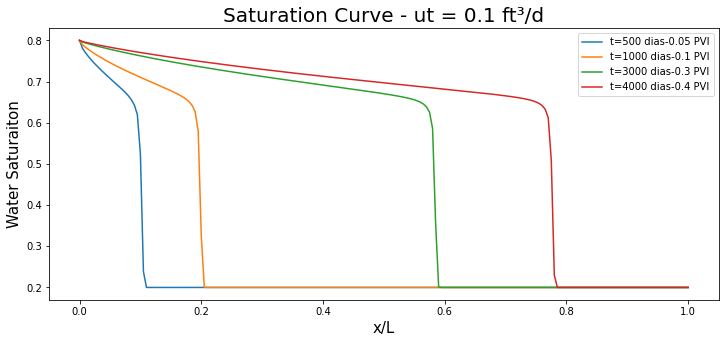

In [ ]:
#plotting the saturation curves - SPU
finitedifference.saturation_curve()

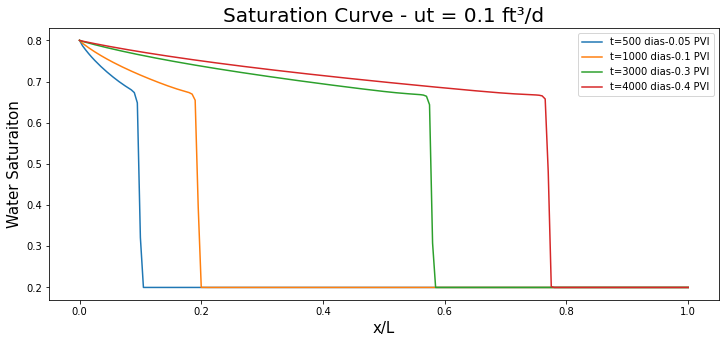

In [ ]:
#plotting the saturation curves - TVD
finitedifference4.saturation_curve()

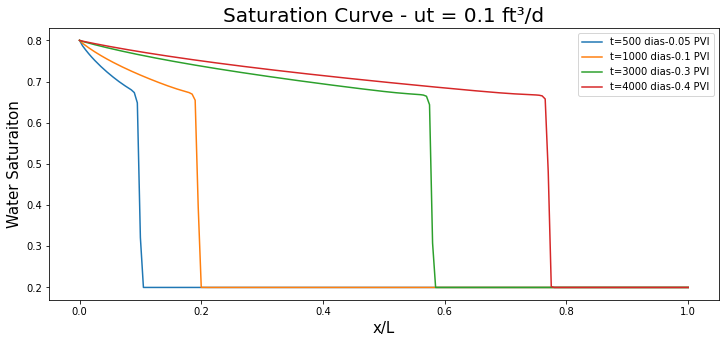

In [ ]:
#plotting the saturation curves - TVD
finitedifference4.saturation_curve()

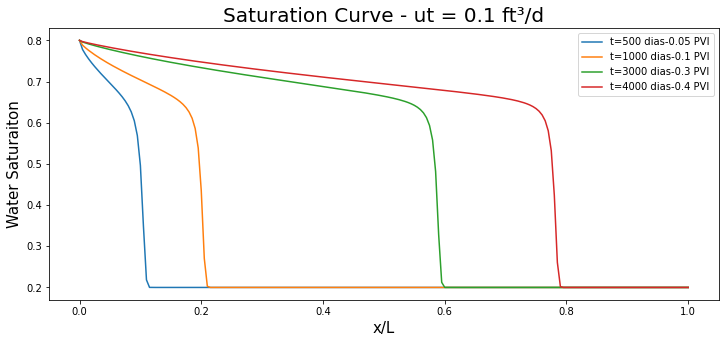

In [ ]:
#plotting the saturation curves - Implicitly SPU
finitedifference2.saturation_curve()

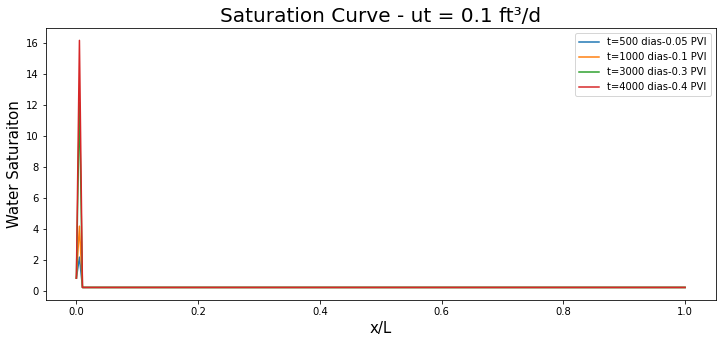

In [ ]:
finitedifference3.saturation_curve()

In [ ]:
imp_spu[1]

array([0.37776066, 0.22203436, 0.20020496, 0.20000002, 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2    

## Alternative Implicit Method

In [ ]:
def residual_function(sw_i, sw_i_minus_one=0.2, sw_n=0.2):
    "Private function that creates the residual equations in a generic form."
    alpha0  = domain.courant()
    mi = medium.ovis/medium.wvis*perm.krw_sor
    swi = perm.swi
    sor = perm.sor
    nw = perm.nw
    no = perm.no
    aw = (1-swi-sor)**nw 
    a0 = (1-swi-sor)**no 
    d =  perm.kro_swi
    sw_cc = blmodel.sw_cc
    sw_ci = blmodel.sw_ci
    
    return sw_i + (alpha0*mi*(sw_i - swi)**nw)/((mi*(sw_i-swi)**nw)/aw + d*(1-sor-sw_i)/a0)*(1/aw) - (alpha0*mi*(sw_i_minus_one - swi)**nw)/((mi*(sw_i_minus_one-swi)**nw)/aw + d*(1-sor-sw_i_minus_one)/a0)*(1/aw) - sw_n


def new_residual_matrix(n, estimation):
    "It creates a matrix with the residual equations at a specific point, which is used by the Newton-Raphson method."
    zero_matrix = np.zeros(domain.nx)

    for i in range(domain.nx-1):
      if i == 0:
        zero_matrix[i] = residual_function(saturation[n,i], blmodel.sw_cc, saturation[n,i])
      else:
        zero_matrix[i] = residual_function(saturation[n,i], saturation[n,i-1], saturation[n,i])
    return zero_matrix

In [ ]:
saturation[0,:] = blmodel.sw_ci
teste5 = residual_matrix(0, saturation[0])

In [ ]:
 def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(sw_i):
        args[var] = sw_i
        return func(*args)
    return derivative(wraps, point[var], dx = 1e-6)

def new_jacobian_matrix(estimation):
  "Private function that creates the jacobian matrix, which is used by the Newton-Raphson method."
  zero_jacobian_matrix = np.zeros((saturation.shape[1],saturation.shape[1]))
    
  for i in range(domain.nx-1):
    for j in range(domain.nx-1):
      if (i == j) and (i == 0):
        # first point
        zero_jacobian_matrix[i,j] = derivative(residual_function, estimation[j], dx = 1e-6)
      elif (i == j):
        # this point is replaced by a current saturation point
        zero_jacobian_matrix[i,j] = partial_derivative(residual_function, 0, point = [estimation[j],estimation[j-1],estimation[j]])
      elif (i == j+1):
        # this point is replaced by a previous saturation point
        zero_jacobian_matrix[i,j] = partial_derivative(residual_function, 1, point = [estimation[j],estimation[j-1],estimation[j]]) 
      else:
        pass

  return zero_jacobian_matrix

In [ ]:
teste6 = jacobian_matrix(saturation[0])

In [ ]:
teste6

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def newton_raphson(n, x_init, max_ite=1000, tol=10**-6):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    max_iteration = max_ite
    epsilon = tol

    xnew = x_init
    for k in range(max_iteration):
      J = jacobian_matrix(xnew)
      r = new_residual_matrix(n, xnew)
      delta = np.linalg.solve(J,-r)
      xnew = xnew + delta

      if np.linalg.norm(delta) < epsilon:
        #print("The system converges at k={}, and the solution are {}".format(k, xnew))
        break
      else:
        print("The solution does not converge! Try increasing the iterations.")
    
    return xnew

In [ ]:
teste7 = newton_raphson(0, saturation[0])

In [ ]:
det = np.linalg.det(teste6)
print(det)

0.0


In [ ]:
#one root newton-raphson method

def newton_raphson1(n, i, x_init, max_ite=1000, tol=10**-6):
    "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear system of equations"
    max_iteration = max_ite
    epsilon = tol

    x,b = x_init
    for k in range(max_iteration):
      xnew = x - residual_function(x, b, saturation[n,i])/derivative(residual_function, x, dx = 1e-6)
      
      if abs(xnew-x) < epsilon:
        #print("The system converges at k={}, and the solution are {}".format(k, xnew))
        break
      elif k == max_ite-1:
        print("The solution does not converge! Try increasing the iterations.")
        break
      else:
        x = xnew
         
    return xnew

In [ ]:
xini = np.array([0.2, 0.8])
teste8 = newton_raphson1(0, 0, xini)

The system converges at k=2, and the solution are 0.2993095907007573


In [ ]:
teste9 = newton_raphson1(0, 1, [0.2,teste8])

The system converges at k=1, and the solution are 0.20069038123011573


In [ ]:
teste10 = newton_raphson1(0, 2, [0.2,teste9])

The system converges at k=0, and the solution are 0.20000002806912728


In [ ]:
def solver():
    "Function that implicitly solves the model."
    t1 = timeit.default_timer()
    start = t1
    
    for n in blmodel.transition_time_matrix():
      if n == 0:
        saturation[0,:] = blmodel.sw_ci
      else: 
        x_init = saturation[n-1]
        for i in range(domain.nx):
          if i == 0:
            x_init_2 = np.array([x_init[i], blmodel.sw_cc])
            saturation[n,i] = newton_raphson1(n-1, i, x_init_2)
            x_aux = saturation[n,i]
          else:
            x_init_2 = np.array([x_init[i], x_aux])
            saturation[n,i] = newton_raphson1(n-1, i, x_init_2)
            x_aux = saturation[n,i]
         

    t2 = timeit.default_timer()
    stop = t2
    
    return saturation  

In [ ]:
#saturation[0,:] = blmodel.sw_ci
teste11 = solver()

In [ ]:
teste11.shape

(400, 100)

In [ ]:
  def saturation_curve(teste11):
    "Function that plots the saturation curves."
    matrix = teste11
    
    matrix = np.insert(matrix, 0, values = blmodel.sw_cc, axis=1) 
    length_vector = np.linspace(0, 1, domain.nx+1)
    fig = plt.figure(figsize=(8,5))
    ax = plt.subplot(1,1,1)

    #PVI calculations
    td_label_1= domain.grid_dt(500)
    td_label_2= domain.grid_dt(1000)
    td_label_3= domain.grid_dt(3000)
    td_label_4= domain.grid_dt(4000)


    ax.plot(length_vector, matrix[49], label = "t=360 dias-{} PVI".format(td_label_1))
    ax.plot(length_vector, matrix[99], label = "t=730 dias-{} PVI".format(td_label_2))
    ax.plot(length_vector, matrix[299], label = "t=1090 dias-{} PVI".format(td_label_3))
    ax.plot(length_vector, matrix[399], label = "t=1820 dias-{} PVI".format(td_label_4))

    ax.set_xlabel("x/L", fontsize=15)
    ax.set_ylabel("Saturação da água", fontsize=15)
    plt.title("Curva de Saturação implicita - ut = {} ft³/d".format(medium.ut), fontsize=20)
    ax.legend(loc="upper right")
    plt.show()

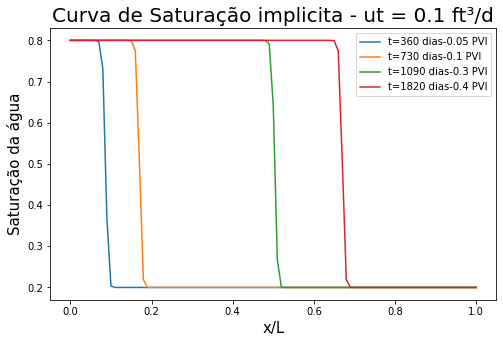

In [ ]:
saturation_curve(teste11)

###  Implicitly TVD

In [ ]:
def func(x):
  def func2(x):
    return x**5
  return x**2+x**3+func2(x)

In [ ]:
derivative(func, 5, dx=1e-6)

3210.0000005357288

In [ ]:
def func3(x):
  return x**2+x**3+x**5


In [ ]:
derivative(func3, 5, dx=1e-6)

3210.0000005357288

In [ ]:
x_init = saturation[0]
np.array([x_init[0], blmodel.sw_cc, x_init[0+1]])

In [ ]:
teste30 = []
for i in range(domain.nx):
  teste30.append(i)

In [ ]:
teste30[-1]

In [ ]:
def mobility(sw):
  "function that calculates the mobility between interblocks."
  
  numerator = perm.water_kr(sw)/medium.wvis
  denominator = perm.water_kr(sw)/medium.wvis + perm.oil_kr(sw)/medium.ovis
  
  return numerator/denominator

def limiter_function(sw_i,sw_i_plus_one,sw_i_minus_one):
  "function that calculates the limiter function."
  numerator = mobility(sw_i) - mobility(sw_i_minus_one)
  denumerator = mobility(sw_i_plus_one) - mobility(sw_i)
  if denumerator == 0:
    r = 1
  else:
    r = numerator/denumerator
  return r 

def van_leer(r):
  "function that calculates the van leer parameter."
  #if r == 1:
    #fi = 0
  #else:
  fi = (r+abs(r))/(1+abs(r))
  return fi

def flow_adjustment(sw_one, sw_two, r):
  "function that calculates the flow correction."
  flow_adjustment_function = van_leer(r)/2*(mobility(sw_one) - mobility(sw_two))*(1-domain.courant())
  return flow_adjustment_function


In [ ]:
v1 = 0.2
v2 = 0.2
v3 = 0.2
v4 = 0.2
def residual_function2(sw_i, sw_i_plus_one=v1, sw_i_minus_one=v2, sw_i_minus_half=v3, sw_n=v4):
  #properties salve in memory for the purpose to use in the derivative.

  limiter = limiter_function(sw_i, sw_i_plus_one, sw_i_minus_one)
  sw_i_plus_half = mobility(sw_i) + flow_adjustment(sw_i_plus_one,sw_i, limiter)

  return sw_i + domain.courant()*(sw_i_plus_half - sw_i_minus_half) - sw_n

In [ ]:
x_init = [0.2, 0.2, blmodel.sw_cc, blmodel.sw_cc, 0.2]
saturation[0] = blmodel.sw_ci
#limiter = limiter_function(x_init[0], x_init[1], x_init[2])
#sw_i_plus_half = mobility(x_init[0]) + flow_adjustment(x_init[1], x_init[0], limiter)
#residual_function2(x_init[0], x_init[1], x_init[2], x_init[3], x_init[4])

In [ ]:
def newton_raphson2(n, i, x_init, max_ite=1000, tol=10**-6):
  "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear equations"
  x,b,c = x_init   
  
  for k in range(max_ite):
    if i == 0:
      sw_i_minus_half = blmodel.sw_cc
    else:
      limiter = limiter_function(x_init[0], x_init[2], x_init[1])
      sw_i_minus_half = mobility(x_init[0]) + flow_adjustment(x_init[2], x_init[0], limiter) 
          
    numerator = residual_function2(x, c, b, sw_i_minus_half, saturation[n,i])
    v1 = c
    v2 = b
    v3 = sw_i_minus_half
    v4 = saturation[n,i]
    denumerator = derivative(residual_function2, x, dx = 1e-6)
    
    xnew = x - (numerator/denumerator) 

          
    if abs(xnew-x) < tol:
      break
    elif k == max_ite-1:
      print("The solution does not converge! Try increasing the iterations.")
      break
    else:
      x = xnew

  return xnew, numerator

In [ ]:
x_init_1 = np.array([0.2, blmodel.sw_cc, 0.2])
newton_raphson2(0,0, x_init_1)

In [ ]:
limiter = limiter_function(x_init_1[0], x_init_1[2], x_init_1[1])
limiter

In [ ]:
v1 = 0.2
v2 = 0.2

def residual_function(sw_i, sw_i_minus_one = v1, sw_n = v2):
    "Private function that creates the residual equations in a generic form."
    A = domain.courant()*perm.krw_sor
    B = perm.krw_sor
    C = ((1-perm.swi)**perm.nw)/((1-perm.swi)**perm.no)*perm.kro_swi
    sw_cc = blmodel.sw_cc
    sw_ci = blmodel.sw_ci
   
    
    return sw_i + [(A*(sw_i - perm.swi)**perm.nw)/((B*(sw_i-perm.swi)**perm.nw) + C*((1-perm.sor-sw_i)**perm.no))] - [(A*(sw_i_minus_one - perm.swi)**perm.nw)/((B*(sw_i_minus_one-perm.swi)**perm.nw) + C*((1-perm.sor-sw_i_minus_one)**perm.no))] - sw_n
def newton_raphson3(n, i, x_init, max_ite=1000, tol=10**-6):
  "Function that applies the Newton-Raphson method to implicitly calculate the nonlinear equations"
  x,b,c = x_init
  for k in range(max_ite):
    numerator = residual_function(x, b, saturation[n,i])
    v1 = b
    v2 = saturation[n,i]
    xnew = x - numerator/derivative(residual_function, x, dx = 1e-6)
          
    if abs(xnew-x) < tol:
      break
    elif k == max_ite-1:
      print("The solution does not converge! Try increasing the iterations.")
      break
    else:
      x = xnew
  return xnew

In [ ]:
x_init_1 = np.array([0.2, blmodel.sw_cc, 0.2])
newton_raphson3(0,0, x_init_1)

## Validation

### Analytic solution

In [ ]:
#Discretização do domínio 
nx = 200                                                               #Número de pontos do grid
dominio = np.arange(nx)                                                #vetor domínio

#Calculo de Delta X
#tamanho do meio poroso
tam_meio_poroso = 5000 #ft
#tamanho do elemento do grid
tam_grid = tam_meio_poroso/nx
#Delta X - normalizado
dx = tam_grid/tam_meio_poroso


In [ ]:
#Calculo de Delta T
#viscosidade da água 
visc_agua = 1 #cp
#viscosidade do óleo
visc_oleo = 3 #cp
#velocidade total na injeção 
ut = 0.1 #ft/d 
#porosidade
porosidade_meio = 0.2
#tempo de simulação 
nt = 4000 #dias
#passo de tempo
passo_tempo = 10 #dias
#Delta T - normalizado
dt =  ut*passo_tempo/(tam_meio_poroso*porosidade_meio) 

#Número de Courant
num_Courant = dt/dx #verificar velocidade 


In [ ]:
#Número de Courant
num_Courant = dt/dx #verificar velocidade 
print(f"O número de courant é {num_Courant}")

O número de courant é 0.2


In [ ]:
#Características do sistema molhável a água
#saturação inicial
swi = 0.2
#saturação de óleo residual
sor = 0.2
#permeabilidade relativa da água na saturação residual
krw_sor = 0.35 
#permeabilidade relativa do óleo na saturação residual
kro_swi = 0.85 
#porosidade
porosidade = porosidade_meio
#parâmetros de Corey
no = 2
nw = 2

#condição de contorno e inicial
#Condição Inicial Sw(X,0)
sw_CI = swi
#Condição de Contorno Sw(0,T)
sw_CC = 1-sor
#Matriz de saturação para alocação dos resultados
tempos_de_injecao = int(nt/passo_tempo)   #quantidade representando os tempos de injeção que serão calculados
matriz_resultado_saturacao = np.zeros((tempos_de_injecao,nx)) 
#matriz_resultado_saturacao.shape 
#modificando a primeira linha da matriz para alocar os valores das condições iniciais
matriz_resultado_saturacao[0,:] = sw_CI 
tempos_de_injecao = np.arange(tempos_de_injecao)

#Definição do vetor de saturação 
dx_pontos_saturacao = 0.0001
vetor_saturacao = np.arange(swi,1-sor,dx_pontos_saturacao)


In [ ]:
#função para o cálculo do modelo Corey - AJUSTADO

def perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw):
  kro = []
  krw = []

  if isinstance(sw, Iterable):
    #cálculo da permeabilidade relativa do óleo 
    for i in sw:
        kr = kro_swi*((1-sor-i)/(1-swi-sor))**no
        kro.append(kr)
    kro = np.array([kro_swi if i >= 1 else i for i in kro]) #substituindo o valor 1 por kro_swi
    kro[-1] = 0.0 # solução temporária para o erro 

    #cálculo da permeabilidade relativa da água
    for i in sw:
        kr = krw_sor*((i-swi)/(1-swi-sor))**nw
        if kr > krw_sor:
          kr = krw_sor
        krw.append(kr)
    krw = np.array(krw)

  else:
    #cálculo da permeabilidade relativa do óleo
    kr = kro_swi*((1-sor-sw)/(1-swi-sor))**no
    if kr > kro_swi:
      kr = kro_swi
    kro.append(kr)
    kro = np.array(kro) 
    #cálculo da permeabilidade relativa da água 
    kr = krw_sor*((sw-swi)/(1-swi-sor))**nw
    if kr > krw_sor:
      kr = krw_sor
    krw.append(kr)
    krw = np.array(krw)
  
  return kro, krw

#função que calcula a mobilidade em diferentes pontos de saturação
def mobilidade(sw,visc_agua,visc_oleo):

  numerador_da_funcao = perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[1]/visc_agua
  denominador_da_funcao = (perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[1]/visc_agua) + (perm_corey(sw,swi,sor,kro_swi,krw_sor,no,nw)[0]/visc_oleo)
  resultado_mobilidade =  numerador_da_funcao/denominador_da_funcao

  return resultado_mobilidade

In [ ]:
#Cálculo das permeabilidades relativas
kro, krw = perm_corey(vetor_saturacao,swi,sor,kro_swi,krw_sor,no,nw)

In [ ]:
#Cálculo dos fluxos fracionários
fw = []
vetor = np.arange(vetor_saturacao.shape[0])
for i in vetor:
  fw.append(mobilidade(vetor_saturacao[i],visc_agua, visc_oleo))

In [ ]:
#cálculo da derivada de fw
#numericamente

dfw = [np.array(0)]
for i in range(len(fw)-1):
  dfw.append((fw[i+1]-fw[i])/(vetor_saturacao[i+1]-vetor_saturacao[i]))

In [ ]:
#Cálculo de x adimensional
td = ut*3000/(porosidade_meio*tam_meio_poroso)
xd = []
for i in range(len(dfw)):
  xd.append(td*dfw[i]) 

In [ ]:
#determinando o valor de xd
# dfw = fwf/(swf-swi)

dfw_swf = []
for i,j in zip(vetor_saturacao,fw):
  if (i-swi) == 0:
    dfw_swf.append(0)
  else:
    dfw_swf.append(j/(i-swi))

vetor_aux = []
vetor_index = []
i=0
for k,z in zip(dfw_swf,dfw):
  aux = z - k
  if aux <= 10**-5:
    vetor_index.append(i)
  else:
    vetor_aux.append(z - k)
  i = i+1


In [ ]:
xdf = td*dfw[vetor_index[2]]
swf = vetor_saturacao[vetor_index[2]]
fwf = fw[vetor_index[2]]
print("A saturação da região frontal é {}, o xdf é {} e o fwf é {}".format(swf, xdf[0],fwf[0]))

A saturação da região frontal é 0.6013999999999557, o xdf é 0.6236017983803487 e o fwf é 0.8346075477132396


In [ ]:
#Construção da curva de saturação com a descontinuidade
xd_rest = np.linspace(1,xdf,tam_restante_xd) #Faz se necessário rodar a primeira vez sem essa linha para determinar o tamanho do array
xd2 = []

for i in xd_rest:   #Faz se necessário rodar a primeira vez sem esse loop para determinar o tamanho do array
  xd2.append(i)

vetor_saturacao2 = []
for i,j in zip(vetor_saturacao,dfw):
  if i > swf:
    xd2.append(td*j)
    vetor_saturacao2.append(i)

  else:
    vetor_saturacao2.append(swi)
    

#Na primeira vez rodar essa linha em sequencia com o kernel anterior
#para determinar o tamanho do array
tam_restante_xd = len(xd)-len(xd2) #na segunda vez, comentar essa linha 


### Validation Curves

#### Explicit validation

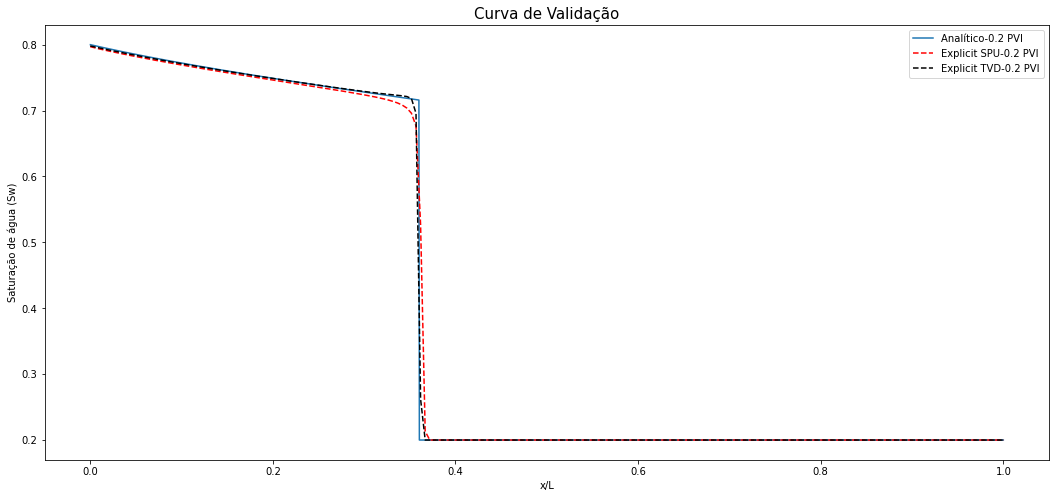

In [ ]:
vetor_comprimento = np.linspace(0, 1, domain.nx)
exp_spu_validation = finitedifference.get_matrix()
exp_tvd_validation = finitedifference4.get_matrix()

#Models validation
fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1,1,1)
#ax2 = plt.subplot(1,2,2)

#Validation curve
ax1.plot(xd2,vetor_saturacao2,  label = 'Analítico-{} PVI'.format(td))
ax1.plot(vetor_comprimento, exp_spu_validation[199],'r--', label = "Explicit SPU-{} PVI".format(td))
ax1.plot(vetor_comprimento, exp_tvd_validation[199], 'k--' , label = "Explicit TVD-{} PVI".format(td))

ax1.set_title("Curva de Validação", fontsize=15)
ax1.set_xlabel("x/L", fontsize=10)
ax1.set_ylabel("Saturação de água (Sw)",fontsize=10)

ax1.legend()
plt.show()

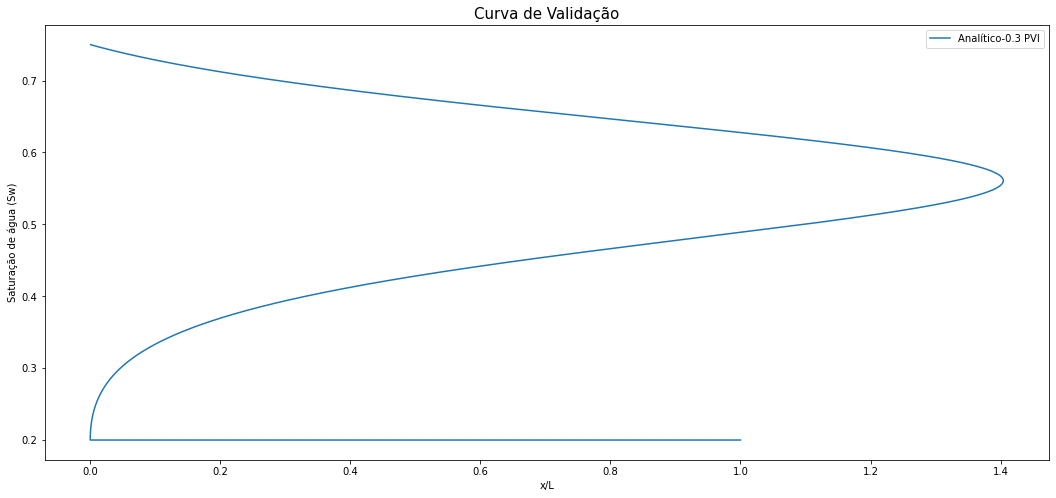

In [ ]:
vetor_comprimento = np.linspace(0, 1, domain.nx)
#exp_spu_validation = finitedifference.get_matrix()
#exp_tvd_validation = finitedifference4.get_matrix()

#Models validation
fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1,1,1)
#ax2 = plt.subplot(1,2,2)

#Validation curve
ax1.plot(xd2,vetor_saturacao2,  label = 'Analítico-{} PVI'.format(td))
#ax1.plot(vetor_comprimento, exp_spu_validation[199],'r--', label = "Explicit SPU-{} PVI".format(td))
#ax1.plot(vetor_comprimento, exp_tvd_validation[199], 'k--' , label = "Explicit TVD-{} PVI".format(td))

ax1.set_title("Curva de Validação", fontsize=15)
ax1.set_xlabel("x/L", fontsize=10)
ax1.set_ylabel("Saturação de água (Sw)",fontsize=10)

ax1.legend()
plt.show()

#### Implicit validation

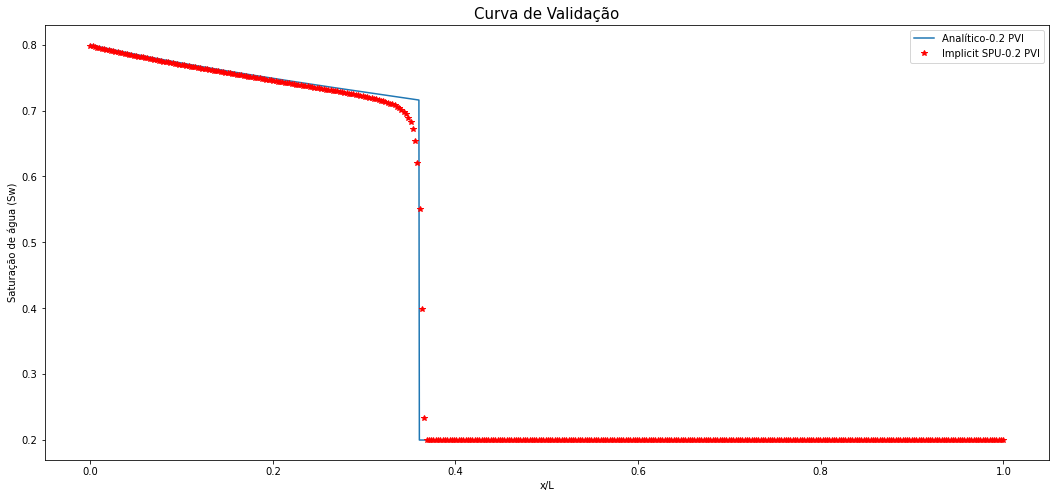

In [ ]:
vetor_comprimento = np.linspace(0, 1, domain.nx)
imp_spu_validation = finitedifference2.get_matrix()

#Models validation
fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1,1,1)
#ax2 = plt.subplot(1,2,2)

#Validation curve
ax1.plot(xd2,vetor_saturacao2,  label = 'Analítico-{} PVI'.format(td))
ax1.plot(vetor_comprimento, imp_spu_validation[199],'r--', label = "Implicit SPU-{} PVI".format(td))
#ax1.plot(vetor_comprimento, exp_tvd_validation[199], 'k--' , label = "Upstream-{} PVI".format(td))

ax1.set_title("Curva de Validação", fontsize=15)
ax1.set_xlabel("x/L", fontsize=10)
ax1.set_ylabel("Saturação de água (Sw)",fontsize=10)

ax1.legend()
plt.show()

#### Implicit and Explicit validation

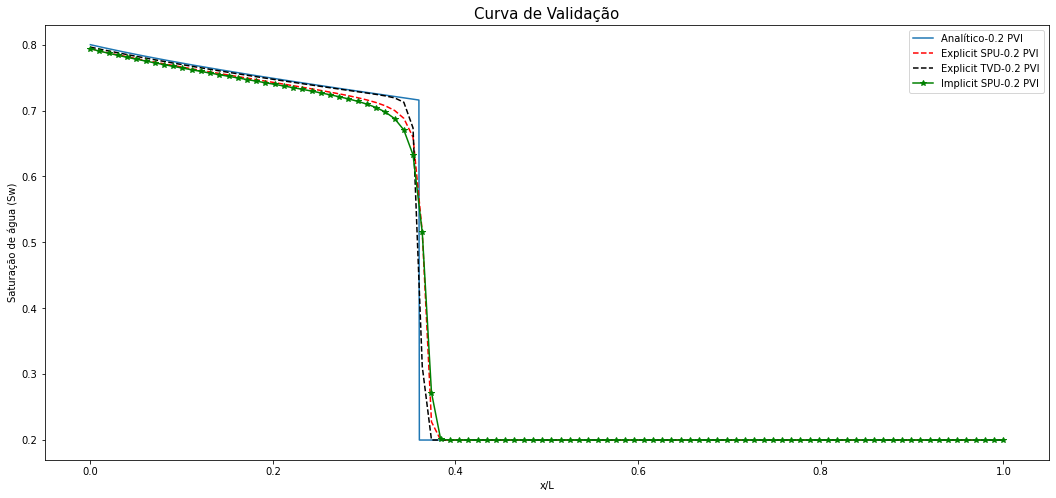

In [ ]:
vetor_comprimento = np.linspace(0, 1, nx)
exp_spu_validation = finitedifference.get_matrix()
exp_tvd_validation = finitedifference4.get_matrix()
imp_spu_validation = finitedifference2.get_matrix()

#Models validation
fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1,1,1)
#ax2 = plt.subplot(1,2,2)

#Validation curve
ax1.plot(xd2,vetor_saturacao2,  label = 'Analítico-{} PVI'.format(td))
ax1.plot(vetor_comprimento, exp_spu_validation[199],'r--', label = "Explicit SPU-{} PVI".format(td))
ax1.plot(vetor_comprimento, exp_tvd_validation[199], 'k--' , label = "Explicit TVD-{} PVI".format(td))
ax1.plot(vetor_comprimento, imp_spu_validation[199], color='g', marker = '*', linestyle='solid', label = "Implicit SPU-{} PVI".format(td))

ax1.set_title("Curva de Validação", fontsize=15)
ax1.set_xlabel("x/L", fontsize=10)
ax1.set_ylabel("Saturação de água (Sw)",fontsize=10)

ax1.legend()
plt.show()

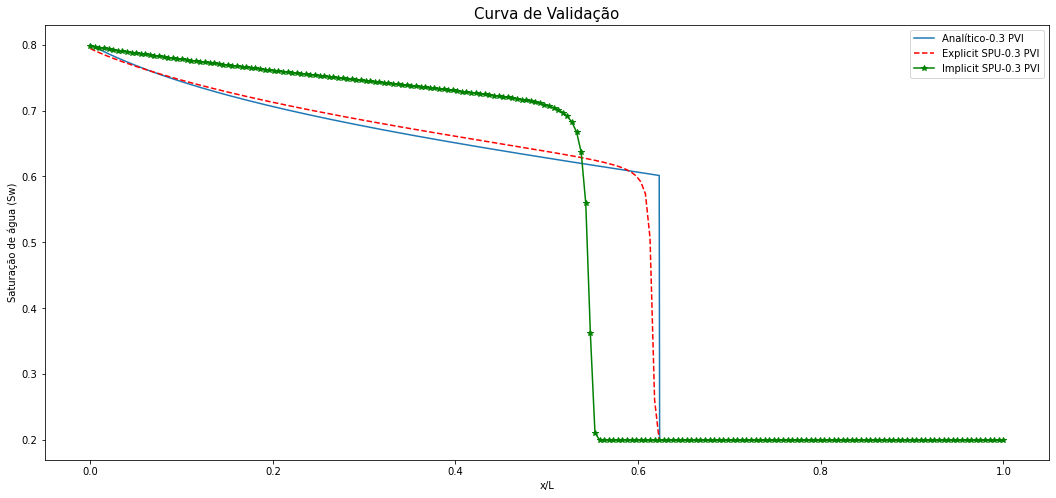

In [ ]:
vetor_comprimento = np.linspace(0, 1, domain.nx)
#Models validation
fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot(1,1,1)
#ax2 = plt.subplot(1,2,2)

#Validation curve
ax1.plot(xd2,vetor_saturacao2,  label = 'Analítico-{} PVI'.format(td))
ax1.plot(vetor_comprimento, exp_spu[299],'r--', label = "Explicit SPU-{} PVI".format(td))
#ax1.plot(vetor_comprimento, exp_tvd_validation[199], 'k--' , label = "Explicit TVD-{} PVI".format(td))
ax1.plot(vetor_comprimento, imp_spu[299], color='g', marker = '*', linestyle='solid', label = "Implicit SPU-{} PVI".format(td))

ax1.set_title("Curva de Validação", fontsize=15)
ax1.set_xlabel("x/L", fontsize=10)
ax1.set_ylabel("Saturação de água (Sw)",fontsize=10)

ax1.legend()
plt.show()

## Salting-in Mechanism 

### Limits

#### Al-Ibadi

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.2, 0.25, 3, 2, 0.5, 0.99)
ls_perm = CoreyModel(0.2, 0.081, 3, 2, 0.375, 0.99)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.2,0.75, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.2,0.919, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
finitedifference7 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain)
#Creating the object that represents the chosen approach - TVD
finitedifference8 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain)

In [ ]:
#Calculation of saturation matrix
finitedifference7.solver()
hs_matrix = finitedifference7.get_matrix()
#Calculation of saturation matrix
finitedifference8.solver()

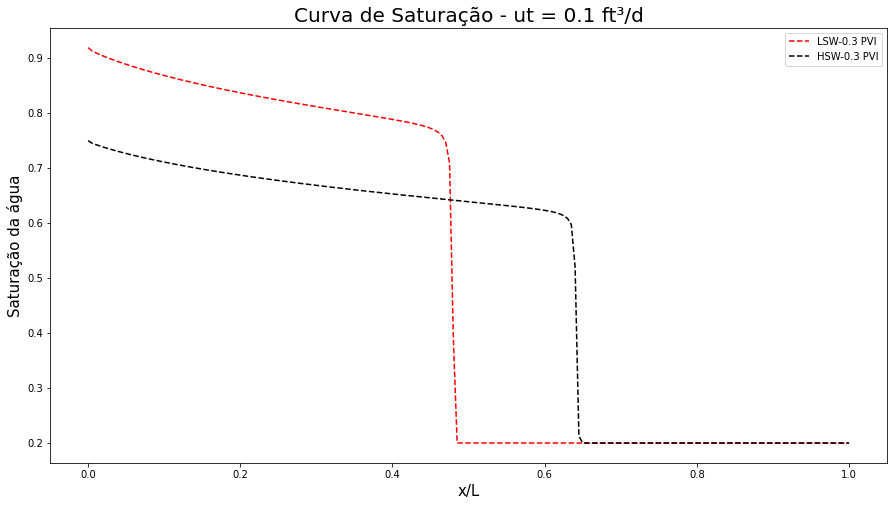

In [ ]:
finitedifference8.saturation_curve_comparision(hs_blmodel,hs_matrix, 3000, "LSW", "HSW")

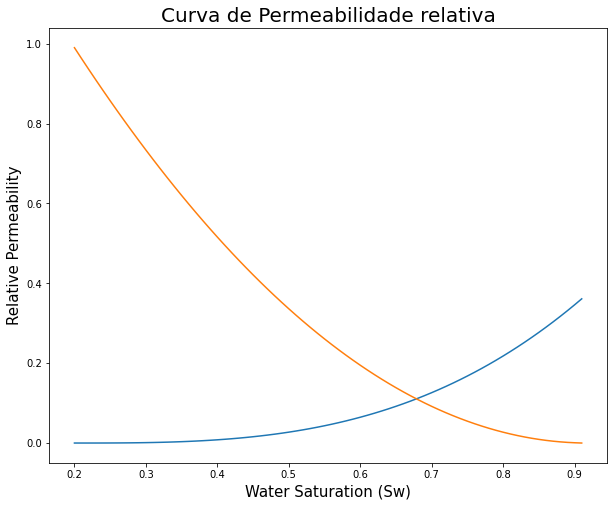

In [ ]:
ls_perm.relative_permeability_curves()

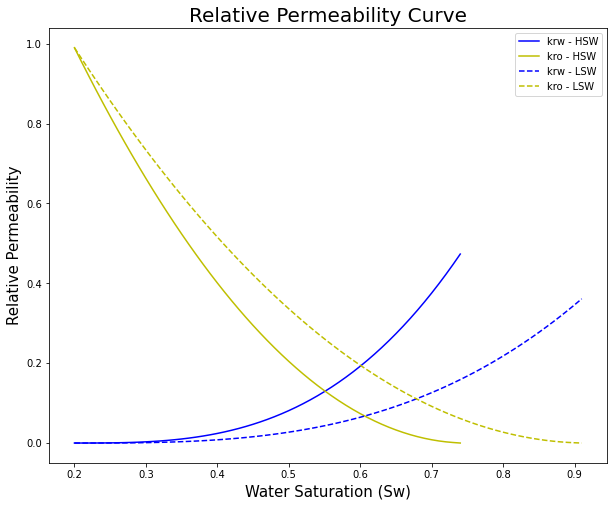

In [ ]:
#relative permeability curves
hs_perm.curves_comparision(ls_perm,'HSW','LSW')

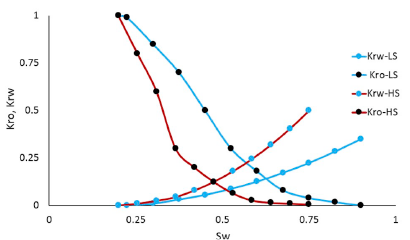

#### Rivet

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 8, 0.37, 0.1) #the viscosities were modified 
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.362, 0.284, 4, 3, 0.038, 0.296)
ls_perm = CoreyModel(0.397, 0.222, 4, 3, 0.031, 0.322)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.362,0.716, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.397,0.778, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
finitedifference9 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain)
#finitedifference9 = ImplicitMethod(domain, hs_perm, hs_spu, hs_saturation, hs_blmodel)
#Creating the object that represents the chosen approach - TVD
finitedifference10 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain)
#finitedifference10 = ImplicitMethod(domain, ls_perm, ls_spu, ls_saturation, ls_blmodel)

In [ ]:
#Calculation of saturation matrix
finitedifference9.solver()
#finitedifference9.solver2()
hs_matrix = finitedifference9.get_matrix()

#Calculation of saturation matrix
finitedifference10.solver()

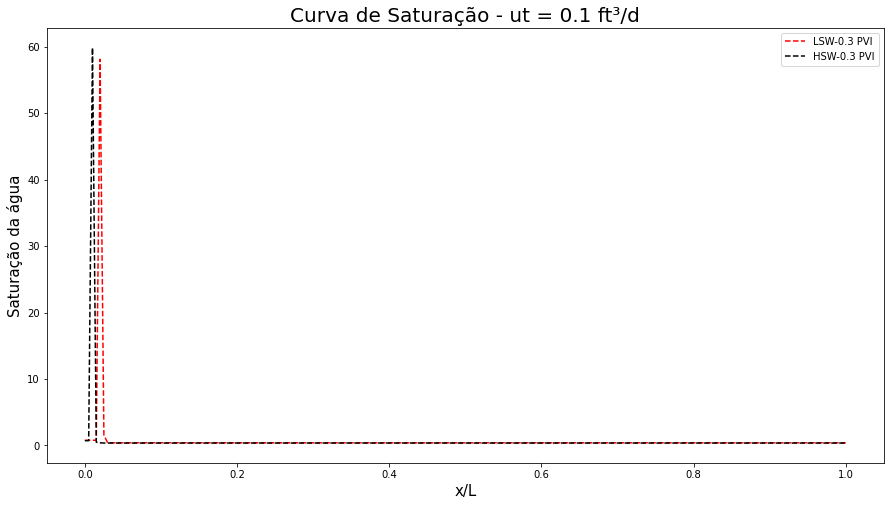

In [ ]:
finitedifference10.saturation_curve_comparision(hs_blmodel, hs_matrix, 3000, "LSW", "HSW") #The plot shows this shape due to the high difference between the viscosities

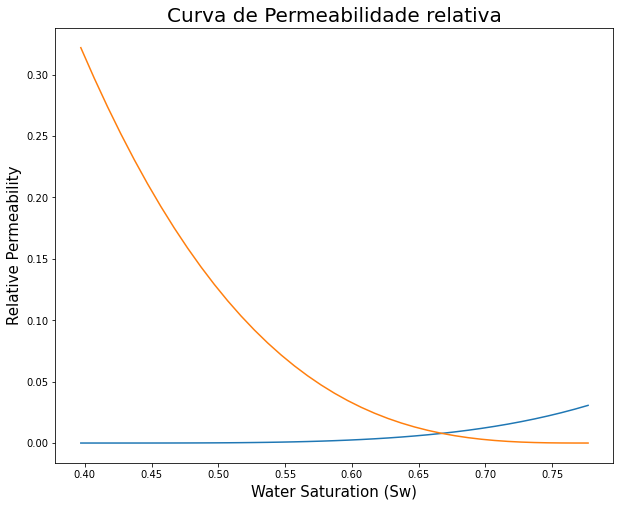

In [ ]:
#Relative permeability curve of low salinity water
ls_perm.relative_permeability_curves()

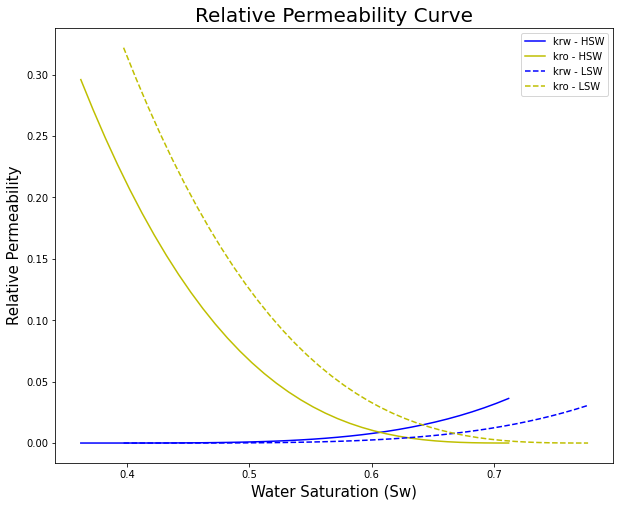

In [ ]:
#relative permeability curves
hs_perm.curves_comparision(ls_perm,'HSW','LSW')

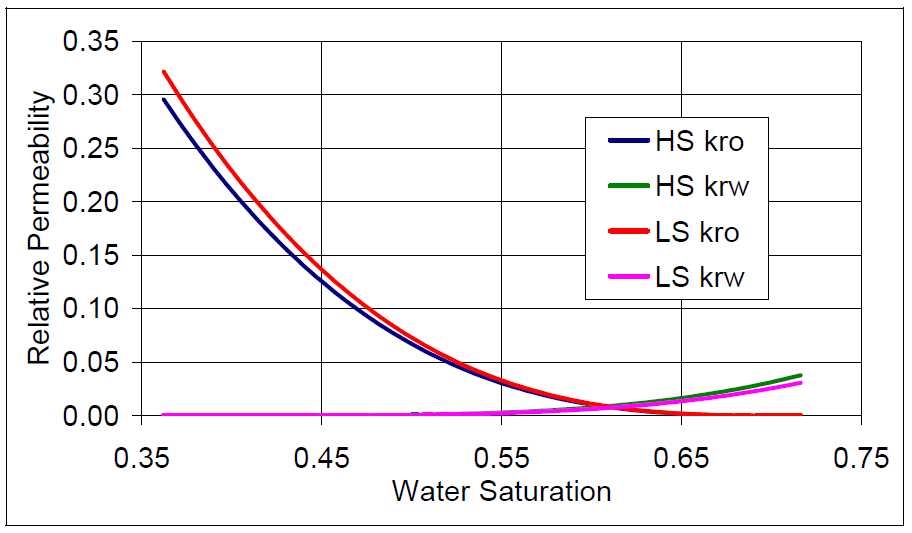

#### Fjelde

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1.5, 0.36, 0.05) #the viscosities were modified 
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.294, 0.245, 3, 4, 0.0436, 0.9)
ls_perm = CoreyModel(0.32, 0.216, 3, 4, 0.0436, 0.932)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.294,0.755, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.32,0.784, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
finitedifference11 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain)
#finitedifference9 = ImplicitMethod(domain, hs_perm, hs_spu, hs_saturation, hs_blmodel)
#Creating the object that represents the chosen approach - TVD
finitedifference12 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain)
#finitedifference10 = ImplicitMethod(domain, ls_perm, ls_spu, ls_saturation, ls_blmodel)

In [ ]:
#Calculation of saturation matrix
finitedifference11.solver()
#finitedifference11.solver2()
hs_matrix = finitedifference11.get_matrix()

#Calculation of saturation matrix
finitedifference12.solver()

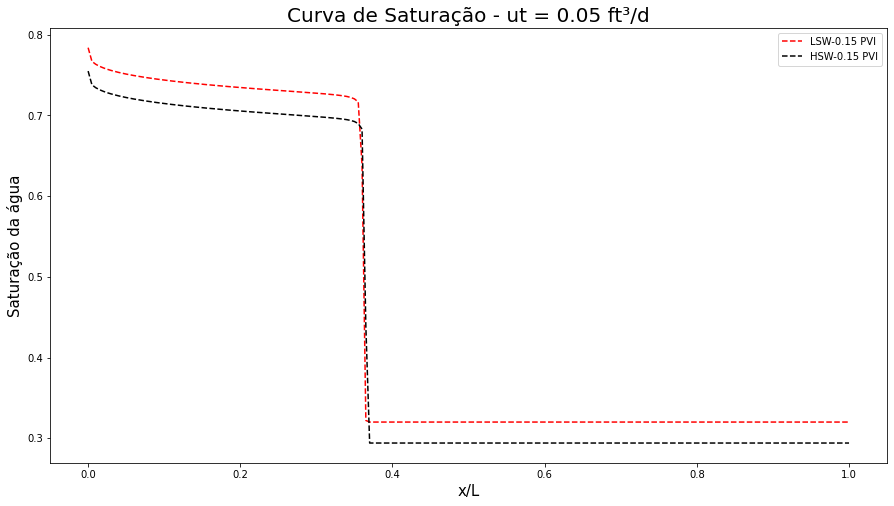

In [ ]:
finitedifference12.saturation_curve_comparision(hs_blmodel, hs_matrix, 3000, "LSW", "HSW")

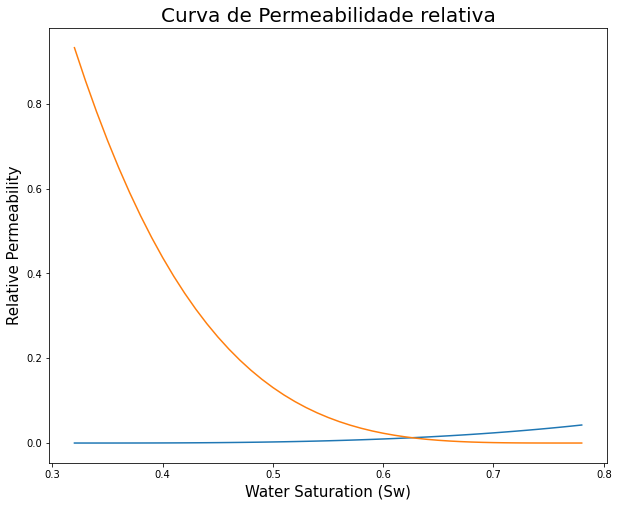

In [ ]:
#Relative permeability curve of low salinity water
ls_perm.relative_permeability_curves()

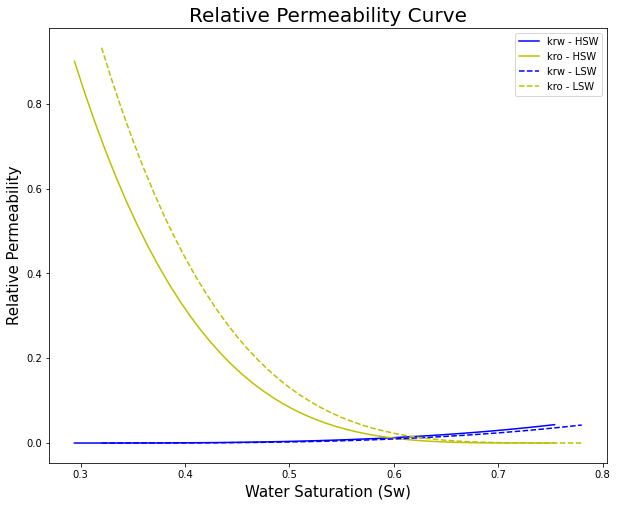

In [ ]:
#relative permeability curves
hs_perm.curves_comparision(ls_perm,'HSW','LSW')

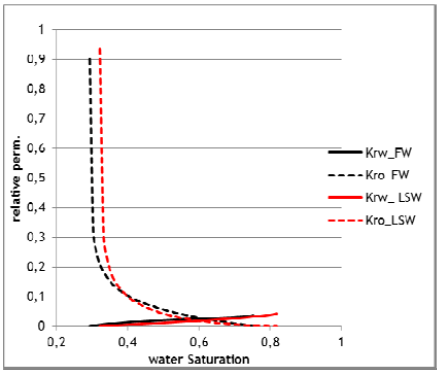

#### Omekeh

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 0.3, 0.6, 0.1) #the viscosities were modified 
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.15, 0.3, 3, 2, 0.3, 0.75)
ls_perm = CoreyModel(0.15, 0.15, 3, 2, 0.4, 0.9)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.15,0.7, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.15,0.85, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
finitedifference13 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain)
#finitedifference9 = ImplicitMethod(domain, hs_perm, hs_spu, hs_saturation, hs_blmodel)
#Creating the object that represents the chosen approach - TVD
finitedifference14 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain)
#finitedifference10 = ImplicitMethod(domain, ls_perm, ls_spu, ls_saturation, ls_blmodel)

In [ ]:
#Calculation of saturation matrix
finitedifference13.solver()
#finitedifference13.solver2()
hs_matrix = finitedifference13.get_matrix()

#Calculation of saturation matrix
finitedifference14.solver()

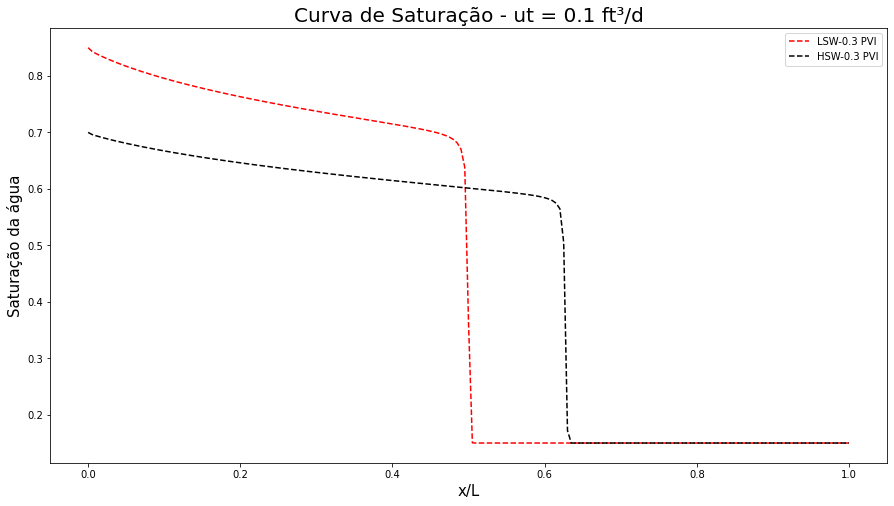

In [ ]:
finitedifference14.saturation_curve_comparision(hs_blmodel, hs_matrix, 3000, "LSW", "HSW")

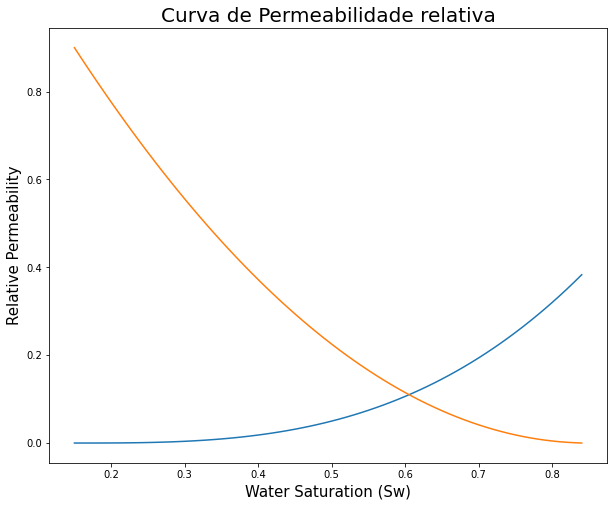

In [ ]:
#Relative permeability curve of low salinity water
ls_perm.relative_permeability_curves()

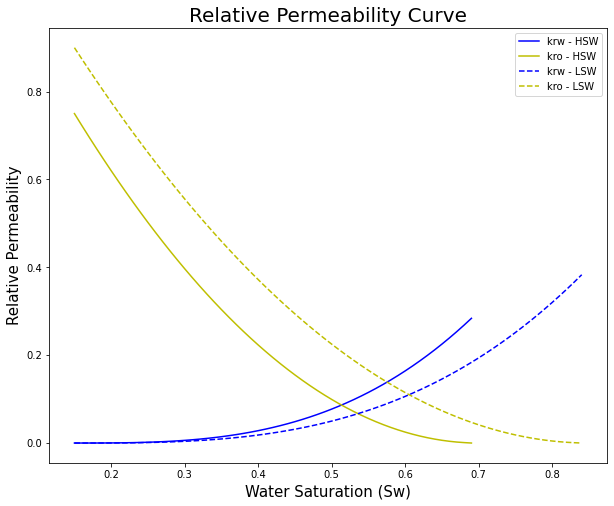

In [ ]:
#relative permeability curves
hs_perm.curves_comparision(ls_perm,'HSW','LSW')

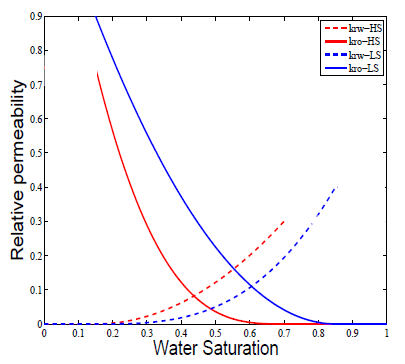

#### Xie

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.123, 1, 2, 0.1) #the porosity was modified
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.322, 0.412, 3.1, 5.2, 0.35, 0.99)
ls_perm = CoreyModel(0.315, 0.382, 4.8, 3.2, 0.2, 0.99)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.322,0.588, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.315,0.618, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
#finitedifference9 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain)
finitedifference9 = ImplicitMethod(domain, hs_perm, hs_spu, hs_saturation, hs_blmodel)
#Creating the object that represents the chosen approach - TVD
#finitedifference10 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain)
finitedifference10 = ImplicitMethod(domain, ls_perm, ls_spu, ls_saturation, ls_blmodel)

In [ ]:
#Calculation of saturation matrix
#finitedifference9.solver()
finitedifference9.solver2()
#hs_matrix = finitedifference7.get_matrix()

#Calculation of saturation matrix
#finitedifference10.solver()

In [ ]:
finitedifference10.saturation_curve_comparision(hs_matrix, 3000, "LSW", "HSW")

In [ ]:
#Relative permeability curve of low salinity water
ls_perm.relative_permeability_curves()

In [ ]:
#relative permeability curves
hs_perm.curves_comparision(ls_perm,'HSW','LSW')

### Oil recovery vs pvi curves

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.2, 0.25, 3, 2, 0.5, 0.99)
ls_perm = CoreyModel(0.2, 0.081, 3, 2, 0.375, 0.99)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.2,0.75, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.2,0.919, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
finitedifference7 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium)
#Creating the object that represents the chosen approach - SPU
finitedifference8 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium)

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200,10000, medium) # the number of timesteps should be incresed in an attempt to capture the whole phenomenon
#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#test 1 - Sw = 0.20
#Creating the object that represents the relative permeability
perm1 = JerauldModel()
#Creating the high salinity limit
perm1.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm1.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm1.set_interpolator(0.2)

#test 2 - Sor = 0.15
#Creating the object that represents the relative permeability
perm2 = JerauldModel()
#Creating the high salinity limit
perm2.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm2.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm2.set_interpolator(0.15)

#test 3 - Sw = 0.10
#Creating the object that represents the relative permeability
perm3 = JerauldModel()
#Creating the high salinity limit
perm3.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm3.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm3.set_interpolator(0.1)

# test 1
#Creating the object that represents the Buckley-Leverett model
blmodel1 = BLModel(0.2, 0.8, domain)
#Creating transition time matrix
blmodel1.transition_time_matrix()
#Creating saturation matrix
saturation1 = blmodel1.saturation_matrix()

# test 2
#Creating the object that represents the Buckley-Leverett model
blmodel2 = BLModel(0.2, 0.85, domain)
#Creating transition time matrix
blmodel2.transition_time_matrix()
#Creating saturation matrix
saturation2 = blmodel2.saturation_matrix()

# test 3
#Creating the object that represents the Buckley-Leverett model
blmodel3 = BLModel(0.2, 0.9, domain)
#Creating transition time matrix
blmodel3.transition_time_matrix()
#Creating saturation matrix
saturation3 = blmodel3.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
spu1 = SinglePointUpstream(medium, perm1)
spu2 = SinglePointUpstream(medium, perm2)
spu3 = SinglePointUpstream(medium, perm3)

#Creating the object that represents the chosen approach - SPU
finitedifference5 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium)
finitedifference15 = ExplicitMethod(spu2, saturation2, blmodel2, domain, medium)
finitedifference16 = ExplicitMethod(spu3, saturation3, blmodel3, domain, medium)
#Creating the object that represents the chosen approach - TVD
#finitedifference6 = ExplicitMethod(tvd, saturation, blmodel, domain, medium)

In [ ]:
#Calculation of saturation matrix - test 1
finitedifference5.solver()
matrix1 = finitedifference5.get_matrix()

finitedifference5.oil_recovery(medium, matrix1)
test1_vector = finitedifference5.get_recovered_oil_vector()
#Calculation of saturation matrix - test 2
finitedifference15.solver()
matrix2 = finitedifference15.get_matrix()

finitedifference15.oil_recovery(medium, matrix2)
test2_vector = finitedifference15.get_recovered_oil_vector()
#Calculation of saturation matrix - test 3
finitedifference16.solver()
matrix3 = finitedifference16.get_matrix()

finitedifference16.oil_recovery(medium, matrix3)
test3_vector = finitedifference16.get_recovered_oil_vector()
#Calculation of saturation matrix HiSal
finitedifference7.solver()
hs_matrix = finitedifference7.get_matrix()

finitedifference7.oil_recovery(medium, hs_matrix)
hisal_vector = finitedifference7.get_recovered_oil_vector()
#Calculation of saturation matrix LoSal
finitedifference8.solver()
ls_matrix = finitedifference8.get_matrix()

finitedifference8.oil_recovery(medium, ls_matrix)
losal_vector = finitedifference8.get_recovered_oil_vector()

In [ ]:
#Solver execution time
test1_time = finitedifference5.execution_time()
hisal_time = finitedifference7.execution_time()
losal_time = finitedifference8.execution_time()
print(test1_time, hisal_time, losal_time)

The execution time of the solver was 19.77033811399997 seconds
The execution time of the solver was 9.888673077999556 seconds
The execution time of the solver was 9.944939905000865 seconds
None None None


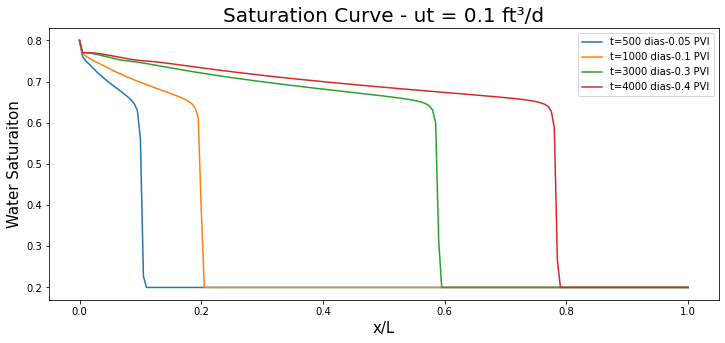

In [ ]:
finitedifference5.saturation_curve()

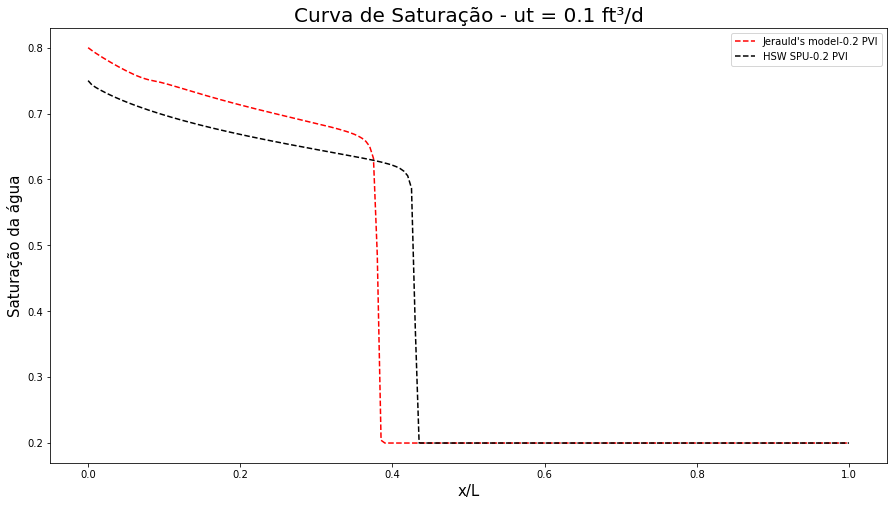

In [ ]:
# Comparision between the Corey model and the Jerauld's model, which simulates the low salinity waterflooding
finitedifference5.saturation_curve_comparision(hs_blmodel, hs_matrix, 2000, "Jerauld's model", "HSW SPU")

In [ ]:
finitedifference5.oil_recovery(medium)

In [ ]:
test1_vector = finitedifference5.get_recovered_oil_vector()

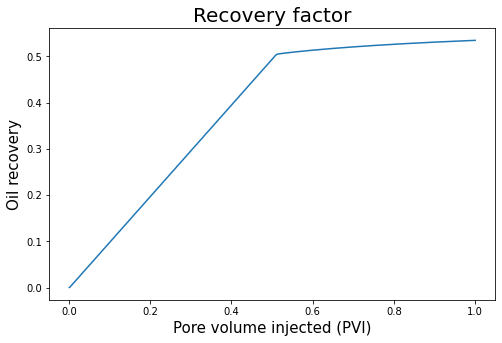

In [ ]:
finitedifference5.recovery_factor_curve(test1_vector)

In [ ]:
finitedifference15.oil_recovery(medium, matrix2)

In [ ]:
test2_vector = finitedifference15.get_recovered_oil_vector()

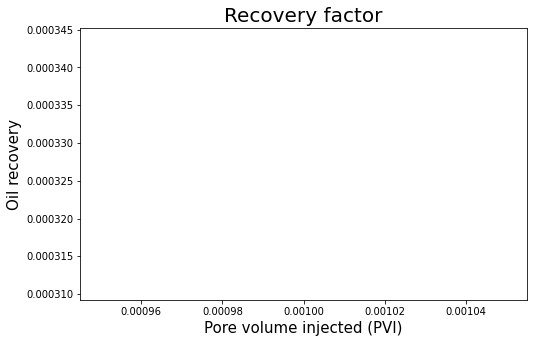

In [ ]:
finitedifference15.recovery_factor_curve(test2_vector)

In [ ]:
finitedifference16.oil_recovery(medium)

In [ ]:
test3_vector = finitedifference16.get_recovered_oil_vector()

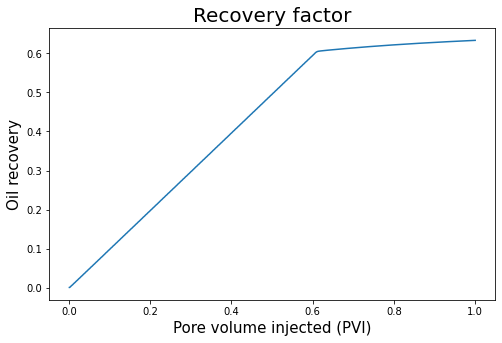

In [ ]:
finitedifference16.recovery_factor_curve(test3_vector)

In [ ]:
finitedifference7.oil_recovery(medium)

In [ ]:
hisal_vector = finitedifference7.get_recovered_oil_vector()

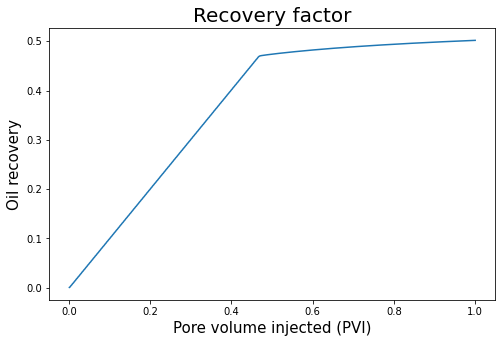

In [ ]:
finitedifference7.recovery_factor_curve(hisal_vector)

In [ ]:
finitedifference8.oil_recovery(medium)

In [ ]:
losal_vector = finitedifference8.get_recovered_oil_vector()

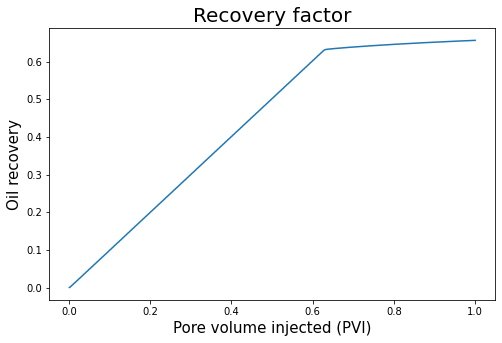

In [ ]:
finitedifference8.recovery_factor_curve(losal_vector)

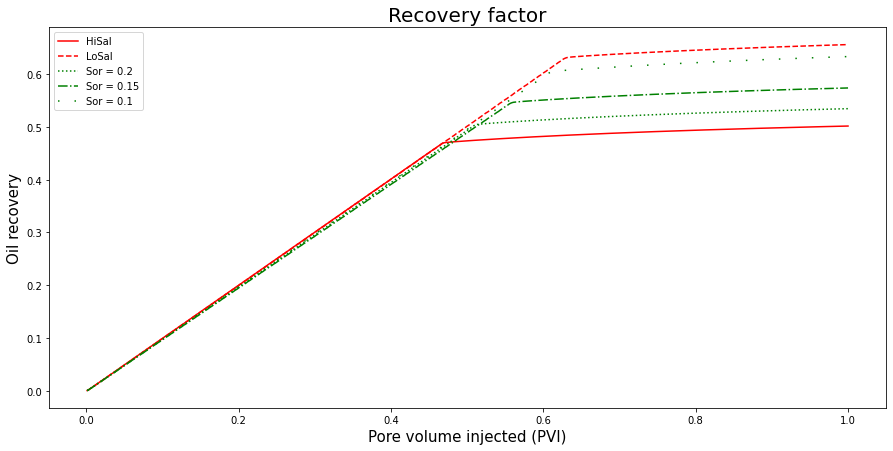

In [ ]:
#Explicit curves
#x-axis 
pvi = []
for i in range(1000):
  time_pvi = (i+1)*10
  pvi.append(domain.grid_dt(time_pvi))

#y-axis
fr1 = test1_vector
fr2 = test2_vector
fr3 = test3_vector
hs_fr = hisal_vector
ls_fr = losal_vector

#plot
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(1,1,1)

ax.plot(pvi, hs_fr, 'r', label = 'HiSal')
ax.plot(pvi, ls_fr, 'r--', label = 'LoSal')
ax.plot(pvi, fr1, color = 'green', linestyle = 'dotted', label = 'Sor = 0.2')
ax.plot(pvi, fr2, color = 'green', linestyle = 'dashdot', label = 'Sor = 0.15')
ax.plot(pvi, fr3, color = 'green', linestyle = (0, (1, 10)), label = 'Sor = 0.1')

ax.set_xlabel("Pore volume injected (PVI)", fontsize=15)
ax.set_ylabel("Oil recovery", fontsize=15)
plt.title("Recovery factor", fontsize=20)

ax.legend(loc="upper left")
plt.show()

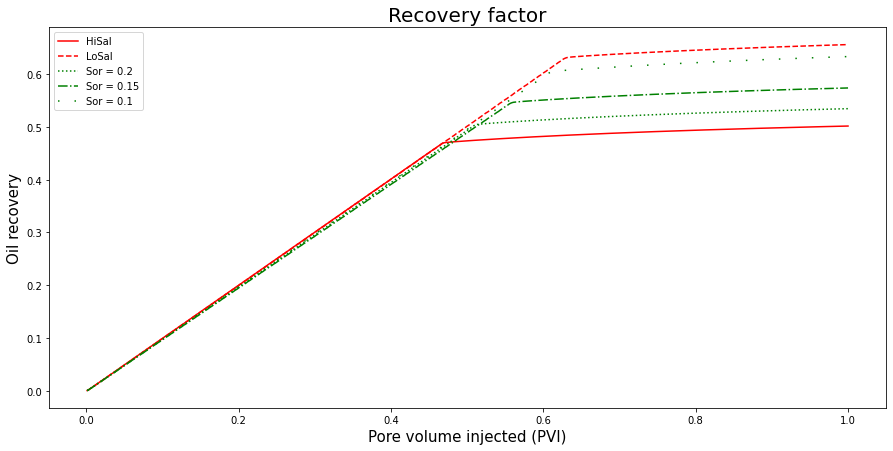

In [ ]:
#plotting the curves
#x-axis 
pvi = []
for i in range(1000):
  time_pvi = (i+1)*10
  pvi.append(domain.grid_dt(time_pvi))

#y-axis
fr1 = test1_vector
fr2 = test2_vector
fr3 = test3_vector
hs_fr = hisal_vector
ls_fr = losal_vector

#plot
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(1,1,1)

ax.plot(pvi, hs_fr, 'r', label = 'HiSal')
ax.plot(pvi, ls_fr, 'r--', label = 'LoSal')
ax.plot(pvi, fr1, color = 'green', linestyle = 'dotted', label = 'Sor = 0.2')
ax.plot(pvi, fr2, color = 'green', linestyle = 'dashdot', label = 'Sor = 0.15')
ax.plot(pvi, fr3, color = 'green', linestyle = (0, (1, 10)), label = 'Sor = 0.1')

ax.set_xlabel("Pore volume injected (PVI)", fontsize=15)
ax.set_ylabel("Oil recovery", fontsize=15)
plt.title("Recovery factor", fontsize=20)

ax.legend(loc="upper left")
plt.show()

### Relative permeability curves

In [ ]:
def three_curves_comparision(hs_perm, ls_perm, test_1 = 'None', test_2 = 'None', test_3 = 'None', label1 = 'None', label2 = 'None', label3 = 'None'):
  sw_vector1 = np.arange(hs_perm.swi, 1-hs_perm.sor, 0.01)
  krw1 = hs_perm.water_kr(sw_vector1)
  kro1 = hs_perm.oil_kr(sw_vector1)

  sw_vector2 = np.arange(ls_perm.swi, 1-ls_perm.sor, 0.01)
  krw2 = ls_perm.water_kr(sw_vector2)
  kro2 = ls_perm.oil_kr(sw_vector2)

  sw_vector3 = np.arange(test_1.swi, 1-hs_perm.sor, 0.01)
  krw3 = test_1.water_kr(sw_vector3)
  kro3 = test_1.oil_kr(sw_vector3)
  
  sw_vector4 = np.arange(test_2.swi, 1-hs_perm.sor, 0.01)
  krw4 = test_2.water_kr(sw_vector4)
  kro4 = test_2.oil_kr(sw_vector4)
  
  sw_vector5 = np.arange(test_3.swi, 1-hs_perm.sor, 0.01)
  krw5 = test_3.water_kr(sw_vector5)
  kro5 = test_3.oil_kr(sw_vector5)  

  fig = plt.figure(figsize=(10,8))
  ax = plt.subplot(1,1,1)

  ax.plot(sw_vector1, krw1, 'b', label = 'krw - HiSal')
  ax.plot(sw_vector1, kro1, 'y', label = 'kro - Hisal')
  ax.plot(sw_vector2, krw2, 'b--', label = 'krw - Losal')
  ax.plot(sw_vector2, kro2, 'y--', label = 'kro - Losal')
  
  ax.plot(sw_vector3, krw3, color = 'blue', linestyle = 'dotted', label = f'krw - {label1}')
  ax.plot(sw_vector3, kro3, color = 'yellow', linestyle = 'dotted', label = f'kro - {label1}')
  
  ax.plot(sw_vector4, krw4, color = 'blue', linestyle = 'dashdot', label = f'krw - {label2}')
  ax.plot(sw_vector4, kro4, color = 'yellow', linestyle = 'dashdot', label = f'kro - {label2}')
  
  ax.plot(sw_vector5, krw5, color = 'blue', linestyle = (0, (1, 10)), label = f'krw - {label3}')
  ax.plot(sw_vector5, kro5, color = 'yellow', linestyle = (0, (1, 10)), label = f'kro - {label3}')


  ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
  ax.set_ylabel("Relative Permeability", fontsize = 15)
  ax.set_title("Relative Permeability Curve", fontsize = 20)
  ax.legend(loc="upper right")
  
  plt.show()

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.2, 0.25, 3, 2, 0.5, 0.99)
ls_perm = CoreyModel(0.2, 0.081, 3, 2, 0.375, 0.99)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.2,0.75, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.2,0.919, domain)

#Creating transition time matrix
#hs_blmodel.transition_time_matrix()
#ls_blmodel.transition_time_matrix()

#Creating saturation matrix
#hs_saturation = hs_blmodel.saturation_matrix()
#ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
#hs_spu = SinglePointUpstream(medium, hs_perm)
#ls_spu = SinglePointUpstream(medium, ls_perm)


In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium) # the number of timesteps should be incresed in an attempt to capture the whole phenomenon
#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#test 1 - Sw = 0.20
#Creating the object that represents the relative permeability
perm1 = JerauldModel()
#Creating the high salinity limit
perm1.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm1.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm1.set_interpolator(0.2)

#test 2 - Sor = 0.15
#Creating the object that represents the relative permeability
perm2 = JerauldModel()
#Creating the high salinity limit
perm2.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm2.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm2.set_interpolator(0.15)

#test 3 - Sw = 0.10
#Creating the object that represents the relative permeability
perm3 = JerauldModel()
#Creating the high salinity limit
perm3.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm3.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm3.set_interpolator(0.1)

# test 1
#Creating the object that represents the Buckley-Leverett model
blmodel1 = BLModel(0.2, 0.8, domain)


# test 2
#Creating the object that represents the Buckley-Leverett model
blmodel2 = BLModel(0.2, 0.85, domain)


# test 3
#Creating the object that represents the Buckley-Leverett model
blmodel3 = BLModel(0.2, 0.9, domain)



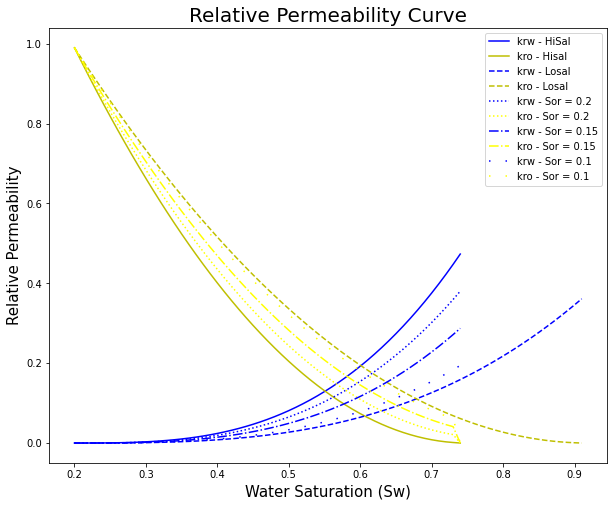

In [ ]:
three_curves_comparision(hs_perm, ls_perm, perm1, perm2, perm3, 'Sor = 0.2', 'Sor = 0.15', 'Sor = 0.1')

### Fractional flow

In [ ]:
def fractional_flow_curves(perm, spu, label):

  if (len(perm)!=5) or (len(spu)!=5) or (len(label)!=3):
    raise ValueError('incorrect list length')
  
  else: 
    p1,p2,p3,p4,p5 = perm
    sp1,sp2,sp3,sp4,sp5 = spu
    lb1, lb2, lb3 = label
  
    sw_vector1 = np.arange(p1.swi, 1-p1.sor, 0.0001)
    fw1 = [sp1.mobility(i) for i in sw_vector1]
    
    sw_vector2 = np.arange(p2.swi, 1-p2.sor, 0.0001)
    fw2 = [sp2.mobility(i) for i in sw_vector2]
    
    sw_vector3 = np.arange(p3.swi, 1-p3.sor, 0.0001)
    fw3 = [sp3.mobility(i) for i in sw_vector3]
      
    sw_vector4 = np.arange(p4.swi, 1-p4.sor, 0.0001)
    fw4 = [sp4.mobility(i) for i in sw_vector4]
    
    sw_vector5 = np.arange(p5.swi, 1-p5.sor, 0.0001)
    fw5 = [sp5.mobility(i) for i in sw_vector5]
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1,1,1)

    ax.plot(sw_vector1, fw1, 'b', label = 'HiSal')
    ax.plot(sw_vector2, fw2, 'b--', label = 'Losal')
    ax.plot(sw_vector3, fw3, color = 'green', linestyle = 'dotted', label = f'{lb1}')  
    ax.plot(sw_vector4, fw4, color = 'green', linestyle = 'dashdot', label = f'{lb2}')
    ax.plot(sw_vector5, fw5, color = 'green', linestyle = (0, (1, 10)), label = f'{lb3}')

    ax.set_xlabel("Water Saturation (Sw)", fontsize = 15)
    ax.set_ylabel("Fractional Flow (fw)", fontsize = 15)
    ax.set_title("Fractional flow vs Saturation Curve", fontsize = 20)
    ax.legend(loc="upper left")
    
    plt.show()

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.2, 0.25, 3, 2, 0.5, 0.99)
ls_perm = CoreyModel(0.2, 0.081, 3, 2, 0.375, 0.99)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.2,0.75, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.2,0.919, domain)

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium) # the number of timesteps should be incresed in an attempt to capture the whole phenomenon
#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#test 1 - Sw = 0.20
#Creating the object that represents the relative permeability
perm1 = JerauldModel()
#Creating the high salinity limit
perm1.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm1.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm1.set_interpolator(0.2)

#test 2 - Sor = 0.15
#Creating the object that represents the relative permeability
perm2 = JerauldModel()
#Creating the high salinity limit
perm2.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm2.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm2.set_interpolator(0.15)

#test 3 - Sw = 0.10
#Creating the object that represents the relative permeability
perm3 = JerauldModel()
#Creating the high salinity limit
perm3.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm3.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm3.set_interpolator(0.1)

# test 1
#Creating the object that represents the Buckley-Leverett model
blmodel1 = BLModel(0.2, 0.8, domain)

# test 2
#Creating the object that represents the Buckley-Leverett model
blmodel2 = BLModel(0.2, 0.85, domain)

# test 3
#Creating the object that represents the Buckley-Leverett model
blmodel3 = BLModel(0.2, 0.9, domain)

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
spu1 = SinglePointUpstream(medium, perm1)
spu2 = SinglePointUpstream(medium, perm2)
spu3 = SinglePointUpstream(medium, perm3)

In [ ]:
perm_list = [hs_perm,ls_perm,perm1,perm2,perm3]
spu_list = [hs_spu, ls_spu, spu1,spu2,spu3]
label_list = ['Sor = 0.20', 'Sor = 0.15','Sor = 0.10'] 

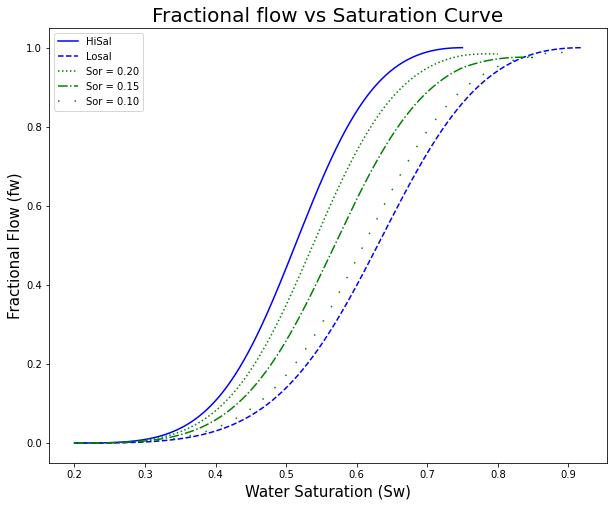

In [ ]:
fractional_flow_curves(perm_list, spu_list, label_list)

### Saturation Curves

In [ ]:
def three_saturation_curve_comparision(blmodels, saturation_curves, t, labels):
  "Function that plots the saturation curves comparision."
  blm1,blm2,blm3,blm4,blm5 = blmodels
  sc1,sc2,sc3,sc4,sc5 = saturation_curves
  lb1, lb2, lb3 = labels 
    
  sc1 = np.insert(sc1, 0, values = blm1.sw_cc, axis=1)
  sc2 = np.insert(sc2, 0, values = blm2.sw_cc, axis=1)
  sc3 = np.insert(sc3, 0, values = blm3.sw_cc, axis=1)
  sc4 = np.insert(sc4, 0, values = blm4.sw_cc, axis=1)
  sc5 = np.insert(sc5, 0, values = blm5.sw_cc, axis=1)

  length_vector = np.linspace(0, 1, domain.nx+1)
  
  fig = plt.figure(figsize=(15,8))
  ax = plt.subplot(1,1,1)

  #PVI calculations
  td_label = domain.grid_dt(t)
  n = int(t/10-1)
  
  ax.plot(length_vector, sc1[n], 'r', label = "Hisal")
  ax.plot(length_vector, sc2[n], 'r--', label = "Losal")
  ax.plot(length_vector, sc3[n], color = 'green', linestyle = 'dotted', label = f"{lb1}")
  ax.plot(length_vector, sc4[n], color = 'green', linestyle = 'dashdot', label = f"{lb2}")
  ax.plot(length_vector, sc5[n], color = 'green', linestyle = (0, (1, 10)), label = f"{lb3}")
    
  ax.set_xlabel("x/L", fontsize=15)
  ax.set_ylabel("Water Saturation", fontsize=15)
  plt.title("Saturation Curve - {} PVI".format(td_label), fontsize=20)
  ax.legend(loc="upper right")
  plt.show()

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.2, 0.25, 3, 2, 0.5, 0.99)
ls_perm = CoreyModel(0.2, 0.081, 3, 2, 0.375, 0.99)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.2,0.75, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.2,0.919, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
finitedifference7 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium)
#Creating the object that represents the chosen approach - SPU
finitedifference8 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium)

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200,4000, medium) 
#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#test 1 - Sw = 0.20
#Creating the object that represents the relative permeability
perm1 = JerauldModel()
#Creating the high salinity limit
perm1.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm1.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm1.set_interpolator(0.2)

#test 2 - Sor = 0.15
#Creating the object that represents the relative permeability
perm2 = JerauldModel()
#Creating the high salinity limit
perm2.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm2.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm2.set_interpolator(0.15)

#test 3 - Sw = 0.10
#Creating the object that represents the relative permeability
perm3 = JerauldModel()
#Creating the high salinity limit
perm3.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm3.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm3.set_interpolator(0.1)

# test 1
#Creating the object that represents the Buckley-Leverett model
blmodel1 = BLModel(0.2, 0.8, domain)
#Creating transition time matrix
blmodel1.transition_time_matrix()
#Creating saturation matrix
saturation1 = blmodel1.saturation_matrix()

# test 2
#Creating the object that represents the Buckley-Leverett model
blmodel2 = BLModel(0.2, 0.85, domain)
#Creating transition time matrix
blmodel2.transition_time_matrix()
#Creating saturation matrix
saturation2 = blmodel2.saturation_matrix()

# test 3
#Creating the object that represents the Buckley-Leverett model
blmodel3 = BLModel(0.2, 0.9, domain)
#Creating transition time matrix
blmodel3.transition_time_matrix()
#Creating saturation matrix
saturation3 = blmodel3.saturation_matrix()

#Choosing the fractional flow calculation approach
#tvd = TVD(medium, perm, domain)
spu1 = SinglePointUpstream(medium, perm1)
spu2 = SinglePointUpstream(medium, perm2)
spu3 = SinglePointUpstream(medium, perm3)

#Creating the object that represents the chosen approach - SPU
finitedifference17 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium)
finitedifference18 = ExplicitMethod(spu2, saturation2, blmodel2, domain, medium)
finitedifference19 = ExplicitMethod(spu3, saturation3, blmodel3, domain, medium)
#Creating the object that represents the chosen approach - TVD
#finitedifference20 = ExplicitMethod(tvd, saturation, blmodel, domain, medium)

In [ ]:
#Calculation of saturation matrix - test 1
finitedifference17.solver()
matrix1 = finitedifference17.get_matrix()
#Calculation of saturation matrix - test 2
finitedifference18.solver()
matrix2 = finitedifference18.get_matrix()
#Calculation of saturation matrix - test 3
finitedifference19.solver()
matrix3 = finitedifference19.get_matrix()
#Calculation of saturation matrix HiSal
finitedifference7.solver()
hs_matrix = finitedifference7.get_matrix()
#Calculation of saturation matrix LoSal
finitedifference8.solver()
ls_matrix = finitedifference8.get_matrix()

In [ ]:
saturations_list = [hs_matrix,ls_matrix,matrix1,matrix2,matrix3]
blmodels_list = [hs_blmodel, ls_blmodel, blmodel1, blmodel2, blmodel3]
labels_list = ['Sor = 0.20', 'Sor = 0.15', 'Sor = 0.10']

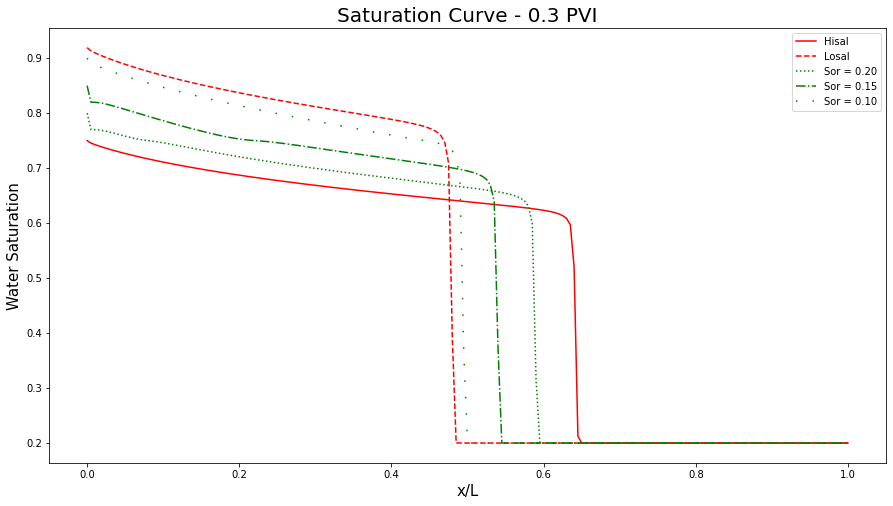

In [ ]:
finitedifference8.three_saturation_curve_comparision(blmodels_list, saturations_list, 3000, labels_list)

### TVD explicit and SPU implicit

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability
hs_perm = CoreyModel(0.2, 0.25, 3, 2, 0.5, 0.99)
ls_perm = CoreyModel(0.2, 0.081, 3, 2, 0.375, 0.99)

#Creating the object that represents the Buckley-Leverett model
hs_blmodel = BLModel(0.2,0.75, domain) #Sw_CC = 1-Sor
ls_blmodel = BLModel(0.2,0.919, domain)

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()

hs_saturation1 = hs_blmodel.saturation_matrix()
ls_saturation1 = ls_blmodel.saturation_matrix()

#Choosing the fractional flow calculation approach
hs_tvd = TVD(medium, hs_perm, domain)
ls_tvd = TVD(medium, ls_perm, domain)
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)

hs_spu1 = SinglePointUpstream(medium, hs_perm)
ls_spu1 = SinglePointUpstream(medium, ls_perm)

#Creating the object that represents the chosen approach - SPU
finitedifference7 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium)
#Creating the object that represents the chosen approach - SPU
finitedifference8 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium)

#Creating the object that represents the chosen approach - TVD
#finitedifference7 = ExplicitMethod(hs_tvd, hs_saturation, hs_blmodel, domain, medium)
#Creating the object that represents the chosen approach - TVD
#finitedifference8 = ExplicitMethod(ls_tvd, ls_saturation, ls_blmodel, domain, medium)

#Creating the object that represents the chosen approach - Implicit
finitedifference71 = ImplicitMethod(domain, medium, hs_perm, hs_spu1, hs_saturation1, hs_blmodel)
#Creating the object that represents the chosen approach - Implicit
finitedifference81 = ImplicitMethod(domain, medium, ls_perm, ls_spu1, ls_saturation1, ls_blmodel)

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 4000, medium) 
#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#test 1 - Sw = 0.20
#Creating the object that represents the relative permeability
perm1 = JerauldModel()
#Creating the high salinity limit
perm1.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm1.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm1.set_interpolator(0.2)

#test 2 - Sor = 0.15
#Creating the object that represents the relative permeability
perm2 = JerauldModel()
#Creating the high salinity limit
perm2.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm2.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm2.set_interpolator(0.15)

#test 3 - Sw = 0.10
#Creating the object that represents the relative permeability
perm3 = JerauldModel()
#Creating the high salinity limit
perm3.input_limits('hsw', 0.2, 0.25, 3, 2, 0.5, 0.99)
#Creating the low salinity limit
perm3.input_limits('lsw', 0.2, 0.081, 3, 2, 0.375, 0.99)
#Creating the interpolator to use in the model
perm3.set_interpolator(0.1)

# test 1
#Creating the object that represents the Buckley-Leverett model
blmodel1 = BLModel(0.2, 0.8, domain)
#Creating transition time matrix
blmodel1.transition_time_matrix()
#Creating saturation matrix
saturation1 = blmodel1.saturation_matrix()

# test 2
#Creating the object that represents the Buckley-Leverett model
blmodel2 = BLModel(0.2, 0.85, domain)
#Creating transition time matrix
blmodel2.transition_time_matrix()
#Creating saturation matrix
saturation2 = blmodel2.saturation_matrix()

# test 3
#Creating the object that represents the Buckley-Leverett model
blmodel3 = BLModel(0.2, 0.9, domain)
#Creating transition time matrix
blmodel3.transition_time_matrix()
#Creating saturation matrix
saturation3 = blmodel3.saturation_matrix()

#Choosing the fractional flow calculation approach
tvd1 = TVD(medium, perm1, domain)
tvd2 = TVD(medium, perm2, domain)
tvd3 = TVD(medium, perm3, domain)
spu1 = SinglePointUpstream(medium, perm1)
spu2 = SinglePointUpstream(medium, perm2)
spu3 = SinglePointUpstream(medium, perm3)


#Creating the object that represents the chosen approach - SPU
finitedifference20 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium)
finitedifference21 = ExplicitMethod(spu2, saturation2, blmodel2, domain, medium)
finitedifference22 = ExplicitMethod(spu3, saturation3, blmodel3, domain, medium)
#Creating the object that represents the chosen approach - TVD
finitedifference23 = ExplicitMethod(tvd1, saturation1, blmodel1, domain, medium)
finitedifference24 = ExplicitMethod(tvd2, saturation2, blmodel2, domain, medium)
finitedifference25 = ExplicitMethod(tvd3, saturation3, blmodel3, domain, medium)
#Creating the object that represents the chosen approach - Implicit
finitedifference26 = ImplicitMethod(domain, medium, perm1, spu1, saturation1, blmodel1)
finitedifference27 = ImplicitMethod(domain, medium, perm2, spu2, saturation2, blmodel2)
finitedifference28 = ImplicitMethod(domain, medium, perm3, spu3, saturation3, blmodel3)

In [ ]:
#EXPLICIT - SPU
#Calculation of saturation matrix - test 1
finitedifference20.solver()
matrix1 = finitedifference20.get_matrix()
#Calculation of saturation matrix - test 2
finitedifference21.solver()
matrix2 = finitedifference21.get_matrix()
#Calculation of saturation matrix - test 3
finitedifference22.solver()
matrix3 = finitedifference22.get_matrix()
#Calculation of saturation matrix HiSal
finitedifference7.solver()
hs_matrix = finitedifference7.get_matrix()
#Calculation of saturation matrix LoSal
finitedifference8.solver()
ls_matrix = finitedifference8.get_matrix()

In [ ]:
#EXPLICIT - TVD
#Calculation of saturation matrix - test 1
finitedifference20.solver()
matrix1 = finitedifference20.get_matrix()
#Calculation of saturation matrix - test 2
finitedifference21.solver()
matrix2 = finitedifference21.get_matrix()
#Calculation of saturation matrix - test 3
finitedifference22.solver()
matrix3 = finitedifference22.get_matrix()
#Calculation of saturation matrix HiSal
finitedifference7.solver()
hs_matrix = finitedifference7.get_matrix()
#Calculation of saturation matrix LoSal
finitedifference8.solver()
ls_matrix = finitedifference8.get_matrix()

In [ ]:
#IMPLICIT - SPU
#Calculation of saturation matrix - test 1
finitedifference26.solver2()
matrix11 = finitedifference26.get_matrix()
#Calculation of saturation matrix - test 2
finitedifference27.solver2()
matrix21 = finitedifference27.get_matrix()
#Calculation of saturation matrix - test 3
finitedifference28.solver2()
matrix31 = finitedifference28.get_matrix()
#Calculation of saturation matrix HiSal
finitedifference71.solver2()
hs_matrix1 = finitedifference71.get_matrix()
#Calculation of saturation matrix LoSal
finitedifference81.solver2()
ls_matrix1 = finitedifference81.get_matrix()

In [ ]:
saturations_list = [hs_matrix, ls_matrix, matrix1, matrix2, matrix3]
blmodels_list = [hs_blmodel, ls_blmodel, blmodel1, blmodel2, blmodel3]
labels_list = ['Sor = 0.20', 'Sor = 0.15', 'Sor = 0.10']

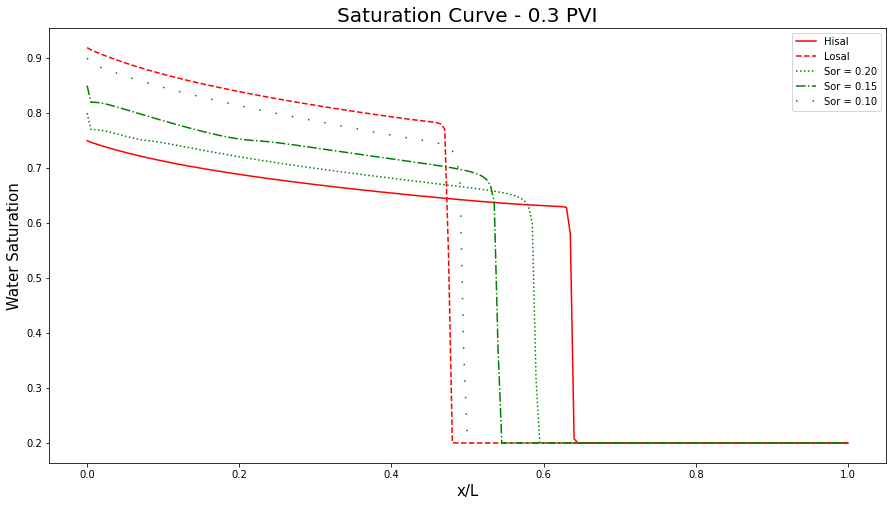

In [ ]:
#TVD simulation curve
finitedifference25.three_saturation_curve_comparision(blmodels_list, saturations_list, 3000, labels_list)

In [ ]:
matrix11[299]

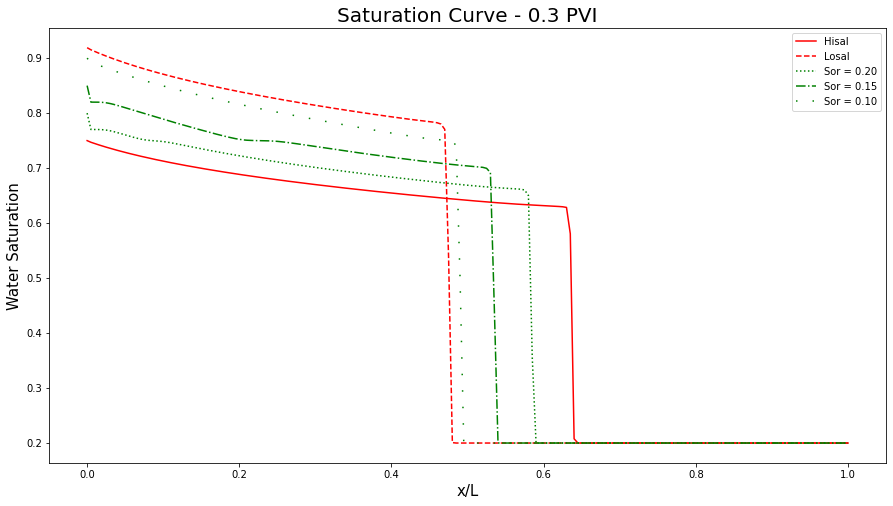

In [ ]:
three_saturation_curve_comparision(blmodels_list, saturations_list, 3000, labels_list)

In [ ]:
saturations_list_imp = [hs_matrix1, ls_matrix1, matrix11, matrix21, matrix31]
blmodels_list_imp = [hs_blmodel, ls_blmodel, blmodel1, blmodel2, blmodel3]
labels_list = ['Sor = 0.20', 'Sor = 0.15', 'Sor = 0.10']

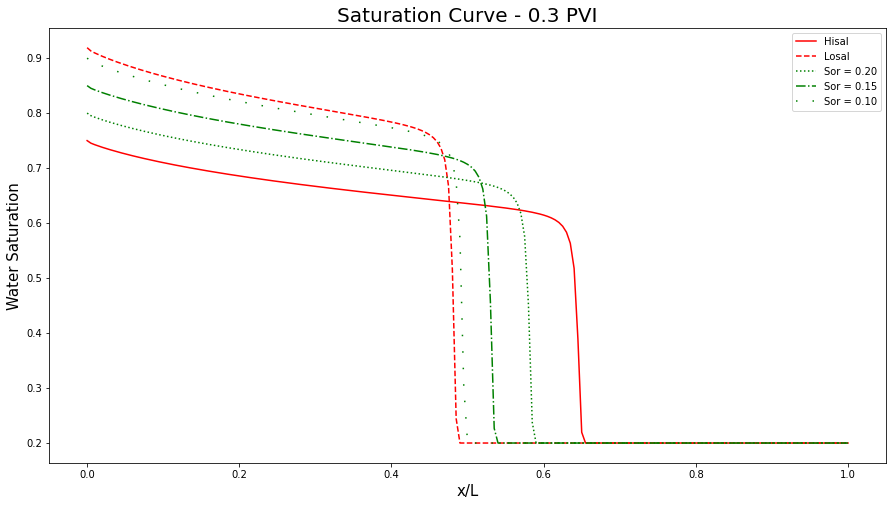

In [ ]:
#Implict method
finitedifference26.three_saturation_curve_comparision(blmodels_list_imp, saturations_list_imp, 3000, labels_list)

In [ ]:
def two_saturation_curve_comparision(blmodels, saturation_curves, t, labels):
  "Function that plots the saturation curves comparision."
  blm1,blm2 = blmodels
  sc1,sc2 = saturation_curves
  lb1, lb2 = labels 
    
  sc1 = np.insert(sc1, 0, values = blm1.sw_cc, axis=1)
  sc2 = np.insert(sc2, 0, values = blm2.sw_cc, axis=1)
  #sc3 = np.insert(sc3, 0, values = blm3.sw_cc, axis=1)
  #sc4 = np.insert(sc4, 0, values = blm4.sw_cc, axis=1)
  #sc5 = np.insert(sc5, 0, values = blm5.sw_cc, axis=1)

  length_vector = np.linspace(0, 1, domain.nx+1)
  
  fig = plt.figure(figsize=(15,8))
  ax = plt.subplot(1,1,1)

  #PVI calculations
  td_label = domain.grid_dt(t)
  n = int(t/10-1)
  
  #ax.plot(xd2, vetor_saturacao2,  label = 'Analítico')
  ax.plot(length_vector, sc1[n], 'r', label = f"{lb1}")
  ax.plot(length_vector, sc2[n], 'r--', label = f"{lb2}")
  #ax.plot(length_vector, sc3[n], color = 'green', linestyle = 'dotted', label = f"{lb1}")
  #ax.plot(length_vector, sc4[n], color = 'green', linestyle = 'dashdot', label = f"{lb2}")
  #ax.plot(length_vector, sc5[n], color = 'green', linestyle = (0, (1, 10)), label = f"{lb3}")
    
  ax.set_xlabel("x/L", fontsize=15)
  ax.set_ylabel("Water Saturation", fontsize=15)
  plt.title("Saturation Curve - {} PVI".format(td_label), fontsize=20)
  ax.legend(loc="upper right")
  plt.show()

In [ ]:
saturations_list = [matrix2, matrix21]
blmodels_list = [blmodel2, blmodel2]
labels_list = ['Losal explicit', 'Losal implicit']

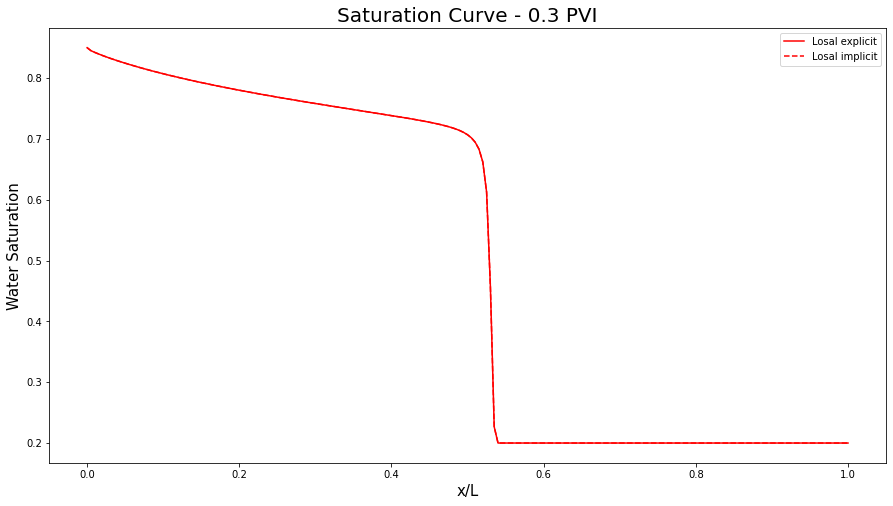

In [ ]:
two_saturation_curve_comparision(blmodels_list, saturations_list, 3000, labels_list)

## Wu model

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = WuModel(0.2)
hs_perm.input_limits()
#Losal
ls_perm = WuModel(0.2)
ls_perm.input_limits()
#Test1
perm1 = WuModel(0.2)
perm1.input_limits()
#Creating the object that represents the Buckley-Leverett model
#Hisal
c_na_hs = 0.01
sw_cc_hs = 1-hs_perm.sor_function(c_na_hs)
hs_blmodel = BLModel(0.2, sw_cc_hs, domain, 0.01, c_na_hs) # The concentration in the initial state is equal to hisal concentration.
#Losal
c_na_ls = 0.001
sw_cc_ls = 1-ls_perm.sor_function(c_na_ls)
ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.
#test1
c_na = 0.0045
sw_cc = 1-perm1.sor_function(c_na)
blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()
blmodel1.transition_time_matrix()
#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
hs_saturation2 = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()
ls_saturation2 = ls_blmodel.saturation_matrix()
saturation1 = blmodel1.saturation_matrix()
#Creating concentration matrix
hs_concentration = hs_blmodel.concentration_matrix()
ls_concentration = ls_blmodel.concentration_matrix()
concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)
spu1 = SinglePointUpstream(medium, perm1)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference70 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_concentration)
finitedifference70.input_parameters(0.1, 0.5) #require a critical evaluation
#with different solver
finitedifference73 = ExplicitMethod(hs_spu, hs_saturation2, hs_blmodel, domain, medium, hs_concentration)
finitedifference73.input_parameters(0.1, 0.5) #require a critical evaluation
#Losal
finitedifference71 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)
finitedifference71.input_parameters(0.1, 0.5) #require a critical evaluation 
#with different solver
finitedifference74 = ExplicitMethod(ls_spu, ls_saturation2, ls_blmodel, domain, medium, ls_concentration)
finitedifference74.input_parameters(0.1, 0.5) #require a critical evaluation 
#Test1
finitedifference72 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium, concentration1)
finitedifference72.input_parameters(0.1, 0.5) #require a critical evaluation 

In [ ]:
#EXPLICIT - SPU
#Hisal
finitedifference70.solver3()
hs_matrix = finitedifference70.get_matrix()
hs_ion_matrix = finitedifference70.get_ion_matrix()

finitedifference70.oil_recovery(medium, hs_matrix)
hs_vector = finitedifference70.get_recovered_oil_vector()
#with different solver
finitedifference73.solver3_1()
hs_matrix2 = finitedifference73.get_matrix()
#Losal
finitedifference71.solver3()
ls_matrix = finitedifference71.get_matrix()
ls_ion_matrix = finitedifference71.get_ion_matrix()
#with different solver
finitedifference74.solver3_1()
ls_matrix2 = finitedifference74.get_matrix()

finitedifference74.oil_recovery(medium, ls_matrix2)
ls_vector = finitedifference74.get_recovered_oil_vector()

#Test 1 
finitedifference72.solver3()
matrix1 = finitedifference72.get_matrix()
ion_matrix1 = finitedifference72.get_ion_matrix()

finitedifference72.oil_recovery(medium, matrix1)
vector1 = finitedifference72.get_recovered_oil_vector()

Test with diffusion term

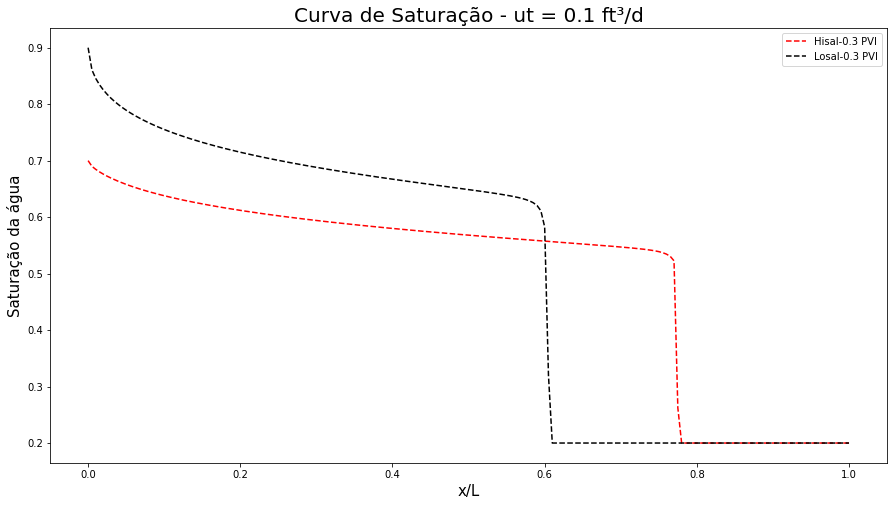

In [ ]:
finitedifference70.saturation_curve_comparision(ls_blmodel, ls_matrix2, 3000, 'Hisal','Losal')

In [ ]:
finitedifference72.saturation_curve()

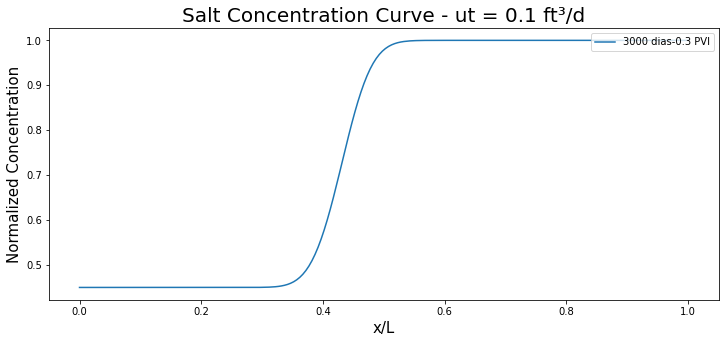

In [ ]:
finitedifference72.concentration_curve(ion_matrix1, 0.01, 3000)

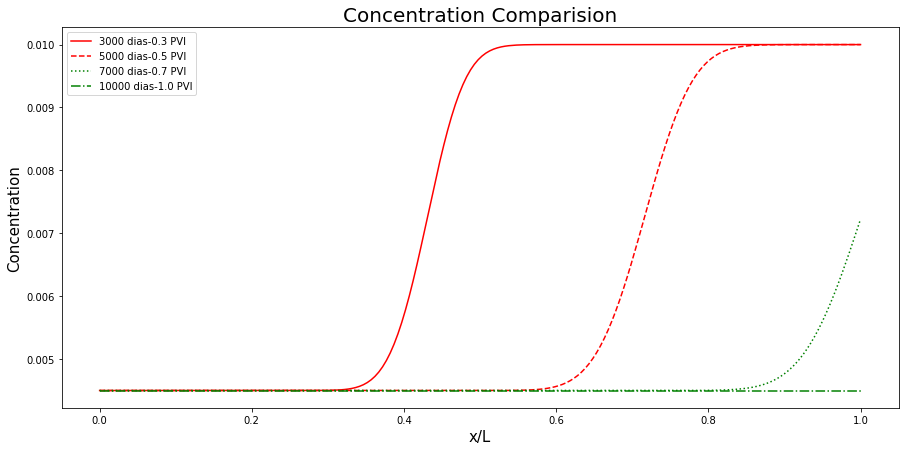

In [ ]:
# Kd = 0.05
td_vector = [3000, 5000, 7000, 10000]
finitedifference72.concentration_comparision(ion_matrix1, td_vector)

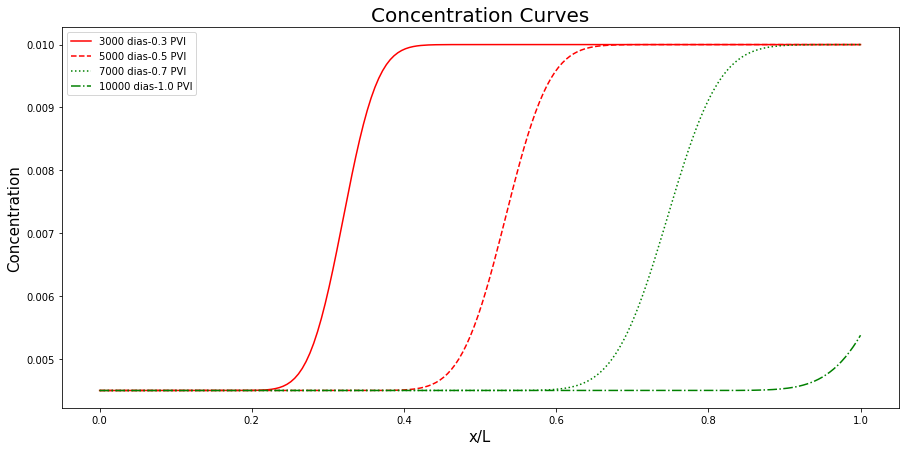

In [ ]:
# Kd = 0.5
td_vector = [3000, 5000, 7000, 10000]
finitedifference72.concentration_comparision(ion_matrix1, td_vector)

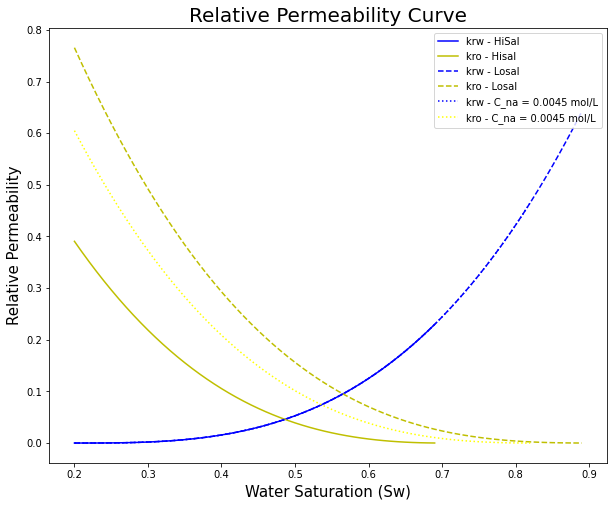

In [ ]:
perm1.rel_perm_ions(perm1, 0.01, 0.001, 0.0045, 'C_na = 0.0045 mol/L')

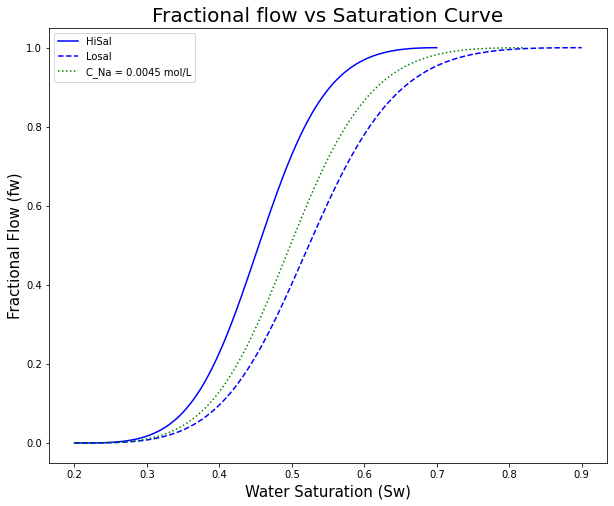

In [ ]:
na_conc = [0.01, 0.001, 0.0045]
spu1.fractional_flow_with_ions(perm1, na_conc, spu1, 'C_Na = 0.0045 mol/L')

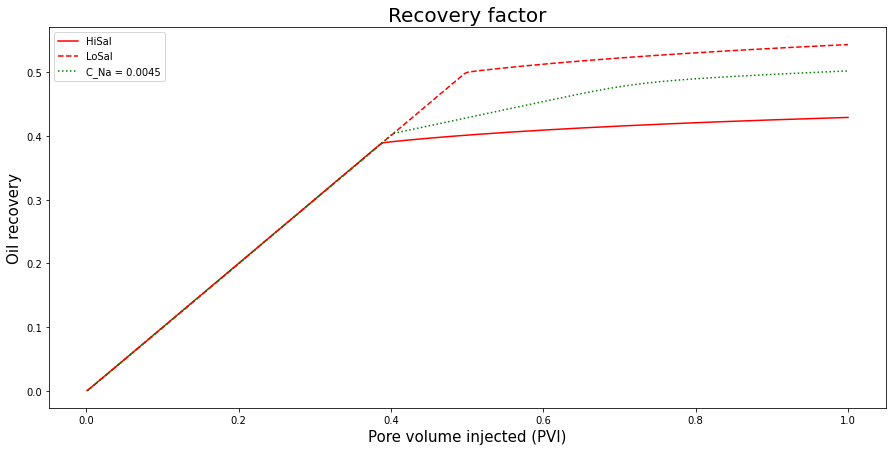

In [ ]:
recovered_oil = [hs_vector, ls_vector, vector1]
finitedifference70.wu_recovery_factor_comparision(recovered_oil, 'C_Na = 0.0045')

Test without diffusion term

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = WuModel(0.2)
hs_perm.input_limits()
#Losal
ls_perm = WuModel(0.2)
ls_perm.input_limits()
#Test1
perm1 = WuModel(0.2)
perm1.input_limits()
#Creating the object that represents the Buckley-Leverett model
#Hisal
c_na_hs = 0.01
sw_cc_hs = 1-hs_perm.sor_function(c_na_hs)
hs_blmodel = BLModel(0.2, sw_cc_hs, domain, 0.01, c_na_hs) # The concentration in the initial state is equal to hisal concentration.
#Losal
c_na_ls = 0.001
sw_cc_ls = 1-ls_perm.sor_function(c_na_ls)
ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.
#test1
c_na = 0.0045
sw_cc = 1-perm1.sor_function(c_na)
blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()
blmodel1.transition_time_matrix()
#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
hs_saturation2 = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()
ls_saturation2 = ls_blmodel.saturation_matrix()
saturation1 = blmodel1.saturation_matrix()
#Creating concentration matrix
hs_concentration = hs_blmodel.concentration_matrix()
ls_concentration = ls_blmodel.concentration_matrix()
concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)
spu1 = SinglePointUpstream(medium, perm1)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference75 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_concentration)
finitedifference75.input_parameters(0.1, 0.5) #require a critical evaluation
#with different solver
finitedifference76 = ExplicitMethod(hs_spu, hs_saturation2, hs_blmodel, domain, medium, hs_concentration)
finitedifference76.input_parameters(0.1, 0.5) #require a critical evaluation
#Losal
finitedifference77 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)
finitedifference77.input_parameters(0.1, 0.5) #require a critical evaluation 
#with different solver
finitedifference78 = ExplicitMethod(ls_spu, ls_saturation2, ls_blmodel, domain, medium, ls_concentration)
finitedifference78.input_parameters(0.1, 0.5) #require a critical evaluation 
#Test1
finitedifference79 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium, concentration1)
finitedifference79.input_parameters(0.1, 0.5) #require a critical evaluation

In [ ]:
#EXPLICIT - SPU
#Hisal
finitedifference75.solver3_2()
hs_matrix3 = finitedifference75.get_matrix()
hs_ion_matrix2 = finitedifference75.get_ion_matrix()

finitedifference75.oil_recovery(medium, hs_matrix3)
hs_vector2 = finitedifference75.get_recovered_oil_vector()
#with different solver
finitedifference76.solver3_1()
hs_matrix4 = finitedifference76.get_matrix()
#Losal
finitedifference77.solver3_2()
ls_matrix3 = finitedifference77.get_matrix()
ls_ion_matrix2 = finitedifference77.get_ion_matrix()
#with different solver
finitedifference78.solver3_1()
ls_matrix4 = finitedifference78.get_matrix()

finitedifference78.oil_recovery(medium, ls_matrix4)
ls_vector2 = finitedifference78.get_recovered_oil_vector()

#Test 1 
finitedifference79.solver3_2()
matrix2 = finitedifference79.get_matrix()
ion_matrix2 = finitedifference79.get_ion_matrix()

finitedifference79.oil_recovery(medium, matrix2)
vector2 = finitedifference79.get_recovered_oil_vector()

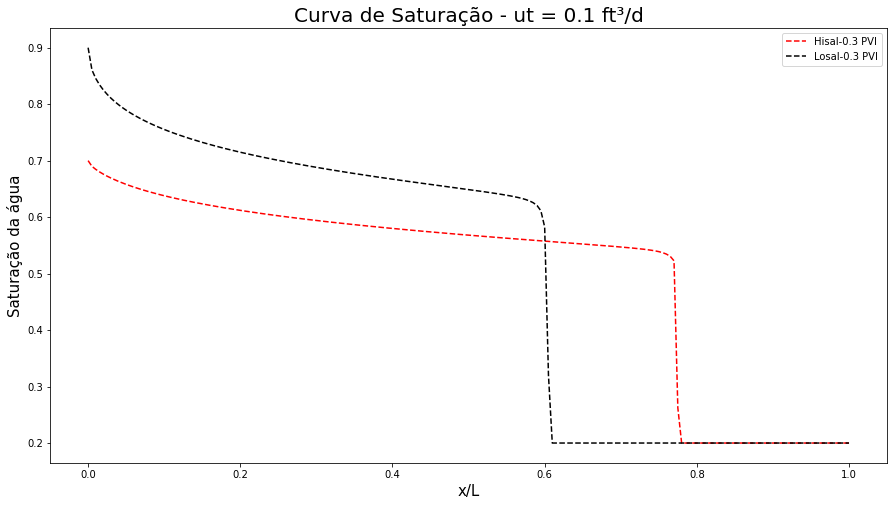

In [ ]:
finitedifference75.saturation_curve_comparision(ls_blmodel, ls_matrix4, 3000, 'Hisal','Losal')

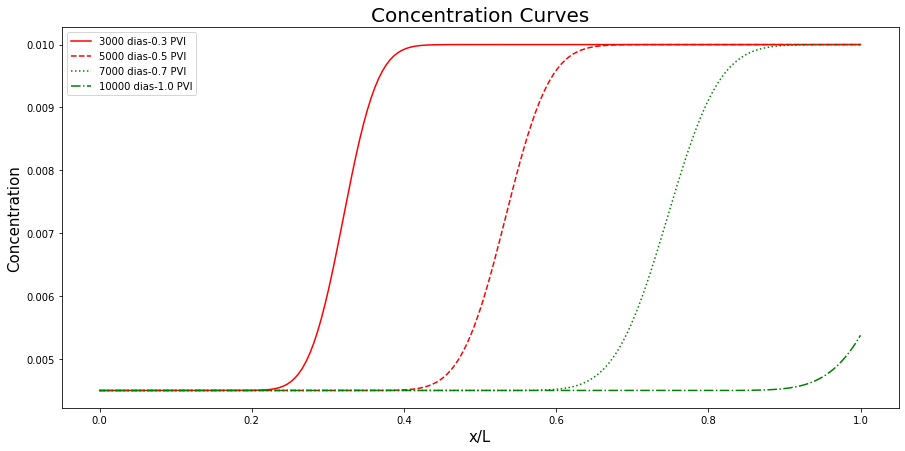

In [ ]:
#Distribution Coefficient Kd = 0.05 
td_vector = [3000, 5000, 7000, 10000]
finitedifference79.concentration_comparision(ion_matrix2, td_vector)

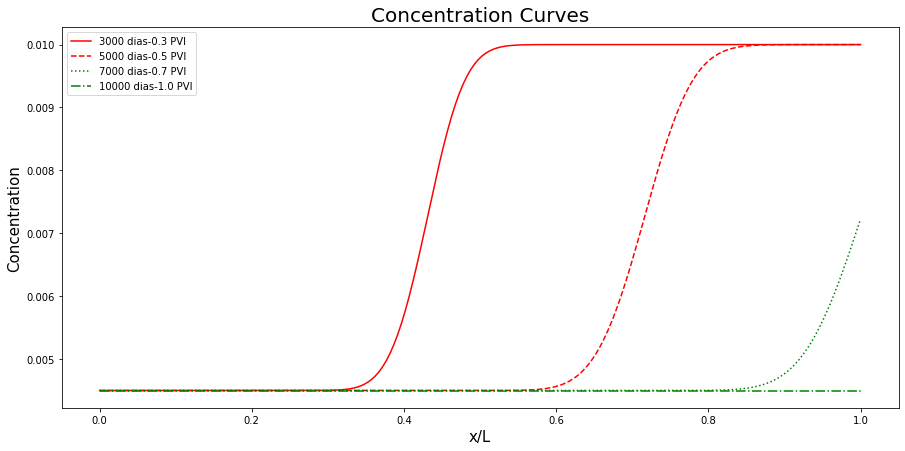

In [ ]:
#Distribution Coefficient Kd = 0.05 
td_vector = [3000, 5000, 7000, 10000]
finitedifference79.concentration_comparision(ion_matrix2, td_vector)

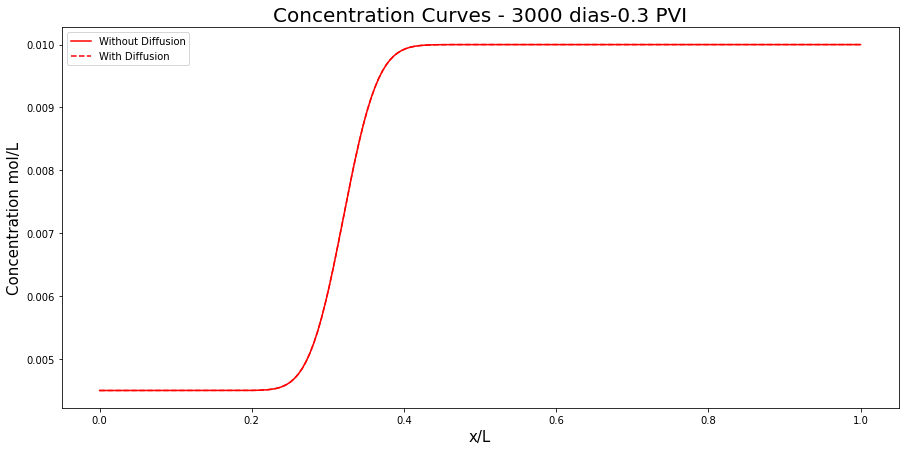

In [ ]:
finitedifference79.concentration_comparision_two(ion_matrix2, ion_matrix1, 3000, "Without Diffusion", "With Diffusion")

Avaliação do coeficiente de difusão

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = WuModel(0.2)
hs_perm.input_limits()
#Losal
ls_perm = WuModel(0.2)
ls_perm.input_limits()
#Test1
perm1 = WuModel(0.2)
perm1.input_limits()
#Creating the object that represents the Buckley-Leverett model
#Hisal
c_na_hs = 0.01
sw_cc_hs = 1-hs_perm.sor_function(c_na_hs)
hs_blmodel = BLModel(0.2, sw_cc_hs, domain, 0.01, c_na_hs) # The concentration in the initial state is equal to hisal concentration.
#Losal
c_na_ls = 0.001
sw_cc_ls = 1-ls_perm.sor_function(c_na_ls)
ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.
#test1
c_na = 0.0045
sw_cc = 1-perm1.sor_function(c_na)
blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()
blmodel1.transition_time_matrix()
#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
hs_saturation2 = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()
ls_saturation2 = ls_blmodel.saturation_matrix()
saturation1 = blmodel1.saturation_matrix()
#Creating concentration matrix
hs_concentration = hs_blmodel.concentration_matrix()
ls_concentration = ls_blmodel.concentration_matrix()
concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)
spu1 = SinglePointUpstream(medium, perm1)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference80 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_concentration)
finitedifference80.input_parameters(0.1, 0.05, 0.00005) #require a critical evaluation
#with different solver
finitedifference81 = ExplicitMethod(hs_spu, hs_saturation2, hs_blmodel, domain, medium, hs_concentration)
finitedifference81.input_parameters(0.1, 0.05, 0.00005) #require a critical evaluation
#Losal
finitedifference82 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)
finitedifference82.input_parameters(0.1, 0.05, 0.00005) #require a critical evaluation 
#with different solver
finitedifference83 = ExplicitMethod(ls_spu, ls_saturation2, ls_blmodel, domain, medium, ls_concentration)
finitedifference83.input_parameters(0.1, 0.05, 0.00005) #require a critical evaluation 
#Test1
finitedifference84 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium, concentration1)
finitedifference84.input_parameters(0.1, 0.05, 0.00005) #require a critical evaluation

In [ ]:
#EXPLICIT - SPU
#Hisal
finitedifference80.solver3()
hs_matrix4 = finitedifference80.get_matrix()
hs_ion_matrix3 = finitedifference80.get_ion_matrix()

finitedifference80.oil_recovery(medium, hs_matrix4)
hs_vector3 = finitedifference80.get_recovered_oil_vector()
#with different solver
finitedifference81.solver3_1()
hs_matrix4 = finitedifference81.get_matrix()
#Losal
finitedifference82.solver3()
ls_matrix5 = finitedifference82.get_matrix()
ls_ion_matrix3 = finitedifference82.get_ion_matrix()
#with different solver
finitedifference83.solver3_1()
ls_matrix6 = finitedifference83.get_matrix()

finitedifference83.oil_recovery(medium, ls_matrix6)
ls_vector3 = finitedifference83.get_recovered_oil_vector()

#Test 1 
finitedifference84.solver3()
matrix3 = finitedifference84.get_matrix()
ion_matrix3 = finitedifference84.get_ion_matrix()

finitedifference84.oil_recovery(medium, matrix3)
vector3 = finitedifference84.get_recovered_oil_vector()

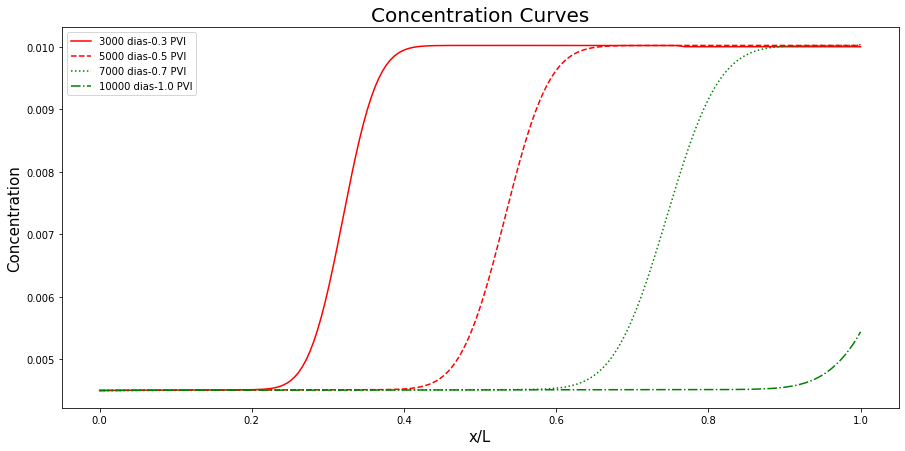

In [ ]:
#Dm = 5x10^-4
td_vector = [3000, 5000, 7000, 10000]
finitedifference84.concentration_comparision(ion_matrix3, td_vector)

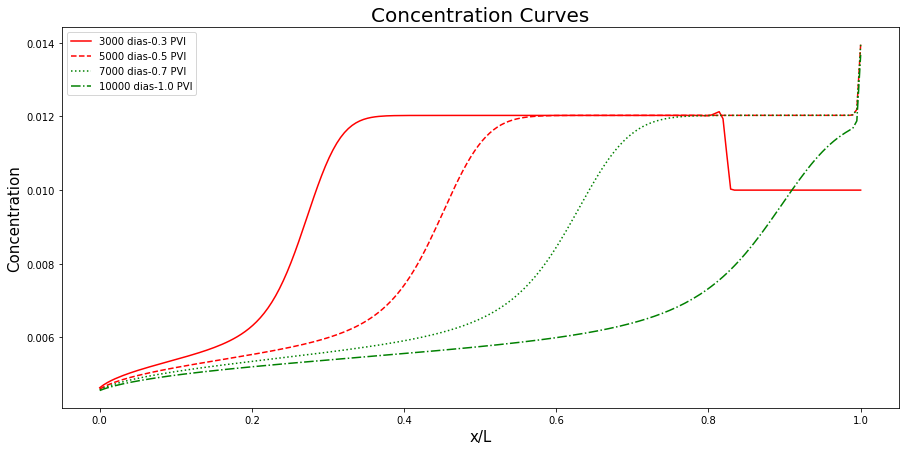

In [ ]:
#Dm = 0.05
td_vector = [3000, 5000, 7000, 10000]
finitedifference84.concentration_comparision(ion_matrix3, td_vector)

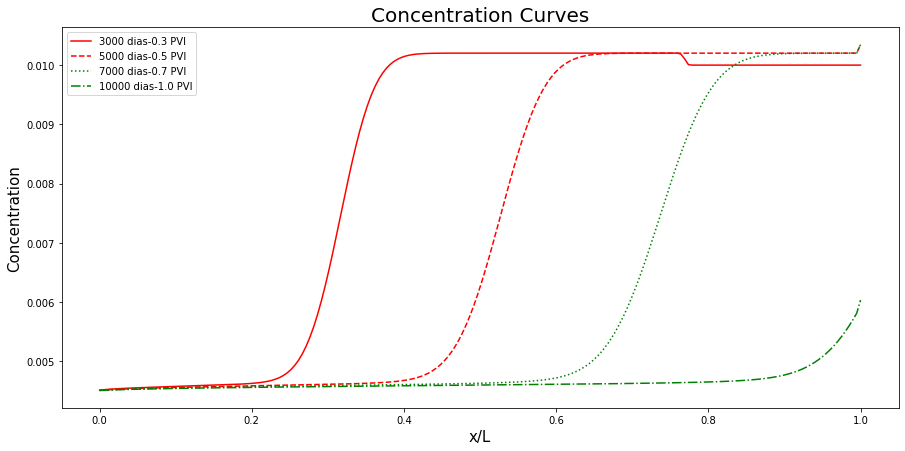

In [ ]:
#Dm = 0.005
td_vector = [3000, 5000, 7000, 10000]
finitedifference84.concentration_comparision(ion_matrix3, td_vector)

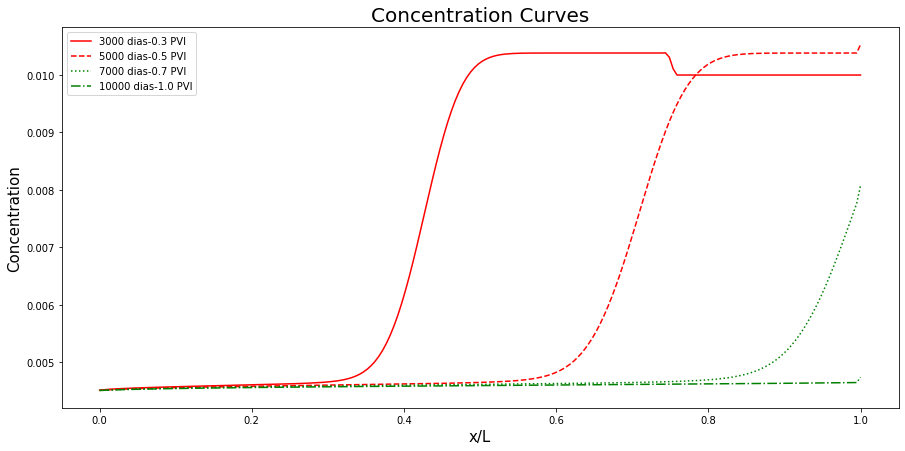

In [ ]:
#Kd = 0.05 / Dm = 0.005
td_vector = [3000, 5000, 7000, 10000]
finitedifference84.concentration_comparision(ion_matrix3, td_vector)

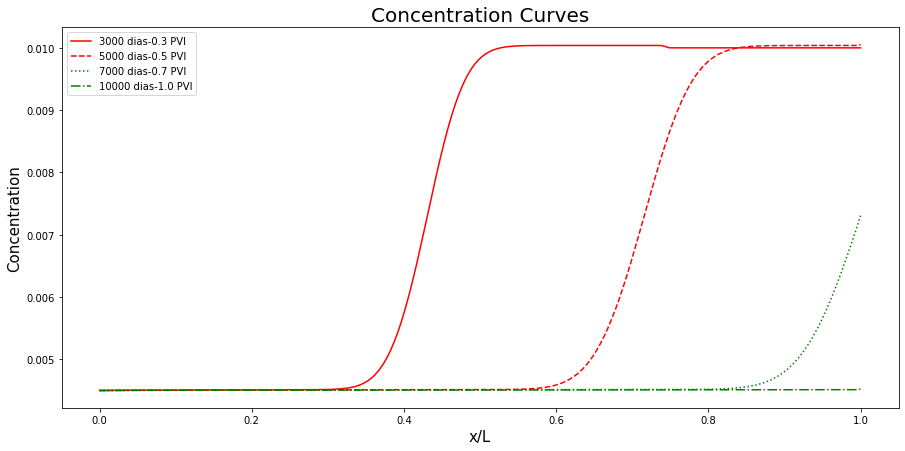

In [ ]:
#Kd = 0.05 / Dm = 0.0005
td_vector = [3000, 5000, 7000, 10000]
finitedifference84.concentration_comparision(ion_matrix3, td_vector)

Simulation with Corey model

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = CoreyModel(0.2, 0.3, 3, 2, 0.5, 0.99)
hs_perm1 = WuModel(0.2) #change the setting to use Corey's model
hs_perm1.input_limits()

#Losal
ls_perm = CoreyModel(0.2, 0.1, 3, 2, 0.5, 0.99)
ls_perm1 = WuModel(0.2, 'Corey')
ls_perm1.input_limits()

#set limits to Corey
ls_perm1.input_limits_corey(hs_perm, ls_perm)
hs_perm1.input_limits_corey(hs_perm, ls_perm)

#Test1
perm1 = WuModel(0.2, 'Corey')
perm1.input_limits()
perm1.input_limits_corey(hs_perm, ls_perm)
#Creating the object that represents the Buckley-Leverett model
#Hisal
c_na_hs = 0.01
sw_cc_hs = 1-hs_perm1.sor_function(c_na_hs)
hs_blmodel = BLModel(0.2, sw_cc_hs, domain, 0.01, c_na_hs) # The concentration in the initial state is equal to hisal concentration.
#Losal
c_na_ls = 0.001
sw_cc_ls = 1-ls_perm1.sor_function(c_na_ls)
ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.
#test1
c_na = 0.0045
sw_cc = 1-perm1.sor_function(c_na)
blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()
blmodel1.transition_time_matrix()
#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
#hs_saturation2 = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()
#ls_saturation2 = ls_blmodel.saturation_matrix()
saturation1 = blmodel1.saturation_matrix()
#Creating concentration matrix
hs_concentration = hs_blmodel.concentration_matrix()
ls_concentration = ls_blmodel.concentration_matrix()
concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm)
ls_spu = SinglePointUpstream(medium, ls_perm)
spu1 = SinglePointUpstream(medium, perm1)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference80 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_concentration)
#finitedifference80.input_parameters(0.1, 0.05) #require a critical evaluation
#with different solver
#finitedifference81 = ExplicitMethod(hs_spu, hs_saturation2, hs_blmodel, domain, medium, hs_concentration)
#finitedifference81.input_parameters(0.1, 0.05) #require a critical evaluation
#Losal
finitedifference82 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)
#finitedifference82.input_parameters(0.1, 0.05) #require a critical evaluation 
#with different solver
#finitedifference83 = ExplicitMethod(ls_spu, ls_saturation2, ls_blmodel, domain, medium, ls_concentration)
#finitedifference83.input_parameters(0.1, 0.05) #require a critical evaluation 
#Test1
finitedifference84 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium, concentration1)
finitedifference84.input_parameters(0.1, 0.05) #require a critical evaluation

In [ ]:
#EXPLICIT - SPU
#Hisal
finitedifference80.solver()
hs_matrix5 = finitedifference80.get_matrix()
#hs_ion_matrix3 = finitedifference80.get_ion_matrix()

finitedifference80.oil_recovery(medium, hs_matrix5)
hs_vector4 = finitedifference80.get_recovered_oil_vector()
#with different solver
#finitedifference81.solver3_1()
#hs_matrix4 = finitedifference81.get_matrix()
#Losal
finitedifference82.solver()
ls_matrix5 = finitedifference82.get_matrix()
#ls_ion_matrix3 = finitedifference82.get_ion_matrix()
#with different solver
#finitedifference83.solver3_1()
#ls_matrix6 = finitedifference83.get_matrix()

finitedifference82.oil_recovery(medium, ls_matrix5)
ls_vector3 = finitedifference82.get_recovered_oil_vector()

#Test 1 
finitedifference84.solver3()
matrix3 = finitedifference84.get_matrix()
ion_matrix3 = finitedifference84.get_ion_matrix()

finitedifference84.oil_recovery(medium, matrix3)
vector3 = finitedifference84.get_recovered_oil_vector()

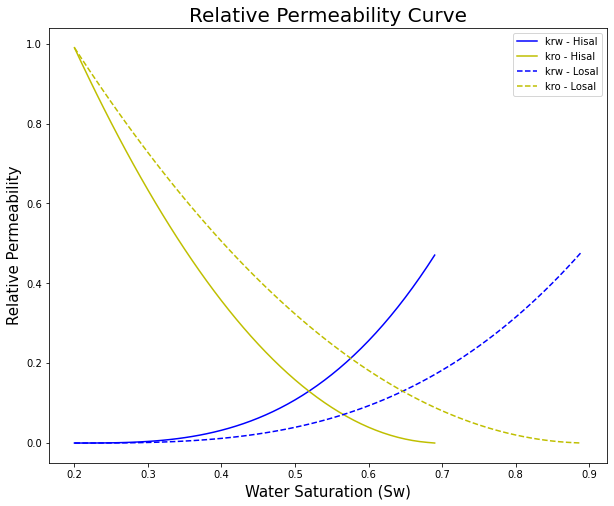

In [ ]:
#comparision of Hisal and Losal using the Corey's Model
hs_perm.curves_comparision(ls_perm, 'Hisal', 'Losal')

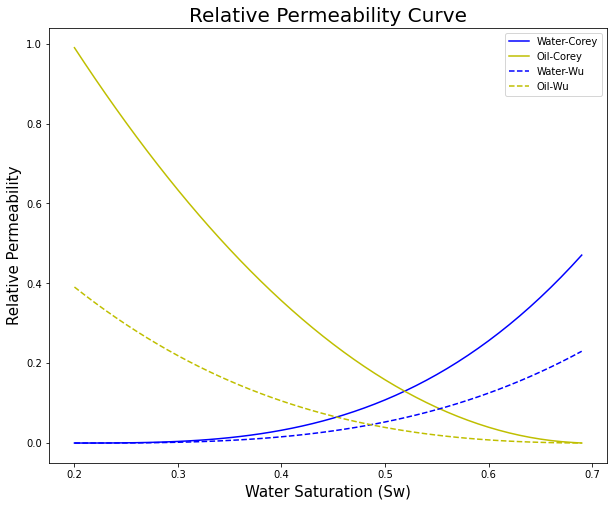

In [ ]:
#Comparision between the different models
sw_vector = np.arange(hs_perm.swi, 1-hs_perm.sor, 0.01)
krw = hs_perm.water_kr(sw_vector)
kro = hs_perm.oil_kr(sw_vector)

sw_vector2 = np.arange(hs_perm1.swi, 1-hs_perm1.sor_function(0.01), 0.01)
krw2 = hs_perm1.water_kr(sw_vector2, 0.01)
kro2 = hs_perm1.oil_kr(sw_vector2, 0.01)
    
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1)

ax.plot(sw_vector, krw, 'b', label = 'Water-Corey')
ax.plot(sw_vector, kro, 'y', label = 'Oil-Corey')
ax.plot(sw_vector2, krw2, 'b--', label = 'Water-Wu')
ax.plot(sw_vector2, kro2, 'y--', label = 'Oil-Wu')

plt.xlabel("Water Saturation (Sw)", fontsize = 15)
plt.ylabel("Relative Permeability", fontsize = 15)
plt.title("Relative Permeability Curve", fontsize = 20)
plt.legend(loc="upper right")
plt.show()

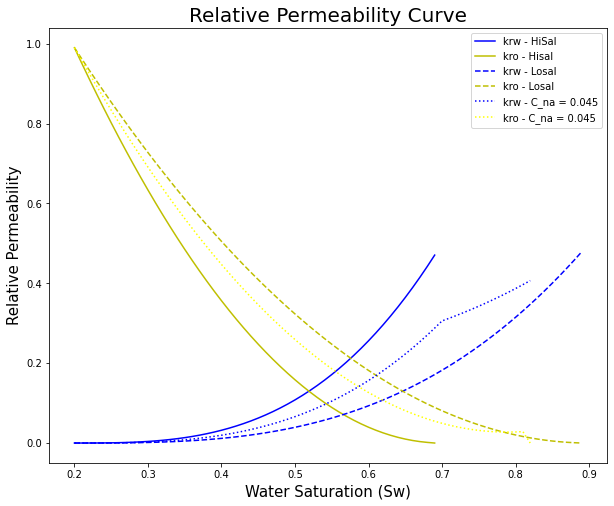

In [ ]:
#Comparision of different concentrations
perm = [hs_perm1, ls_perm1, perm1]
hs_perm1.rel_perm_ions(perm, 0.01, 0.001, 0.0045,'C_na = 0.045')

##Tripathi Model

Model 1

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = CoreyModel(0.2, 0.3, 3, 2, 0.5, 0.99)
hs_perm1 = TripathiModel(0.2) 
hs_perm1.input_limits()

#Losal
ls_perm = CoreyModel(0.2, 0.1, 3, 2, 0.5, 0.99)
ls_perm1 = TripathiModel(0.2)
ls_perm1.input_limits()

#set limits to Corey
ls_perm1.input_limits_corey(hs_perm, ls_perm)
hs_perm1.input_limits_corey(hs_perm, ls_perm)

#Test1
perm1 = TripathiModel(0.2)
perm1.input_limits()
perm1.input_limits_corey(hs_perm, ls_perm)

#Creating the object that represents the Buckley-Leverett model
#Hisal
c_na_hs = 0.01
sw_cc_hs = 1-hs_perm1.sor_function(c_na_hs)
hs_blmodel = BLModel(0.2, sw_cc_hs, domain, 0.01, c_na_hs) # The concentration in the initial state is equal to hisal concentration.

#Losal
c_na_ls = 0.001
sw_cc_ls = 1-ls_perm1.sor_function(c_na_ls)
ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.

#test1
c_na = 0.0045
sw_cc = 1-perm1.sor_function(c_na)
blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()
blmodel1.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()
saturation1 = blmodel1.saturation_matrix()

#Creating concentration matrix
hs_concentration = hs_blmodel.concentration_matrix()
ls_concentration = ls_blmodel.concentration_matrix()
concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm1)
ls_spu = SinglePointUpstream(medium, ls_perm1)
spu1 = SinglePointUpstream(medium, perm1)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference80 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_concentration)
#finitedifference80.input_parameters(0.1, 0.05) #require a critical evaluation

#Losal
finitedifference82 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)
#finitedifference82.input_parameters(0.1, 0.05) #require a critical evaluation 
#with different solver
#finitedifference83 = ExplicitMethod(ls_spu, ls_saturation2, ls_blmodel, domain, medium, ls_concentration)
#finitedifference83.input_parameters(0.1, 0.05) #require a critical evaluation 

#Test1
finitedifference84 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium, concentration1)
#finitedifference84.input_parameters(0.1, 0.05) #require a critical evaluation

In [ ]:
#EXPLICIT - SPU
#Hisal
finitedifference80.solver3_2()
hs_matrix = finitedifference80.get_matrix()
hs_ion_matrix = finitedifference80.get_ion_matrix()

finitedifference80.oil_recovery(medium, hs_matrix)
hs_vector = finitedifference80.get_recovered_oil_vector()

#Losal
finitedifference82.solver3_1()
ls_matrix = finitedifference82.get_matrix()
ls_ion_matrix = finitedifference82.get_ion_matrix()

finitedifference82.oil_recovery(medium, ls_matrix)
ls_vector = finitedifference82.get_recovered_oil_vector()

#Test 1 
finitedifference84.solver3_2()
matrix = finitedifference84.get_matrix()
ion_matrix = finitedifference84.get_ion_matrix()

finitedifference84.oil_recovery(medium, matrix)
vector = finitedifference84.get_recovered_oil_vector()

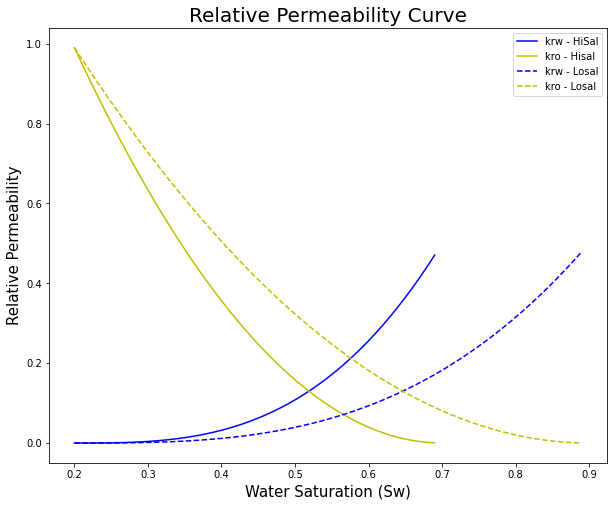

In [ ]:
perm = [hs_perm1, ls_perm1]
concentration = [0.01, 0.001]
hs_perm1.rel_perm_ions(perm, concentration)

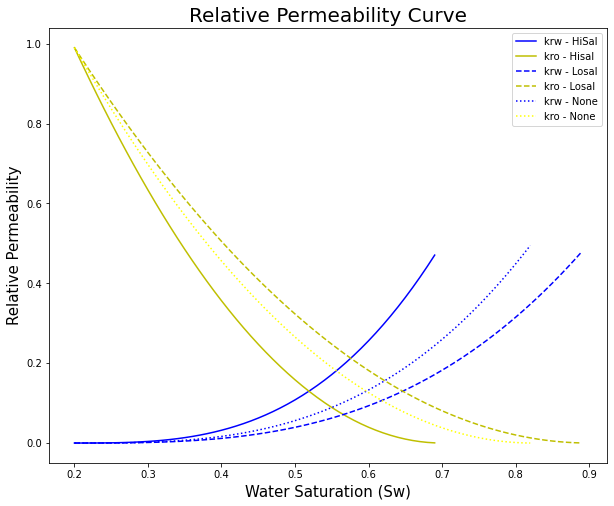

In [ ]:
perm = [hs_perm1, ls_perm1, perm1]
concentration = [0.01, 0.001, 0.0045]
hs_perm1.rel_perm_ions(perm, concentration, '0.0045')

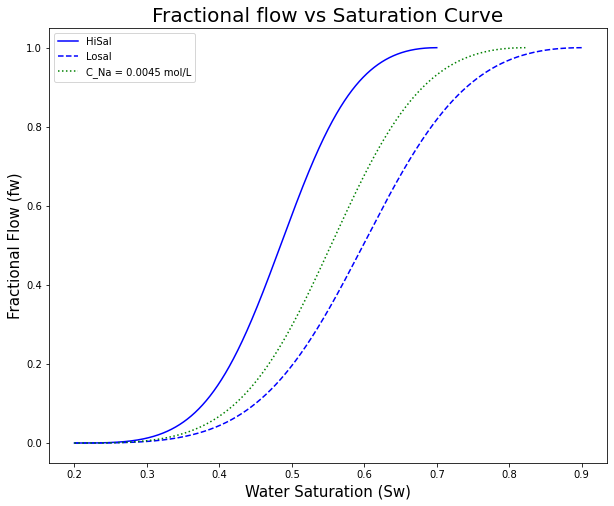

In [ ]:
na_conc = [0.01, 0.001, 0.0045]
spu1.fractional_flow_with_ions(perm1, na_conc, spu1, 'C_Na = 0.0045 mol/L')

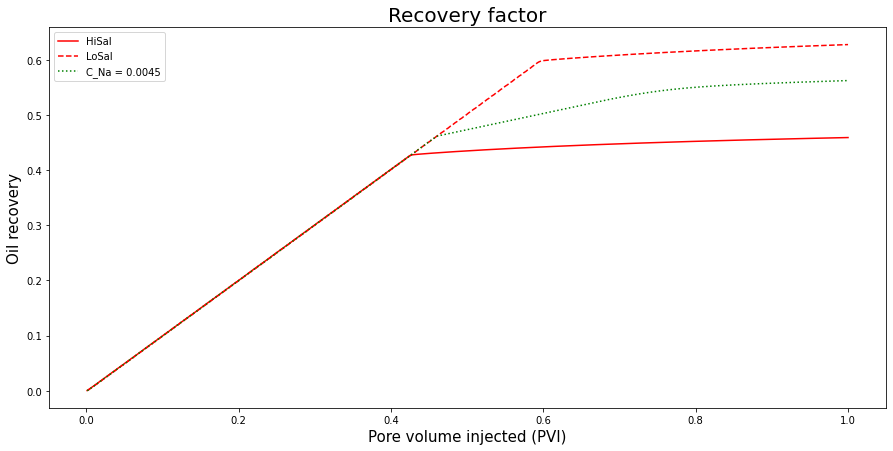

In [ ]:
recovered_oil = [hs_vector, ls_vector, vector]
finitedifference80.wu_recovery_factor_comparision(recovered_oil, 'C_Na = 0.0045')

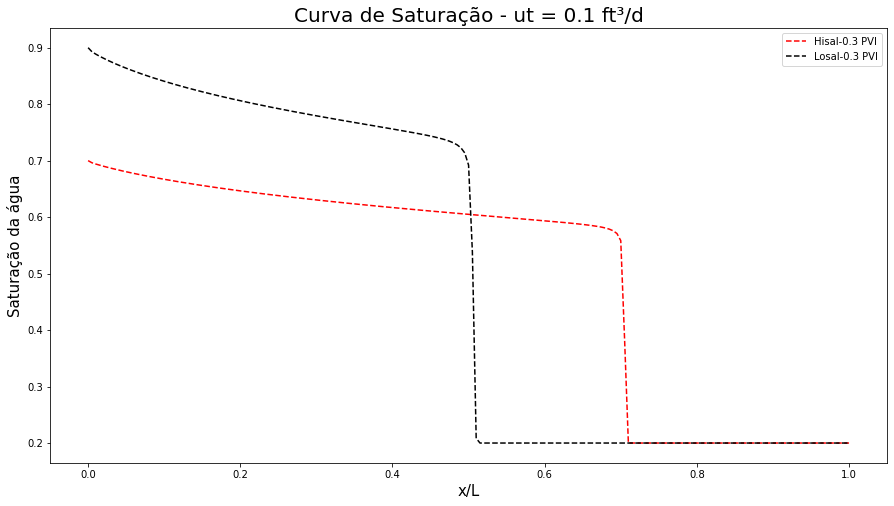

In [ ]:
finitedifference80.saturation_curve_comparision(ls_blmodel, ls_matrix, 3000, 'Hisal','Losal')

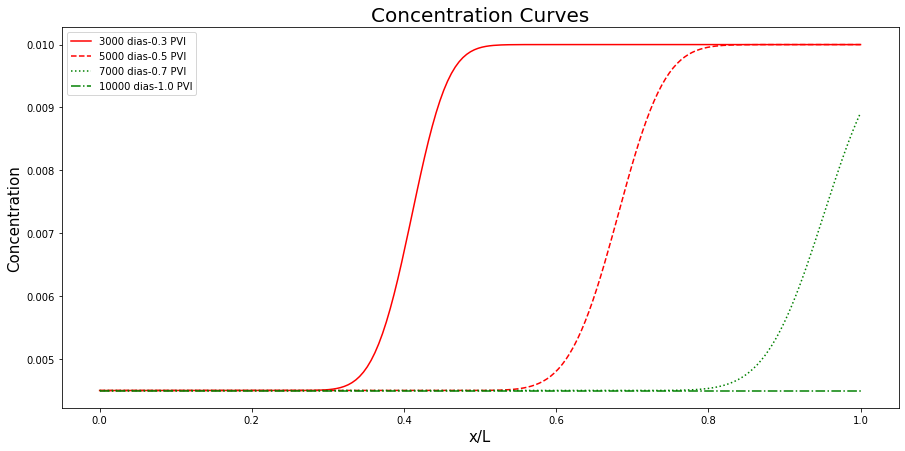

In [ ]:
td_vector = [3000, 5000, 7000, 10000]
finitedifference84.concentration_comparision(ion_matrix, td_vector)

Model 2

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = CoreyModel(0.2, 0.3, 3, 2, 0.1, 0.99)
hs_perm2 = TripathiModel(0.2, 'model2') 
hs_perm2.input_limits()

#Losal
ls_perm = CoreyModel(0.2, 0.1, 3, 2, 0.5, 0.99)
ls_perm2 = TripathiModel(0.2, 'model2')
ls_perm2.input_limits()

#set limits to Corey
ls_perm2.input_limits_corey(hs_perm, ls_perm)
hs_perm2.input_limits_corey(hs_perm, ls_perm)

#Test1
perm2 = TripathiModel(0.2, 'model2')
perm2.input_limits()
perm2.input_limits_corey(hs_perm, ls_perm)

#Creating the object that represents the Buckley-Leverett model
#Hisal
c_na_hs = 0.01
sw_cc_hs = 1-hs_perm2.sor_function(c_na_hs)
hs_blmodel = BLModel(0.2, sw_cc_hs, domain, 0.01, c_na_hs) # The concentration in the initial state is equal to hisal concentration.

#Losal
c_na_ls = 0.001
sw_cc_ls = 1-ls_perm2.sor_function(c_na_ls)
ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.

#test1
c_na = 0.0045
sw_cc = 1-perm2.sor_function(c_na)
blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()
blmodel1.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()
saturation1 = blmodel1.saturation_matrix()

#Creating concentration matrix
hs_concentration = hs_blmodel.concentration_matrix()
ls_concentration = ls_blmodel.concentration_matrix()
concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm2)
ls_spu = SinglePointUpstream(medium, ls_perm2)
spu2 = SinglePointUpstream(medium, perm2)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference85 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_concentration)
#finitedifference80.input_parameters(0.1, 0.05) #require a critical evaluation
#with different solver
#finitedifference81 = ExplicitMethod(hs_spu, hs_saturation2, hs_blmodel, domain, medium, hs_concentration)
#finitedifference81.input_parameters(0.1, 0.05) #require a critical evaluation

#Losal
finitedifference86 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)
#finitedifference82.input_parameters(0.1, 0.05) #require a critical evaluation 
#with different solver
#finitedifference83 = ExplicitMethod(ls_spu, ls_saturation2, ls_blmodel, domain, medium, ls_concentration)
#finitedifference83.input_parameters(0.1, 0.05) #require a critical evaluation 

#Test1
finitedifference87 = ExplicitMethod(spu2, saturation1, blmodel1, domain, medium, concentration1)
#finitedifference84.input_parameters(0.1, 0.05) #require a critical evaluation

In [ ]:
#EXPLICIT - SPU
#Hisal
finitedifference85.solver3_2()
hs_matrix = finitedifference85.get_matrix()
hs_ion_matrix = finitedifference85.get_ion_matrix()

finitedifference85.oil_recovery(medium, hs_matrix)
hs_vector = finitedifference85.get_recovered_oil_vector()

#Losal
finitedifference86.solver3_1()
ls_matrix = finitedifference86.get_matrix()
ls_ion_matrix = finitedifference86.get_ion_matrix()

finitedifference86.oil_recovery(medium, ls_matrix)
ls_vector = finitedifference86.get_recovered_oil_vector()

#Test 1 
finitedifference87.solver3_2()
matrix2 = finitedifference87.get_matrix()
ion_matrix2 = finitedifference87.get_ion_matrix()

finitedifference87.oil_recovery(medium, matrix2)
vector2 = finitedifference87.get_recovered_oil_vector()

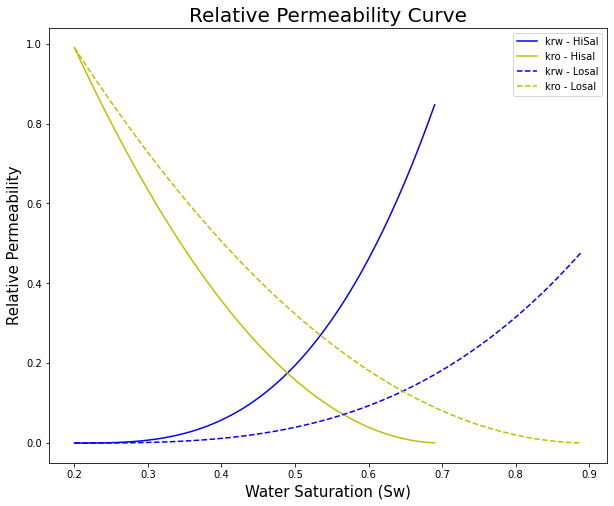

In [ ]:
perm = [hs_perm2, ls_perm2]
concentration = [0.01, 0.001]
hs_perm2.rel_perm_ions(perm, concentration)

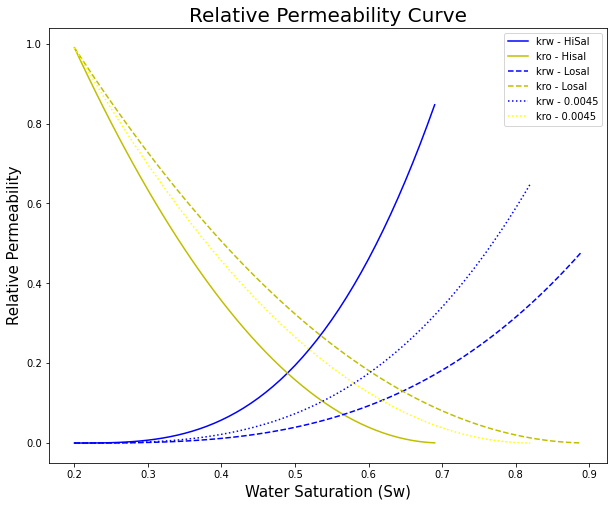

In [ ]:
perm = [hs_perm2, ls_perm2, perm2]
concentration = [0.01, 0.001, 0.0045]
hs_perm2.rel_perm_ions(perm, concentration, '0.0045')

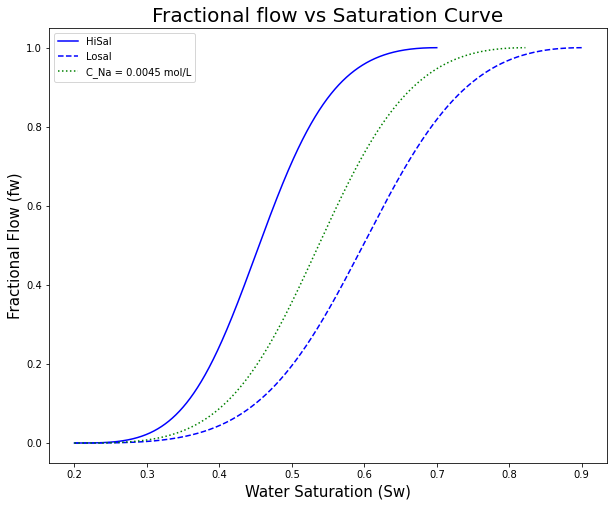

In [ ]:
na_conc = [0.01, 0.001, 0.0045]
spu2.fractional_flow_with_ions(perm2, na_conc, spu2, 'C_Na = 0.0045 mol/L')

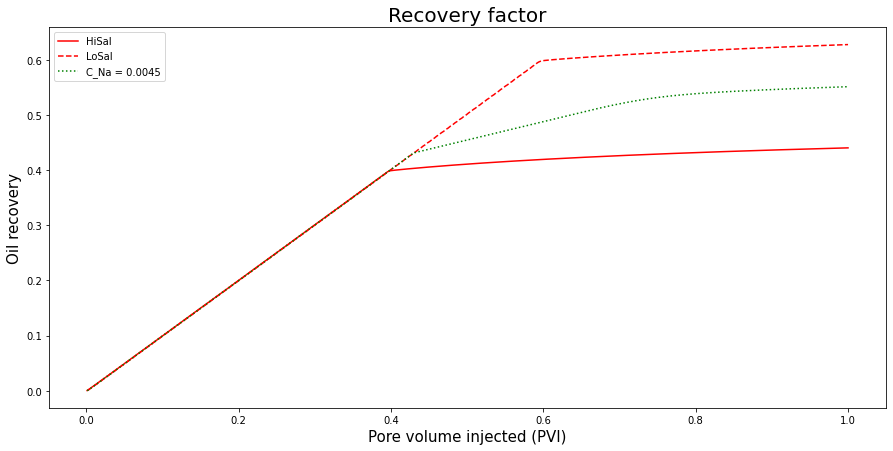

In [ ]:
recovered_oil = [hs_vector, ls_vector, vector2]
finitedifference85.wu_recovery_factor_comparision(recovered_oil, 'C_Na = 0.0045')

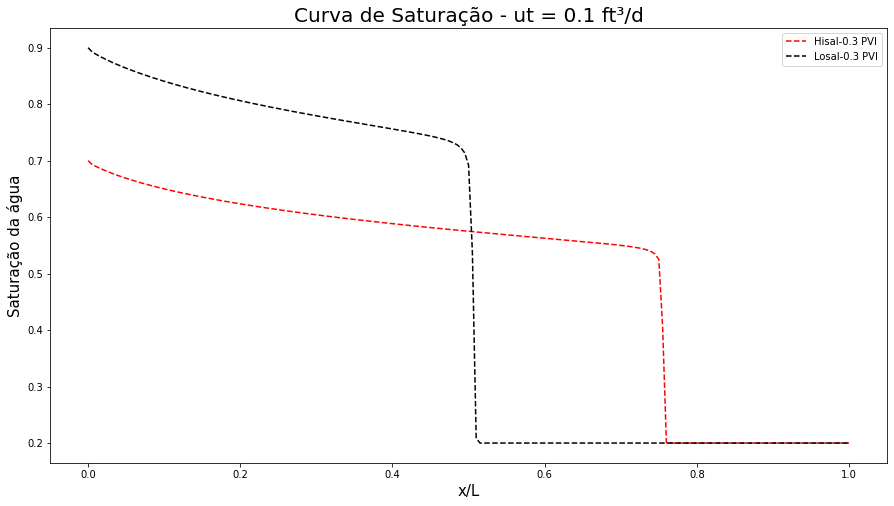

In [ ]:
finitedifference85.saturation_curve_comparision(ls_blmodel, ls_matrix, 3000, 'Hisal','Losal')

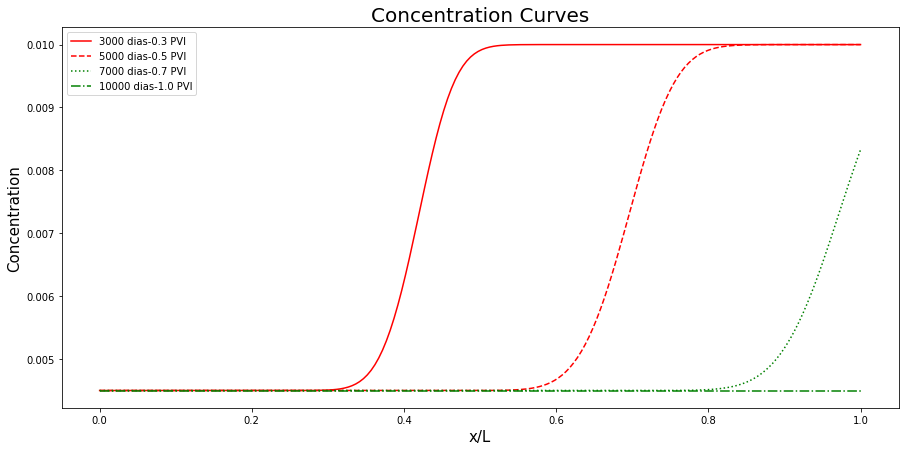

In [ ]:
td_vector = [3000, 5000, 7000, 10000]
finitedifference87.concentration_comparision(ion_matrix2, td_vector)

Model 3

In [ ]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = CoreyModel(0.2, 0.3, 3, 3, 0.5, 0.99)
hs_perm3 = TripathiModel(0.2, 'model3') 
hs_perm3.input_limits()

#Losal
ls_perm = CoreyModel(0.2, 0.1, 4, 2, 0.5, 0.99)
ls_perm3 = TripathiModel(0.2, 'model3')
ls_perm3.input_limits()

#set limits to Corey
ls_perm3.input_limits_corey(hs_perm, ls_perm)
hs_perm3.input_limits_corey(hs_perm, ls_perm)

#Test1
perm3 = TripathiModel(0.2, 'model3')
perm3.input_limits()
perm3.input_limits_corey(hs_perm, ls_perm)

#Creating the object that represents the Buckley-Leverett model
#Hisal
c_na_hs = 0.01
sw_cc_hs = 1-hs_perm3.sor_function(c_na_hs)
hs_blmodel = BLModel(0.2, sw_cc_hs, domain, 0.01, c_na_hs) # The concentration in the initial state is equal to hisal concentration.

#Losal
c_na_ls = 0.001
sw_cc_ls = 1-ls_perm3.sor_function(c_na_ls)
ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.

#test1
c_na = 0.0045
sw_cc = 1-perm3.sor_function(c_na)
blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
ls_blmodel.transition_time_matrix()
blmodel1.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
ls_saturation = ls_blmodel.saturation_matrix()
saturation1 = blmodel1.saturation_matrix()

#Creating concentration matrix
hs_concentration = hs_blmodel.concentration_matrix()
ls_concentration = ls_blmodel.concentration_matrix()
concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm3)
ls_spu = SinglePointUpstream(medium, ls_perm3)
spu3 = SinglePointUpstream(medium, perm3)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference88 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_concentration)

#Losal
finitedifference89 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)

#Test1
finitedifference90 = ExplicitMethod(spu3, saturation1, blmodel1, domain, medium, concentration1)

In [ ]:
#EXPLICIT - SPU
#Hisal
finitedifference88.solver3_2()
hs_matrix = finitedifference88.get_matrix()
hs_ion_matrix = finitedifference88.get_ion_matrix()

finitedifference88.oil_recovery(medium, hs_matrix)
hs_vector = finitedifference88.get_recovered_oil_vector()

#Losal
finitedifference89.solver3_1()
ls_matrix = finitedifference89.get_matrix()
ls_ion_matrix = finitedifference89.get_ion_matrix()

finitedifference89.oil_recovery(medium, ls_matrix)
ls_vector = finitedifference89.get_recovered_oil_vector()

#Test 1 
finitedifference90.solver3_2()
matrix3 = finitedifference90.get_matrix()
ion_matrix3 = finitedifference90.get_ion_matrix()

finitedifference90.oil_recovery(medium, matrix3)
vector3 = finitedifference90.get_recovered_oil_vector()

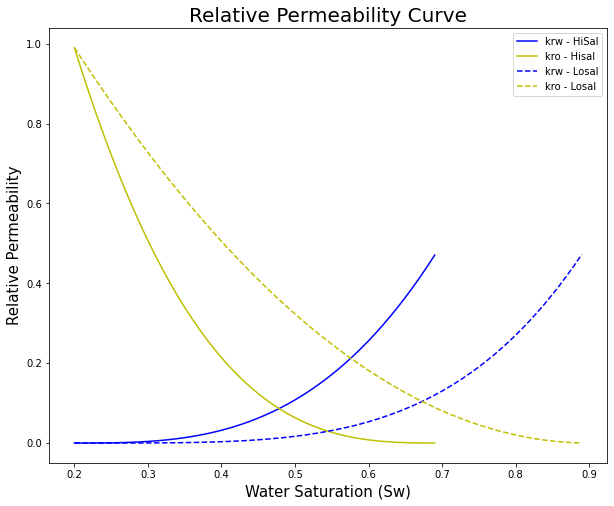

In [ ]:
perm = [hs_perm3, ls_perm3]
concentration = [0.01, 0.001]
hs_perm3.rel_perm_ions(perm, concentration)

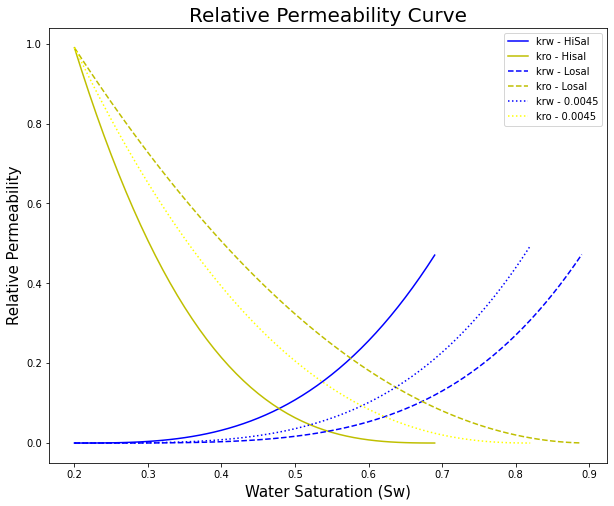

In [ ]:
perm = [hs_perm3, ls_perm3, perm3]
concentration = [0.01, 0.001, 0.0045]
hs_perm3.rel_perm_ions(perm, concentration, '0.0045')

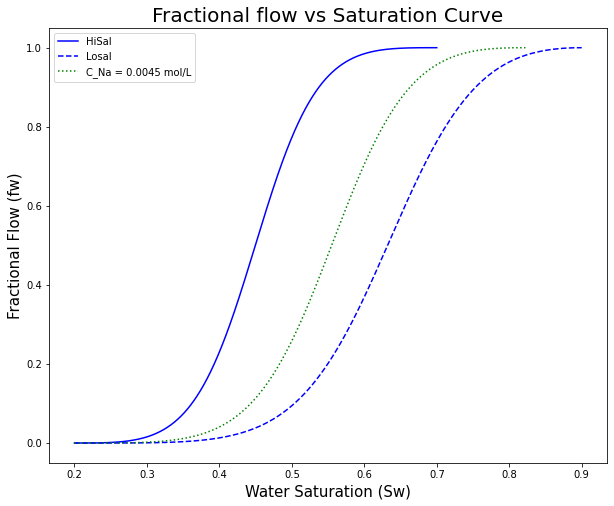

In [ ]:
na_conc = [0.01, 0.001, 0.0045]
spu3.fractional_flow_with_ions(perm3, na_conc, spu3, 'C_Na = 0.0045 mol/L')

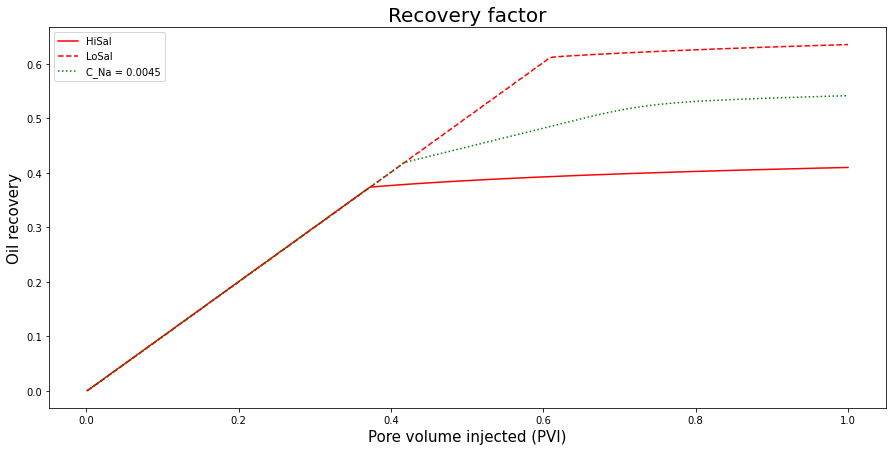

In [ ]:
recovered_oil = [hs_vector, ls_vector, vector3]
finitedifference88.wu_recovery_factor_comparision(recovered_oil, 'C_Na = 0.0045')

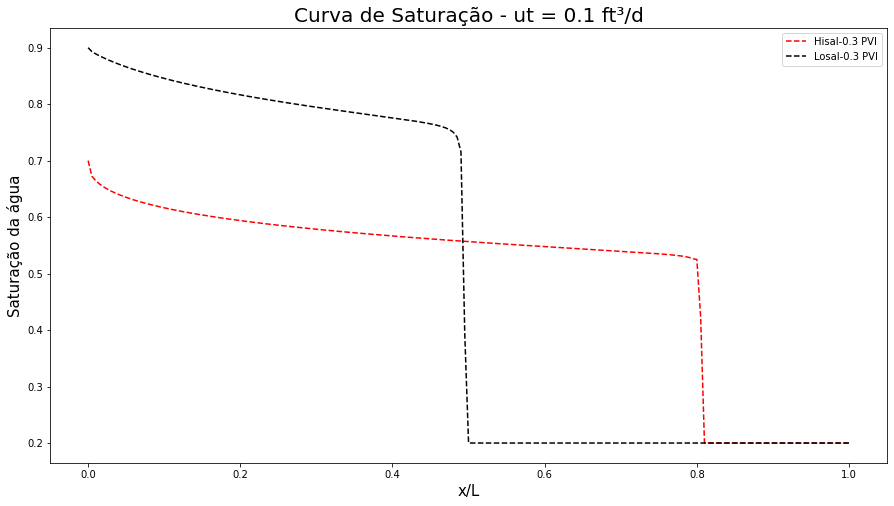

In [ ]:
finitedifference88.saturation_curve_comparision(ls_blmodel, ls_matrix, 3000, 'Hisal','Losal')

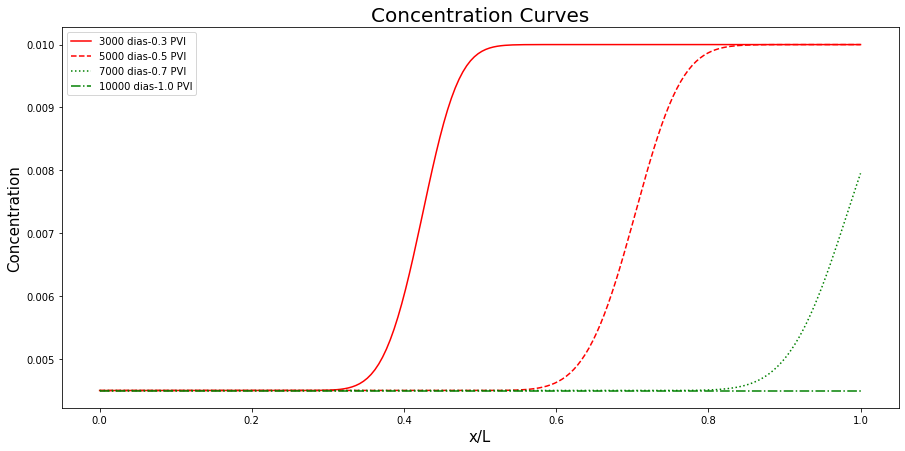

In [ ]:
td_vector = [3000, 5000, 7000, 10000]
finitedifference90.concentration_comparision(ion_matrix3, td_vector)

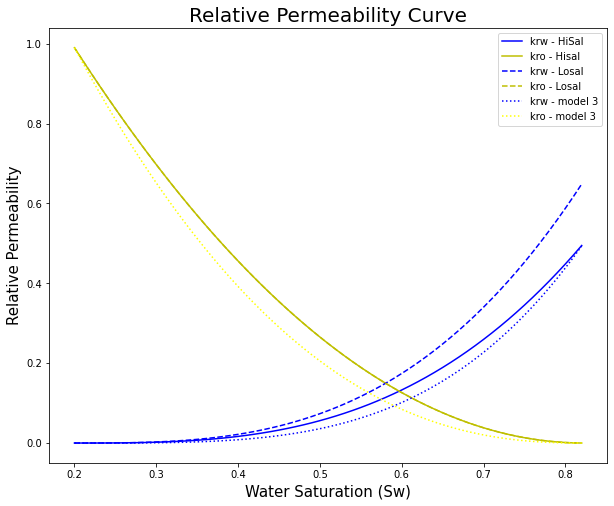

In [ ]:
perm = [perm1, perm2, perm3]
concentration = [0.0045, 0.0045, 0.0045]
hs_perm3.rel_perm_ions(perm, concentration, 'model 3')

## Multiple Ion Exchange (MIE)

In [7]:
#Creating the porous medium
medium = PorousMedium(0.2, 1, 2, 0.1)
#Creating the domain
domain = Domain(200, 10000, medium)

#vector domain
domain.vector_domain()
#grid length
grid = domain.grid_length(5000)
#grid dx
dx = domain.grid_dx()
#grid dt
dt = domain.grid_dt(10)
#Courant
Cu = domain.courant()

#Creating the object that represents the relative permeability using a model other than Corey
#Hisal
hs_perm = CoreyModel(0.15, 0.3, 3, 2, 0.3, 0.75)
hs_perm1 = MIEModel(0.15) 
hs_perm1.input_limits()
ions_hsw = [0.45014, 0.51912, 0.01299, 0.04551, 0.02401] # [Na, Cl, Ca, Mg, SO4]
ions_lsw = [0.013262, 0.016570, 0.001479, 0.000175, 0] # [Na, Cl, Ca, Mg, SO4]
hs_perm1.set_beta_0(ions_hsw)

#Losal
ls_perm = CoreyModel(0.15, 0.15, 3, 2, 0.4, 0.9)
ls_perm1 = MIEModel(0.15)
ls_perm1.input_limits()

#set limits to Corey
ls_perm1.input_limits_corey(hs_perm, ls_perm)
hs_perm1.input_limits_corey(hs_perm, ls_perm)

#Test1
perm1 = MIEModel(0.15)
perm1.input_limits()
perm1.input_limits_corey(hs_perm, ls_perm)
perm1.set_beta_0(ions_hsw)

#Creating the object that represents the Buckley-Leverett model
#Hisal
c_i_cc_hs = [0.45014, 0.51912, 0.01299, 0.04551, 0.02401]
c_i = [0.45014, 0.51912, 0.01299, 0.04551, 0.02401]
sw_cc_hs = 1-0.3
hs_blmodel = BLModel(0.15, sw_cc_hs, domain, c_i, c_i_cc_hs) # The concentration in the initial state is equal to hisal concentration.

#Losal
#c_na_ls = 0.001
#sw_cc_ls = 1-ls_perm1.sor_function(c_na_ls)
#ls_blmodel = BLModel(0.2, sw_cc_ls, domain, 0.01, c_na_ls) # The concentration in the initial state is equal to hisal concentration.

#test1
#c_na = 0.0045
#sw_cc = 1-perm1.sor_function(c_na)
#blmodel1 = BLModel(0.2, sw_cc, domain, 0.01, c_na) # The concentration in the initial state is equal to hisal concentration.

#Creating transition time matrix
hs_blmodel.transition_time_matrix()
#ls_blmodel.transition_time_matrix()
#blmodel1.transition_time_matrix()

#Creating saturation matrix
hs_saturation = hs_blmodel.saturation_matrix()
#ls_saturation = ls_blmodel.saturation_matrix()
#saturation1 = blmodel1.saturation_matrix()

#Creating concentration matrix
#Hisal
hs_Na_concentration = hs_blmodel.concentration_matrix()
hs_Cl_concentration = hs_blmodel.concentration_matrix()
hs_Ca_concentration = hs_blmodel.concentration_matrix()
hs_Mg_concentration = hs_blmodel.concentration_matrix()
hs_SO_concentration = hs_blmodel.concentration_matrix()
hs_concentration = [hs_Na_concentration, hs_Cl_concentration, hs_Ca_concentration, hs_Mg_concentration, hs_SO_concentration]
#Losal
#ls_concentration = ls_blmodel.concentration_matrix()
#LSW
#concentration1 = blmodel1.concentration_matrix()

#Choosing the fractional flow calculation approach
hs_spu = SinglePointUpstream(medium, hs_perm1)
#ls_spu = SinglePointUpstream(medium, ls_perm1)
#spu1 = SinglePointUpstream(medium, perm1)

#Creating the object that represents the chosen approach - SPU
#Hisal
finitedifference80 = ExplicitMethod(hs_spu, hs_saturation, hs_blmodel, domain, medium, hs_perm1, hs_concentration)
finitedifference80.input_parameters() 

#Losal
#finitedifference82 = ExplicitMethod(ls_spu, ls_saturation, ls_blmodel, domain, medium, ls_concentration)
#finitedifference82.input_parameters(0.1, 0.05) #require a critical evaluation 
#with different solver
#finitedifference83 = ExplicitMethod(ls_spu, ls_saturation2, ls_blmodel, domain, medium, ls_concentration)
#finitedifference83.input_parameters(0.1, 0.05) #require a critical evaluation 

#Test1
#finitedifference84 = ExplicitMethod(spu1, saturation1, blmodel1, domain, medium, concentration1)
#finitedifference84.input_parameters(0.1, 0.05) #require a critical evaluation